# ESTIMATING THE WINNING MARKET PRICE

## Index
### 1. Package and Data Loading
    Import all packages needed and load the data.
### 2. EDA
     Exploratory Data Analysis (EDA) to gain insights into the underlying patterns, relationships, and characteristics of a dataset to inform subsequent analyses and decision-making processes. Checking data types, unique values for each variable and their distributions using boxplots and histograms.
### 3. Feature Engineering
    Enhance the performance and interpretability of machine learning models by selecting, creating and transforming input features. Changing data formats, creating days of lifespan and month sold variable. Encoding fuel and car type, and dumming paint_color. Finish dropping the columns.
### 4. Data Cleaning
    Identify and rectify errors, inconsistencies, and inaccuracies in a dataset. Checking nulls, missing values and duplicates. Then dealing with outliers using z-scores.
### 5. Feature Selection and Standarization
    Choose the most relevant features for a modeland then ensure that different features are on a consistent scale. Using  Recursive Feature Elimination with Cross-Validation (RFECV) on a dataset. It fits a RandomForestRegressor for multiple random states, evaluates the performance for different feature selection sizes, and plots the cross-validation score. 
### 6. Model training
    First, split the dataset into: train, validation and test. Then train three diferent models: Linear Regressor,Random Forest and XGBoost Regressor, and comparing them all. If time create a baseline model.
### 7. Feature importance
    Getting the feature importance of the tree models using the weights of Linear Regression,the Feature Importance of the RF and finnaly usingh SHAP library of the XGBoost.
### 8. Seasonality
    Study how the value of a car change over time. First of all check the price variation over time depending of categorical features. And then checking seasonality in the auction and in the initial acquisition.
### 9. Which car to buy:
    Using the model to predict the future values of the cars in the dataset after a year and 10000miles. And then finding the best car in order to minimize the loss in absolute value.

## 1. Package and Data Loading


In [120]:
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler

In [44]:
df = pd.read_csv("C:/Users/PORTATIL/Escritorio/code/data_pricing_challenge.csv")

## 2. EDA

In [45]:
print("Dimension of our data set is: ")
print(df.shape)
df.head()

Dimension of our data set is: 
(4843, 18)


maker_key model_key  mileage  engine_power registration_date    fuel  \
0       BMW       118   140411           100          2/1/2012  diesel   
1       BMW        M4    13929           317          4/1/2016  petrol   
2       BMW       320   183297           120          4/1/2012  diesel   
3       BMW       420   128035           135          7/1/2014  diesel   
4       BMW       425    97097           160         12/1/2014  diesel   

  paint_color     car_type  feature_1  feature_2  feature_3  feature_4  \
0       black  convertible       True       True      False      False   
1        grey  convertible       True       True      False      False   
2       white  convertible      False      False      False      False   
3         red  convertible       True       True      False      False   
4      silver  convertible       True       True      False      False   

   feature_5  feature_6  feature_7  feature_8  price   sold_at  
0       True       True       True      False  11300  1/1/2018  
1      False       True       True       True  69700  2/1/2018  
2       True      False       True      False  10200  2/1/2018  
3       True       True       True       True  25100  2/1/2018  
4      False       True       True       True  33400  4/1/2018

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   maker_key          4843 non-null   object
 1   model_key          4843 non-null   object
 2   mileage            4843 non-null   int64 
 3   engine_power       4843 non-null   int64 
 4   registration_date  4843 non-null   object
 5   fuel               4843 non-null   object
 6   paint_color        4843 non-null   object
 7   car_type           4843 non-null   object
 8   feature_1          4843 non-null   bool  
 9   feature_2          4843 non-null   bool  
 10  feature_3          4843 non-null   bool  
 11  feature_4          4843 non-null   bool  
 12  feature_5          4843 non-null   bool  
 13  feature_6          4843 non-null   bool  
 14  feature_7          4843 non-null   bool  
 15  feature_8          4843 non-null   bool  
 16  price              4843 non-null   int64 


In [47]:
df.describe()

mileage  engine_power          price
count  4.843000e+03    4843.00000    4843.000000
mean   1.409628e+05     128.98823   15828.081767
std    6.019674e+04      38.99336    9220.285684
min   -6.400000e+01       0.00000     100.000000
25%    1.029135e+05     100.00000   10800.000000
50%    1.410800e+05     120.00000   14200.000000
75%    1.751955e+05     135.00000   18600.000000
max    1.000376e+06     423.00000  178500.000000

In [48]:
# Unique values of each column
df.nunique()

maker_key               1
model_key              75
mileage              4786
engine_power           61
registration_date     199
fuel                    4
paint_color            10
car_type                8
feature_1               2
feature_2               2
feature_3               2
feature_4               2
feature_5               2
feature_6               2
feature_7               2
feature_8               2
price                 437
sold_at                 9
dtype: int64

In [49]:
#Check diferent unique values for each column
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    
    print(f"Category in {col} is : {df[col].unique()}")

Category in maker_key is : ['BMW']
Category in model_key is : ['118' 'M4' '320' '420' '425' '335' '325' 'Z4' '120' '220' '650' '135'
 '218' '318' '430' 'M3' '330' '225' 'M235' '316' '435' '640'
 '640 Gran Coupé' '435 Gran Coupé' 'i8' '630' '430 Gran Coupé' '635' '520'
 '525' '530' '535' '320 Gran Turismo' '518' '116' '328' '523' 'X3' 'M550'
 '528' '325 Gran Turismo' '125' '318 Gran Turismo' '420 Gran Coupé' 'i3'
 '114' '520 Gran Turismo' '530 Gran Turismo' 'M135' '418 Gran Coupé'
 '330 Gran Turismo' '335 Gran Turismo' '730' '123' '535 Gran Turismo'
 '740' '750' 'ActiveHybrid 5' '735' 'M5' 'X5' 'X1' 'X4' 'X6' 'X6 M' 'X5 M'
 'X5 M50' '218 Active Tourer' '218 Gran Tourer' '216' '220 Active Tourer'
 '216 Gran Tourer' '216 Active Tourer' '225 Active Tourer'
 '214 Gran Tourer']
Category in registration_date is : ['2/1/2012' '4/1/2016' '4/1/2012' '7/1/2014' '12/1/2014' '5/1/2011'
 '5/1/2009' '8/1/2009' '7/1/2004' '6/1/2013' '9/1/2012' '9/1/2009'
 '3/1/2014' '8/1/2015' '1/1/2009' '4/1/2008' '7

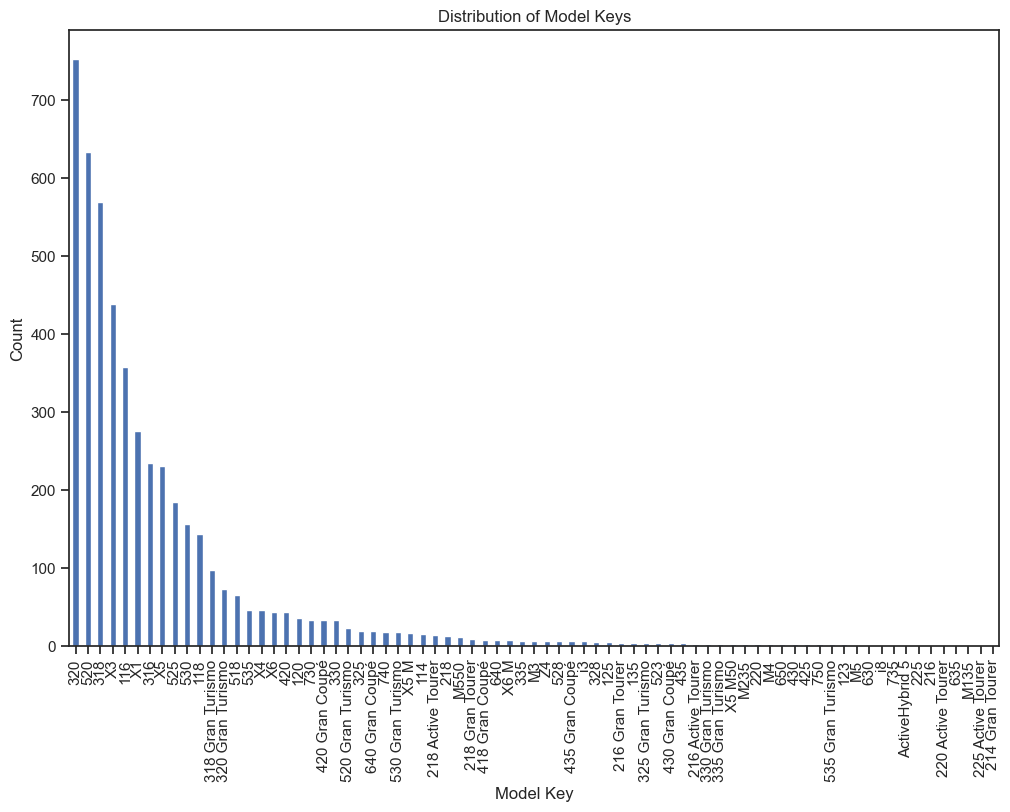

In [50]:
# Assuming df is your DataFrame
model_key_counts = df['model_key'].value_counts()

# Set a larger figure size (e.g., 10x6 inches)
plt.figure(figsize=(12, 8))

# Plot the bar chart
model_key_counts.plot(kind='bar')

# Set plot titles and labels
plt.title('Distribution of Model Keys')
plt.xlabel('Model Key')
plt.ylabel('Count')

# Show the plot
plt.show()

In [51]:
model_counts = df['model_key'].value_counts()

# Step 2: Filter models with more than 100 representations
models_more_than_100 = model_counts[model_counts >10]

# Step 3: Get the number of models that meet the condition
num_models_more_than_100 = len(models_more_than_100)

print(f"Number of models with more than 100 representations: {num_models_more_than_100}")

Number of models with more than 100 representations: 32


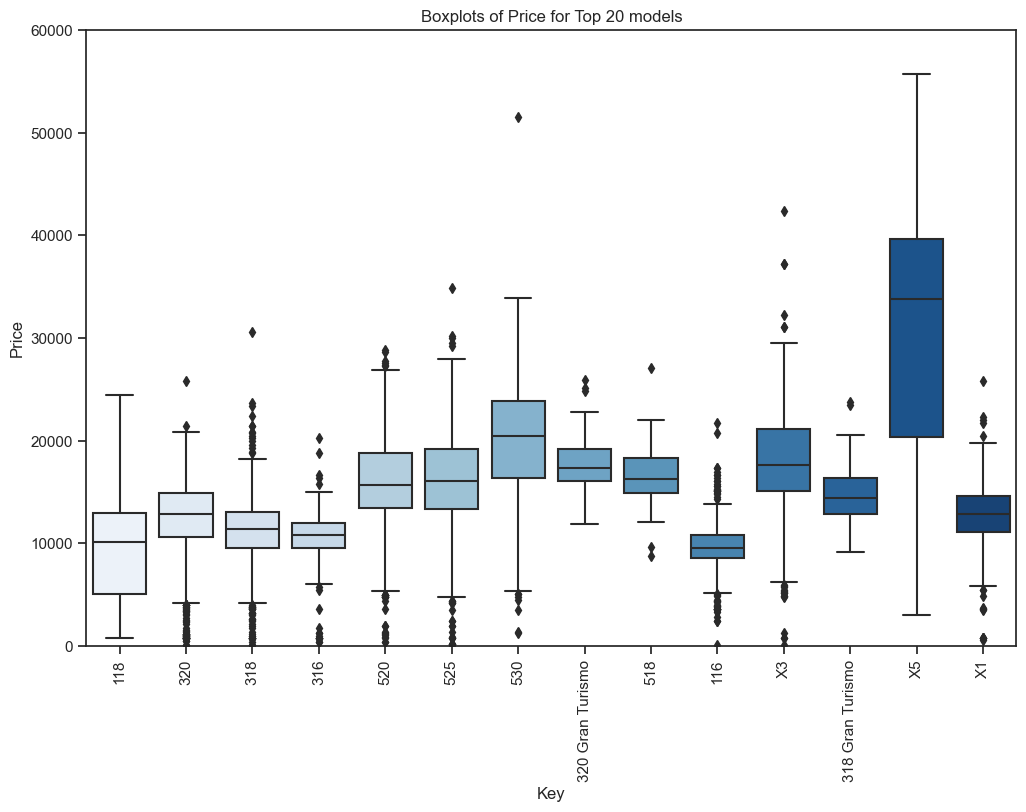

In [52]:
# Find the 20 most popular keys
top_keys = df['model_key'].value_counts().nlargest(14).index

#Filter the DataFrame for these top keys
df_top_keys = df[df['model_key'].isin(top_keys)]

# Create a boxplot 
plt.figure(figsize=(12, 8))
sns.boxplot(x='model_key', y='price', data=df_top_keys, palette="Blues")

plt.title('Boxplots of Price for Top 20 models')
plt.xlabel('Key')
plt.ylabel('Price')
plt.ylim([0, 60000])

plt.xticks(rotation=90)

plt.show()

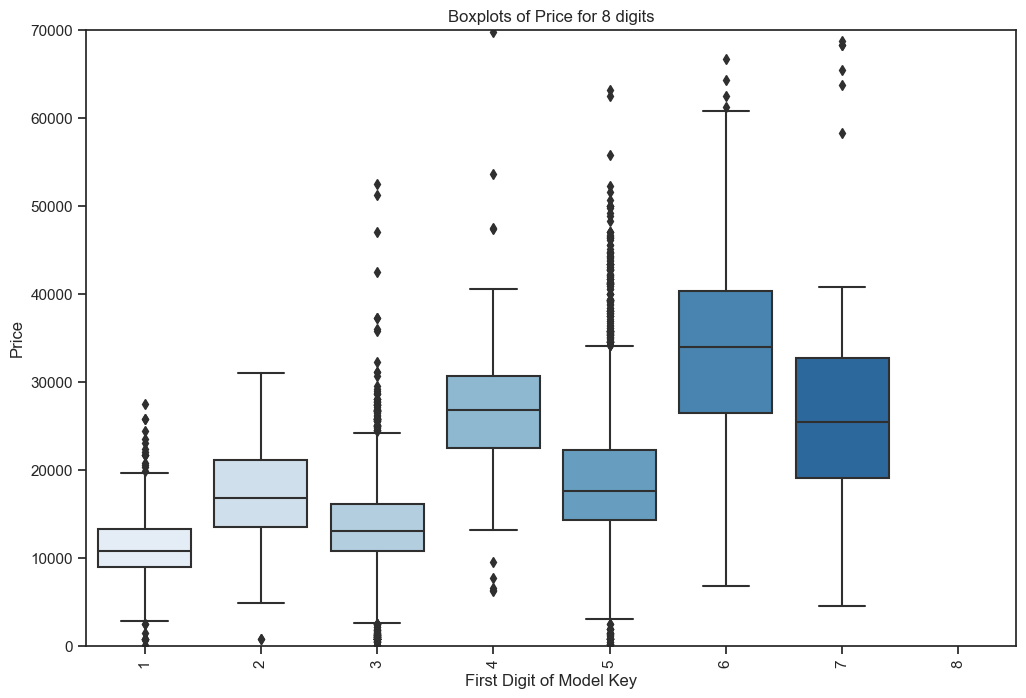

In [53]:
# Step 1: Extract the first digit from the 'model_key' column
df['first_digit'] = df['model_key'].str.extract('(\d)', expand=False)

# Step 2: Replace NaN values (where no digit was found) with 0
df['first_digit'] = df['first_digit'].fillna(0).astype(int)

# Step 4: Create a boxplot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='first_digit', y='price', data=df, palette="Blues")

# Step 5: Customize the plot
plt.title('Boxplots of Price for 8 digits')
plt.xlabel('First Digit of Model Key')
plt.ylabel('Price')
plt.ylim([0, 70000])

# Step 6: Rotate x-axis labels
plt.xticks(rotation=90)

# Step 7: Show the plot
plt.show()

In [54]:
# What is happening with first_digit 8?
df[df['first_digit']==8]

maker_key model_key  mileage  engine_power registration_date  \
90       BMW        i8    12402           170          1/1/2016   

             fuel paint_color car_type  feature_1  feature_2  feature_3  \
90  hybrid_petrol        grey    coupe       True       True      False   

    feature_4  feature_5  feature_6  feature_7  feature_8  price   sold_at  \
90      False      False      False      False       True  95200  4/1/2018   

    first_digit  
90            8

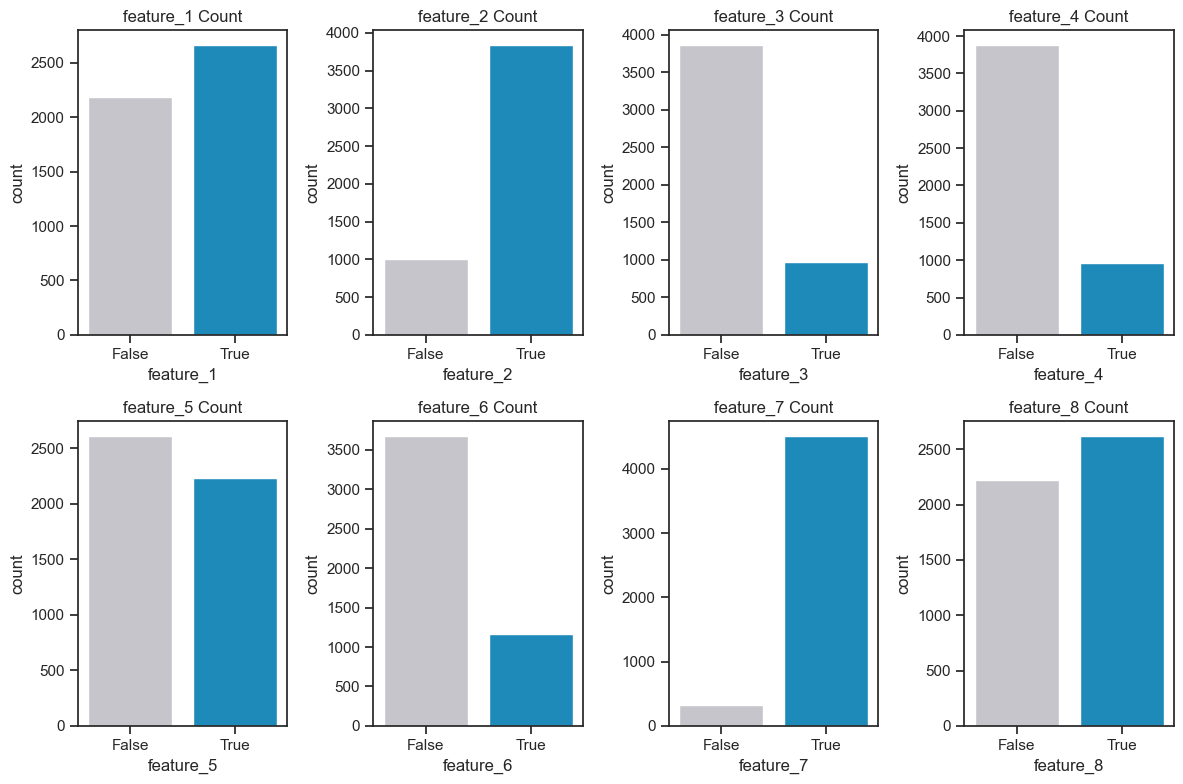

In [55]:
# Check distribution in boolean features
boolean_columns_list = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                        'feature_6', 'feature_7', 'feature_8']

# Set the color palette
color_palette = sns.color_palette(['#c4c4cc','#0494d4'])

plt.figure(figsize=(12, 8))
for i, boolean_col in enumerate(boolean_columns_list):
    plt.subplot(2, len(boolean_columns_list)//2, i + 1)
    sns.countplot(data=df, x=boolean_col, palette=color_palette)
    plt.title(f'{boolean_col} Count')

plt.tight_layout()
plt.show()

T-test for feature_1: p-value = 2.974802117206657e-81
T-test for feature_1: The difference in 'price' between the two groups is statistically significant.
T-test for feature_2: p-value = 3.970102978173407e-68
T-test for feature_2: The difference in 'price' between the two groups is statistically significant.
T-test for feature_3: p-value = 1.2526224977852713e-70
T-test for feature_3: The difference in 'price' between the two groups is statistically significant.
T-test for feature_4: p-value = 2.4632415648039564e-200
T-test for feature_4: The difference in 'price' between the two groups is statistically significant.
T-test for feature_5: p-value = 1.0514368080266622e-76
T-test for feature_5: The difference in 'price' between the two groups is statistically significant.
T-test for feature_6: p-value = 7.490806996664529e-50
T-test for feature_6: The difference in 'price' between the two groups is statistically significant.
T-test for feature_7: p-value = 0.710404817491123
T-test for featu

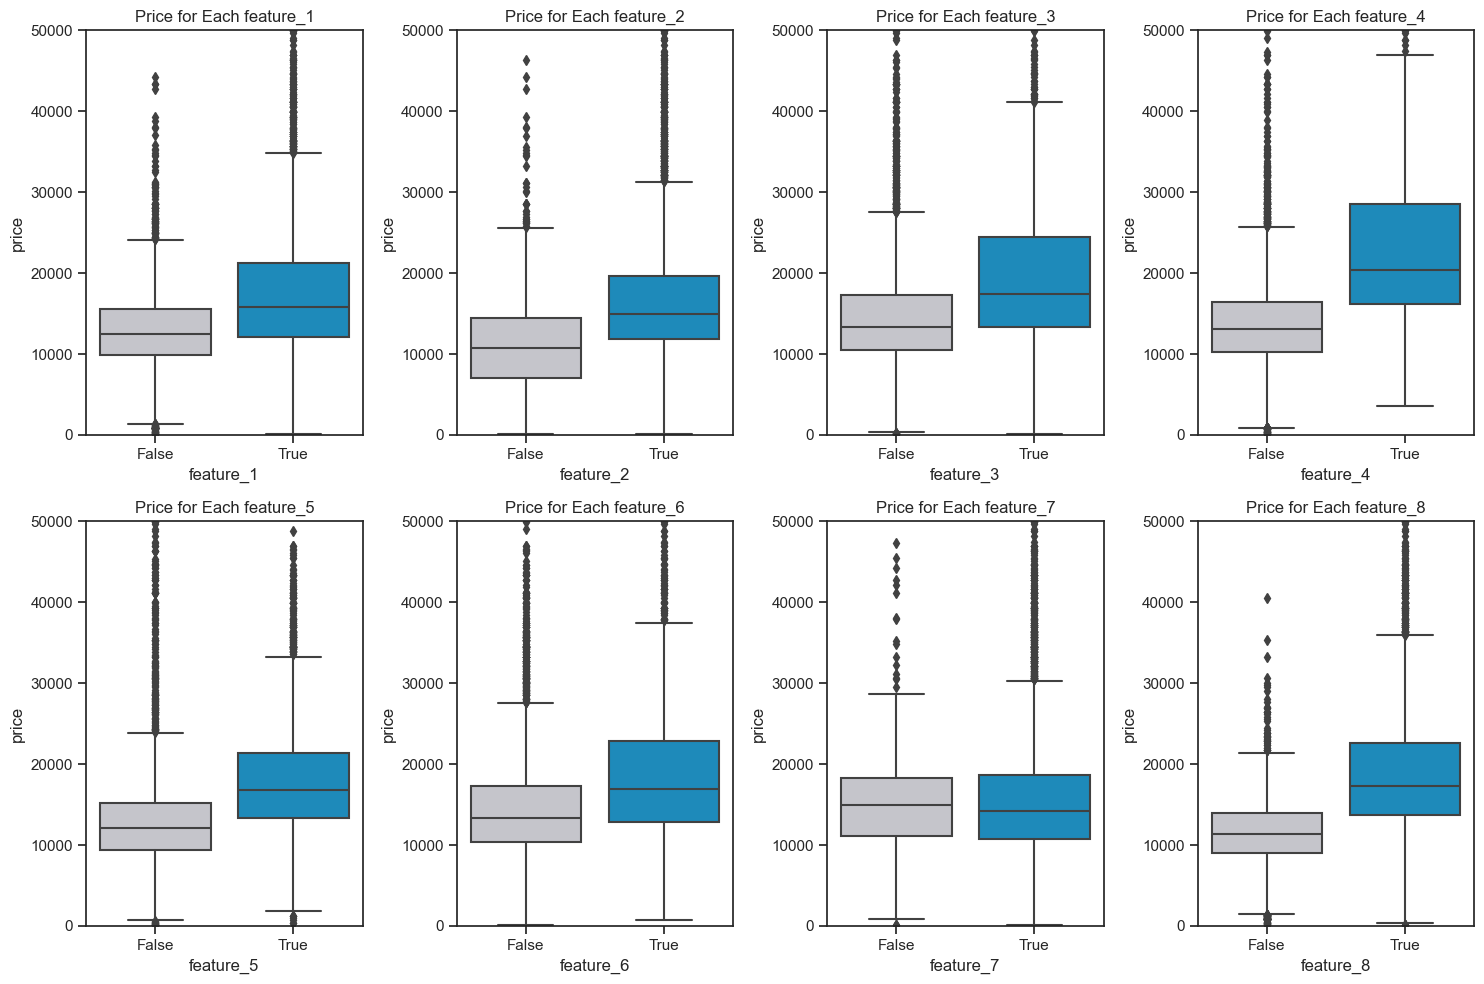

In [56]:
# Check if price distributions are diferent depending on bool features

boolean_columns_list = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                        'feature_6', 'feature_7', 'feature_8']

# Set the color palette
color_palette = sns.color_palette(['#c4c4cc','#0494d4'])

plt.figure(figsize=(15, 10))

# Create boxplot for 'price' for each option of each boolean feature
for i, boolean_col in enumerate(boolean_columns_list, 1):
    plt.subplot(2, len(boolean_columns_list)//2, i)
    sns.boxplot(x=boolean_col, y='price', data=df, palette=color_palette)
    plt.title(f'Price for Each {boolean_col}')
    plt.ylim([0, 50000])

    # Conduct t-test for each pair of boolean feature options
    unique_options = df[boolean_col].unique()
    if len(unique_options) == 2: 
        group1 = df[df[boolean_col] == unique_options[0]]['price']
        group2 = df[df[boolean_col] == unique_options[1]]['price']
        t_statistic, p_value = ttest_ind(group1, group2)
        print(f"T-test for {boolean_col}: p-value = {p_value}")
        if p_value < 0.05:
            print(f"T-test for {boolean_col}: The difference in 'price' between the two groups is statistically significant.")
        else:
            print(f"T-test for {boolean_col}: There is no strong evidence of a significant difference in 'price' between the two groups.")
plt.tight_layout()
plt.show()

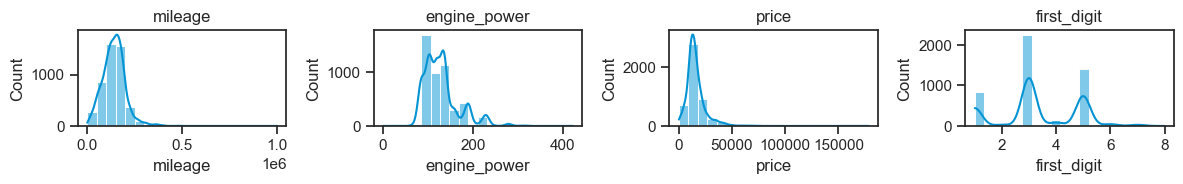

In [57]:
# Check distribution of the numerical features
numerical_features = df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features.columns):
    plt.subplot(5,4, i + 1)
    sns.histplot(data=df[feature], bins=20, kde=True,color='#0494d4')
    plt.title(feature)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [58]:
# Change Formats
df['registration_date'] = pd.to_datetime(df['registration_date'], format='%m/%d/%Y')
df['sold_at'] = pd.to_datetime(df['sold_at'], format='%m/%d/%Y')

# Calculate the difference in days
df['lifespan'] = (df['sold_at'] - df['registration_date']).dt.days

# Get month sold
df['month_sold'] = df['sold_at'].dt.month

In [59]:
# Define the custom order
fuel_order = ['diesel', 'petrol', 'hybrid_petrol', 'electro']

# Initialize LabelEncoder with the custom order
label_encoder = LabelEncoder()
label_encoder.classes_ = fuel_order

# Transform the 'fuel' column using the label encoder
df['fuel_encoded'] = label_encoder.transform(df['fuel'])

While there may not be a strict order in terms of size or classification, there is a general hierarchy or classification that is commonly used in the automotive industry. Here's a general order from smaller to larger vehicle types:

Subcompact -  
Hatchback - 
Sedan - 
Coupe - 
Convertible - 
SUV (Sport Utility Vehicle) - 
Estate (or wagon) - 
Van


In [60]:
# Define the custom order
type_order = ['subcompact','hatchback','sedan','coupe','convertible','suv','estate','van']

# Initialize LabelEncoder with the custom order
label_encoder = LabelEncoder()
label_encoder.classes_ = type_order

# Transform the 'fuel' column using the label encoder
df['type_encoded'] = label_encoder.transform(df['car_type'])

In [61]:
# Dummy paint color
df = pd.get_dummies(df, columns=['paint_color'], prefix='color_')

for col in df.columns:
    if col.startswith('color_'):
        df[col] = df[col].astype(bool)

In [62]:
df.describe()

mileage  engine_power          price  first_digit      lifespan  \
count  4.843000e+03    4843.00000    4843.000000  4843.000000   4843.000000   
mean   1.409628e+05     128.98823   15828.081767     3.351642   1983.724551   
std    6.019674e+04      38.99336    9220.285684     1.452835    927.278443   
min   -6.400000e+01       0.00000     100.000000     1.000000    215.000000   
25%    1.029135e+05     100.00000   10800.000000     3.000000   1489.000000   
50%    1.410800e+05     120.00000   14200.000000     3.000000   1765.000000   
75%    1.751955e+05     135.00000   18600.000000     5.000000   2130.000000   
max    1.000376e+06     423.00000  178500.000000     8.000000  10258.000000   

        month_sold  fuel_encoded  type_encoded  
count  4843.000000   4843.000000   4843.000000  
mean      4.926698      0.044600      3.875490  
std       2.157615      0.222805      2.069722  
min       1.000000      0.000000      0.000000  
25%       3.000000      0.000000      2.000000  
50%       5.000000      0.000000      5.000000  
75%       7.000000      0.000000      6.000000  
max       9.000000      3.000000      7.000000

In [63]:
columns_to_drop = ['maker_key','car_type','registration_date', 'sold_at','fuel','model_key']
cleaned_df = df.drop(columns=columns_to_drop)

In [64]:
corr = cleaned_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [65]:
# Calculate the correlation matrix
corr = cleaned_df.corr()

# Extract correlations with 'price' and sort them in descending order
correlation_with_price = corr['price'].drop('price')
sorted_correlations = correlation_with_price.abs().sort_values(ascending=False)

# Print or visualize the sorted correlations
print("Top correlated features with 'price':")
print(sorted_correlations)

Top correlated features with 'price':
engine_power     0.638989
lifespan         0.445058
feature_8        0.443122
first_digit      0.441742
feature_4        0.414389
mileage          0.409564
feature_1        0.269320
feature_5        0.261768
feature_3        0.251275
feature_2        0.246808
feature_6        0.210966
color__white     0.057531
color__green     0.057161
type_encoded     0.046006
color__blue      0.032061
color__silver    0.029634
color__black     0.026750
color__grey      0.014263
color__brown     0.013742
month_sold       0.013613
fuel_encoded     0.012178
color__orange    0.011608
color__red       0.007593
feature_7        0.005337
color__beige     0.000110
Name: price, dtype: float64


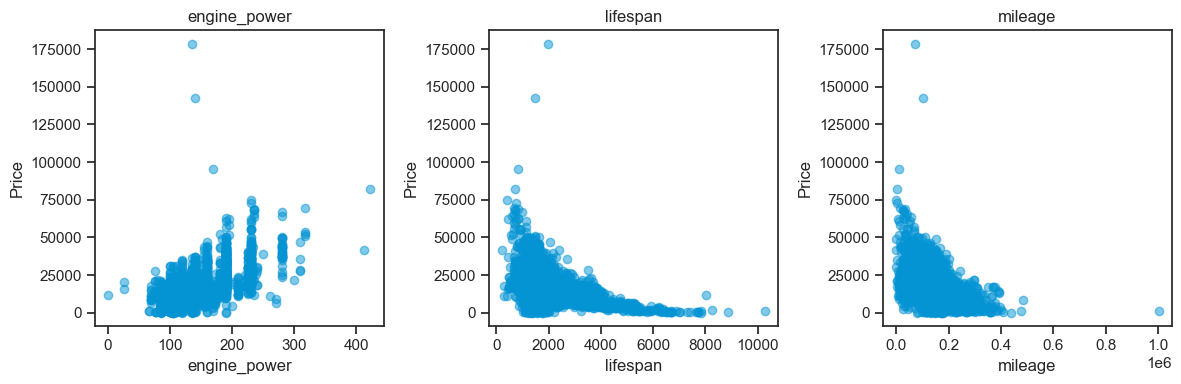

In [103]:
important_features = ['engine_power','lifespan','mileage']
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

for i, feature in enumerate(important_features, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[feature], df['price'], alpha=0.5, color='#0494d4')  # Adjust alpha for shading
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Price')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

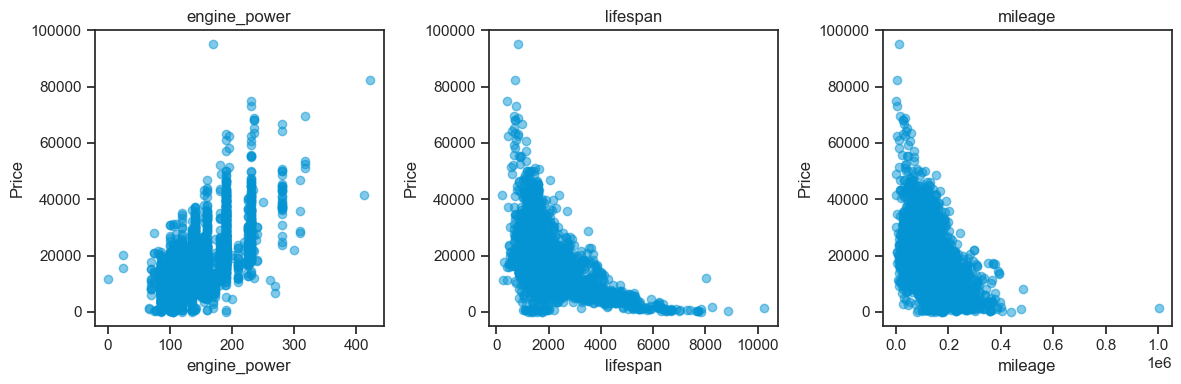

In [104]:
important_features = ['engine_power','lifespan','mileage']
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

for i, feature in enumerate(important_features, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[feature], df['price'], alpha=0.5, color='#0494d4')  # Adjust alpha for shading
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.ylim([-5000,100000])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## 4. Data Cleaning

In [105]:
# Check if there are null values in columns
df.isnull().sum()

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
first_digit          0
lifespan             0
month_sold           0
fuel_encoded         0
type_encoded         0
color__beige         0
color__black         0
color__blue          0
color__brown         0
color__green         0
color__grey          0
color__orange        0
color__red           0
color__silver        0
color__white         0
dtype: int64

In [106]:
# Check Duplication
df.duplicated().sum()

0

In [107]:
numerical_columns = df.select_dtypes(include='number')
columns_to_exclude = [col for col in numerical_columns.columns if 'color' in col]

# Drop columns containing the word 'color'
numerical_columns = numerical_columns.drop(columns=columns_to_exclude)

z_scores = zscore(numerical_columns)
# Create a DataFrame of z-scores
z_scores_df = pd.DataFrame(z_scores, columns=numerical_columns.columns)

# Identify outliers based on a threshold 
outliers = (z_scores_df.abs() > 3)

# Filter out rows containing outliers
cleaned_df = cleaned_df[~outliers.any(axis=1)]

print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {cleaned_df.shape}")


Original DataFrame shape: (4843, 32)
Cleaned DataFrame shape: (4448, 26)


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_19436\226142533.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[~outliers.any(axis=1)]


In [108]:
cleaned_df.columns

Index(['mileage', 'engine_power', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'price', 'first_digit', 'lifespan', 'month_sold', 'fuel_encoded',
       'type_encoded', 'color__beige', 'color__black', 'color__blue',
       'color__brown', 'color__green', 'color__grey', 'color__orange',
       'color__red', 'color__silver', 'color__white'],
      dtype='object')

In [109]:
# Calculate the ranges for each variable that are not outliers
ranges = cleaned_df.agg(lambda x: (x.min(), x.max()))

# Print the ranges
print("Ranges for variables that are not outliers:")
ranges[['mileage', 'engine_power', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
       'price', 'first_digit', 'lifespan', 'month_sold', 'fuel_encoded',
       'type_encoded']]

Ranges for variables that are not outliers:


mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
0      476            70      False      False      False      False   
1   321498           233       True       True       True       True   

   feature_5  feature_6  feature_7  feature_8  price  first_digit  lifespan  \
0      False      False      False      False    600            1       215   
1       True       True       True       True  43400            7      4748   

   month_sold  fuel_encoded  type_encoded  
0           1             0             0  
1           9             0             7

In [110]:
numerical_columns = df.select_dtypes(include='number')
# Drop columns containing the word 'color'

z_scores = zscore(numerical_columns)
# Create a DataFrame of z-scores
z_scores_df = pd.DataFrame(z_scores, columns=numerical_columns.columns)

# Identify outliers based on a threshold 
outliers = (z_scores_df.abs() > 3)

# Filter out rows containing outliers
cleaned_df = cleaned_df[~outliers.any(axis=1)]

# Print the shape of the cleaned DataFrame
print(f"Original DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape: {cleaned_df.shape}")
# Calculate the ranges for each variable that are not outliers
ranges = cleaned_df.agg(lambda x: (x.min(), x.max()))

# Print the ranges
print("Ranges for variables that are not outliers:")
ranges

Original DataFrame shape: (4843, 32)
Cleaned DataFrame shape: (4448, 26)
Ranges for variables that are not outliers:


C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_19436\1923336926.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_df = cleaned_df[~outliers.any(axis=1)]


mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
0      476            70      False      False      False      False   
1   321498           233       True       True       True       True   

   feature_5  feature_6  feature_7  feature_8  ...  color__beige  \
0      False      False      False      False  ...         False   
1       True       True       True       True  ...          True   

   color__black  color__blue  color__brown  color__green  color__grey  \
0         False        False         False         False        False   
1          True         True          True          True         True   

   color__orange  color__red  color__silver  color__white  
0          False       False          False         False  
1           True        True           True          True  

[2 rows x 26 columns]

In [115]:
pre_std = cleaned_df.copy()
print(f"Cleaned DataFrame shape: {cleaned_df.shape}")

Cleaned DataFrame shape: (4416, 26)


## 5. Feature Selection and Standarization

In [118]:
# Split in X and y target
X = cleaned_df.drop('price', axis=1)
y = cleaned_df['price']

In [119]:
# Assuming 'price' is the target variable
X = cleaned_df.drop('price', axis=1)
y = cleaned_df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regressor as the base model
model = RandomForestRegressor()

# Initialize RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Print the ranking of features
print("Feature Ranking:")
print(pd.DataFrame({'Feature': X.columns, 'Ranking': rfecv.ranking_}))

# Get the selected features
selected_features = X.columns[rfecv.support_]
print("\nSelected Features:")
print(selected_features)

# Train a model with the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_features])

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("\nMean Squared Error on Test Set:", mse)


Optimal number of features: 12
Feature Ranking:
          Feature  Ranking
0         mileage        1
1    engine_power        1
2       feature_1        1
3       feature_2        1
4       feature_3        2
5       feature_4        1
6       feature_5        1
7       feature_6        1
8       feature_7        5
9       feature_8        1
10    first_digit        1
11       lifespan        1
12     month_sold        1
13   fuel_encoded       14
14   type_encoded        1
15   color__beige       11
16   color__black        4
17    color__blue        3
18   color__brown        8
19   color__green       12
20    color__grey        6
21  color__orange       13
22     color__red       10
23  color__silver        9
24   color__white        7

Selected Features:
Index(['mileage', 'engine_power', 'feature_1', 'feature_2', 'feature_4',
       'feature_5', 'feature_6', 'feature_8', 'first_digit', 'lifespan',
       'month_sold', 'type_encoded'],
      dtype='object')

Mean Squared Error on T

In [121]:
selected_features

Index(['mileage', 'engine_power', 'feature_1', 'feature_2', 'feature_4',
       'feature_5', 'feature_6', 'feature_8', 'first_digit', 'lifespan',
       'month_sold', 'type_encoded'],
      dtype='object')

In [123]:
def standarize(df):
    features_to_std = ['mileage', 'engine_power', 'lifespan']

    # Extract the features to be standardized
    features_subset = df[features_to_std]

    scaler = StandardScaler()

    # Fit and transform the selected features
    scaled_features = scaler.fit_transform(features_subset)

    # Replace the original features with the standardized ones
    df[features_to_std] = scaled_features
    return df
cleaned_df = standarize(cleaned_df)

## 6. Model Training

In [124]:

def plot_hyperparameter_boxplots(mean_test_scores, params_list, param_grid):
    # Convert mean test scores to RMSE values
    rmse_values = np.sqrt(-mean_test_scores)

    # Extract hyperparameter values for each combination
    param_names = list(param_grid.keys())
    param_values = [[params[name] for params in params_list] for name in param_names]  # List of lists for each parameter

    # Function to plot boxplots for RMSE values for a specific hyperparameter
    def plot_hyperparameter(ax, hyperparameter_values, rmse_values, xlabel, ylabel):
        unique_values = list(set(hyperparameter_values))
        positions = range(1, len(unique_values) + 1)

        # Create a dictionary to store the RMSE values for each unique hyperparameter value
        rmse_dict = {val: [] for val in unique_values}

        # Populate the dictionary with corresponding RMSE values
        for i, val in enumerate(hyperparameter_values):
            rmse_dict[val].append(rmse_values[i])

        # Create a list of lists for boxplot_data
        boxplot_data = [rmse_dict[val] for val in unique_values]

        # Plot the boxplot
        ax.boxplot(boxplot_data, labels=unique_values, positions=positions)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot for each hyperparameter
    for i, param_name in enumerate(param_names):
        plot_hyperparameter(axes[i // 3, i % 3], param_values[i], rmse_values, param_name, 'RMSE')

    # Hide the empty subplot
    axes[1, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [125]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4416 entries, 0 to 4842
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mileage        4416 non-null   float64
 1   engine_power   4416 non-null   float64
 2   feature_1      4416 non-null   bool   
 3   feature_2      4416 non-null   bool   
 4   feature_3      4416 non-null   bool   
 5   feature_4      4416 non-null   bool   
 6   feature_5      4416 non-null   bool   
 7   feature_6      4416 non-null   bool   
 8   feature_7      4416 non-null   bool   
 9   feature_8      4416 non-null   bool   
 10  price          4416 non-null   int64  
 11  first_digit    4416 non-null   int32  
 12  lifespan       4416 non-null   float64
 13  month_sold     4416 non-null   int64  
 14  fuel_encoded   4416 non-null   int32  
 15  type_encoded   4416 non-null   int32  
 16  color__beige   4416 non-null   bool   
 17  color__black   4416 non-null   bool   
 18  color__b

In [126]:
X = cleaned_df[selected_features]
y = cleaned_df['price']
# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 33)

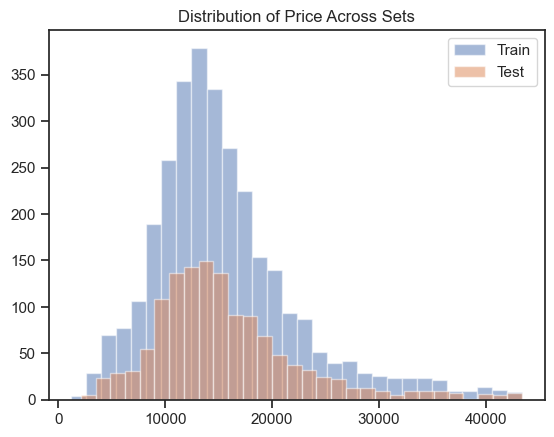

In [127]:
# Check the distribution of 'price' across sets
plt.hist(y_train, bins=30, alpha=0.5, label='Train')
plt.hist(y_test, bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title('Distribution of Price Across Sets')
plt.show()

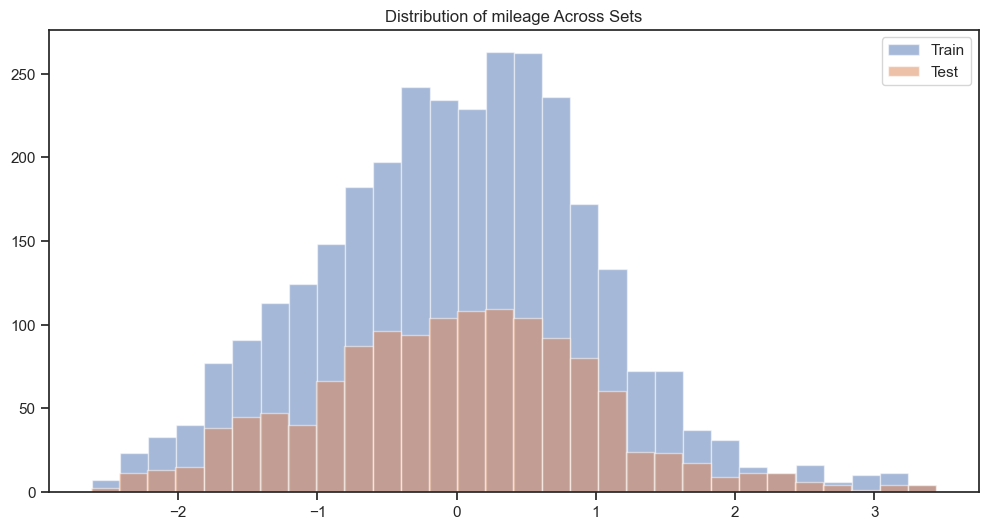

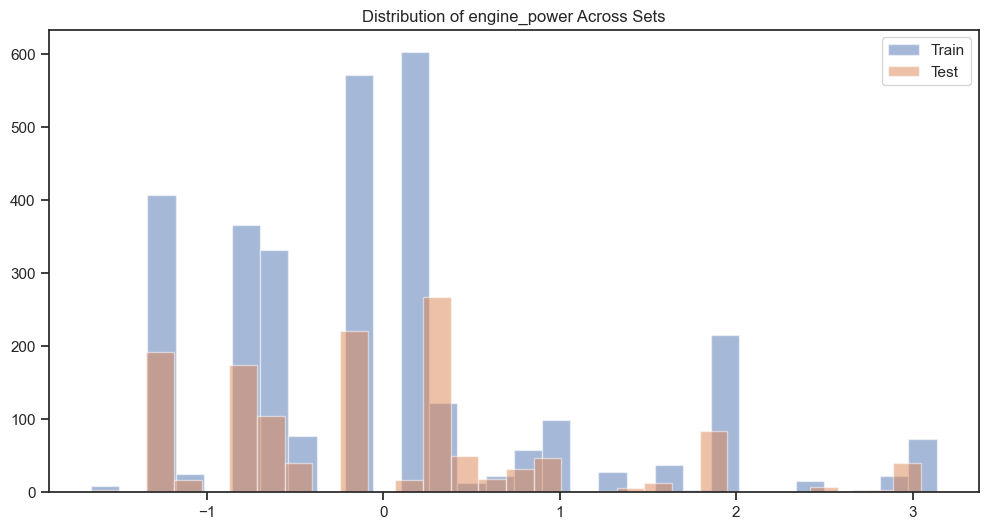

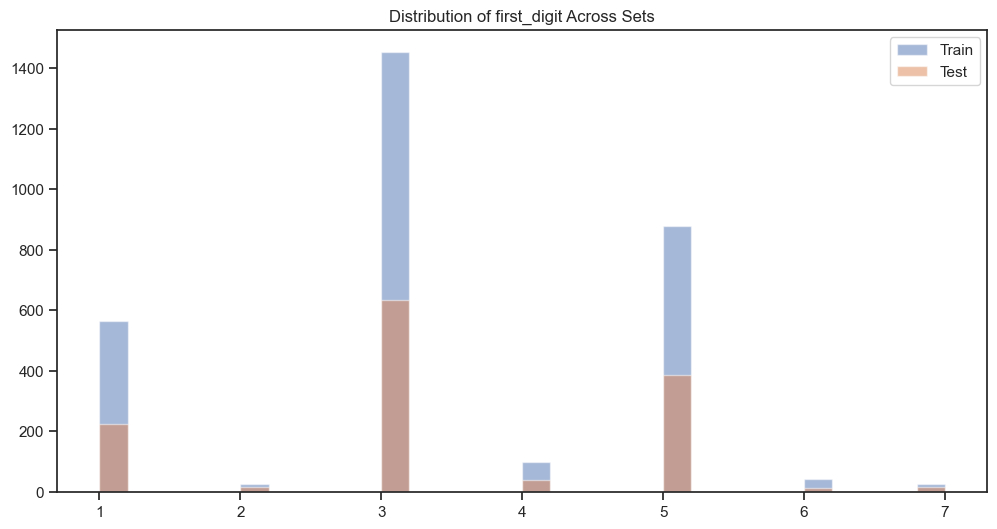

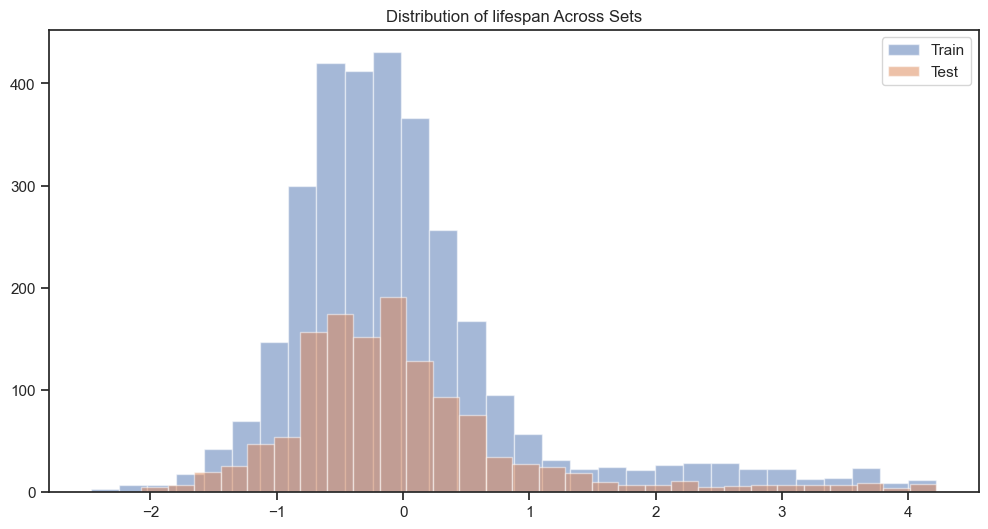

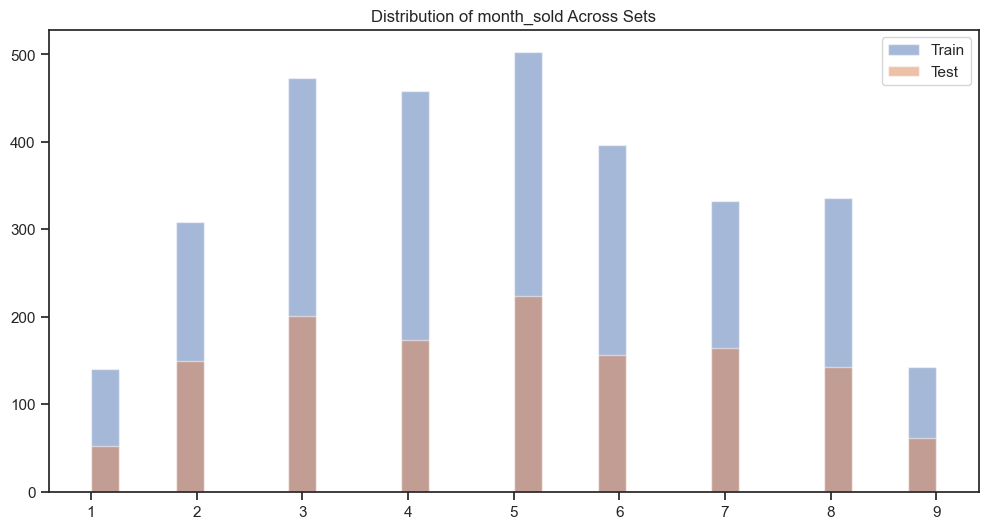

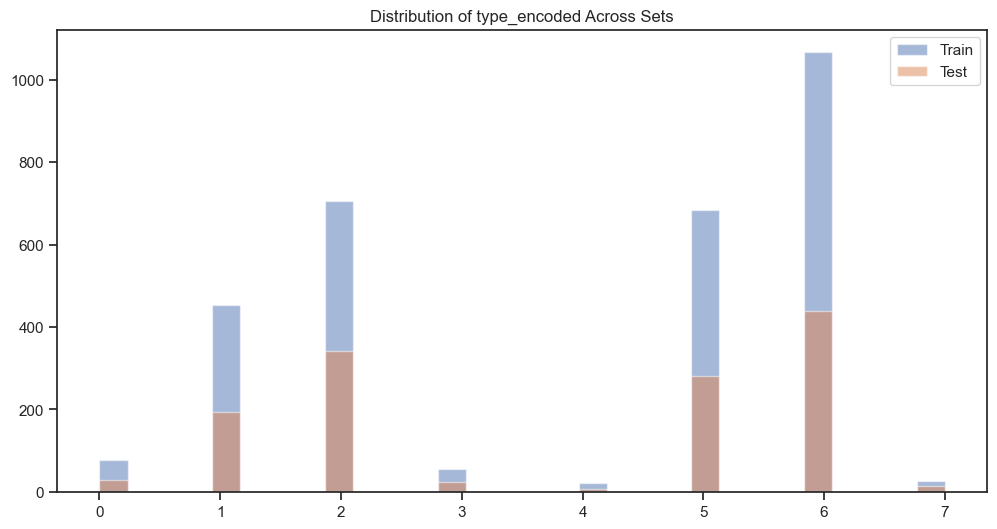

In [128]:
numerical_columns = X.select_dtypes(include='number').columns

# Check the distribution of numerical variables across sets
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.hist(X_train[column], bins=30, alpha=0.5, label='Train')
    plt.hist(X_test[column], bins=30, alpha=0.5, label='Test')
    plt.legend()
    plt.title(f'Distribution of {column} Across Sets')
    plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


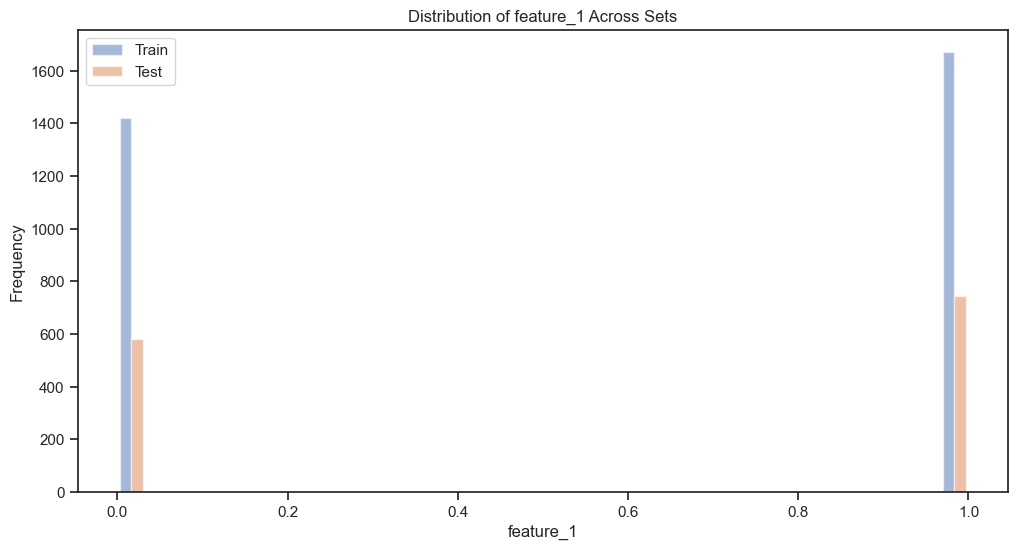

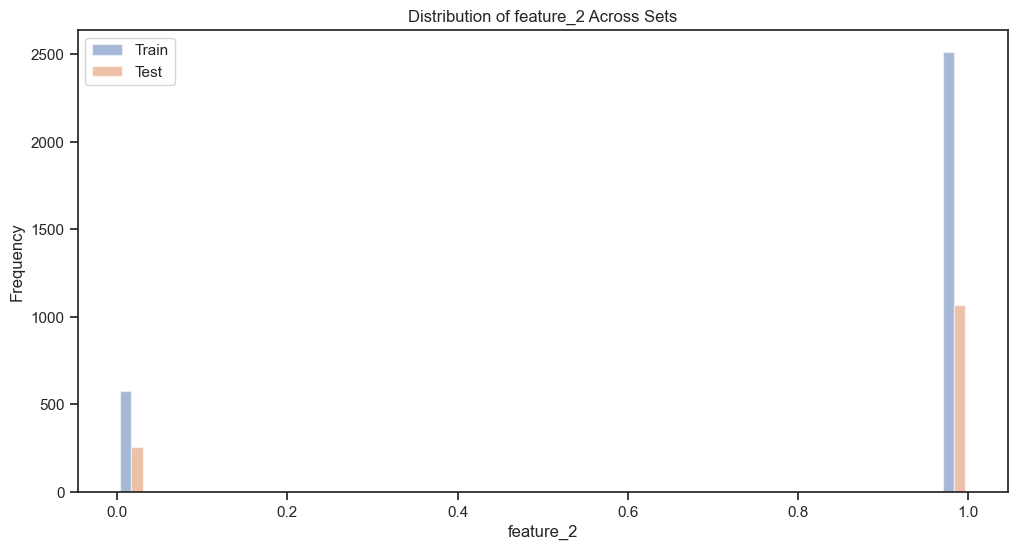

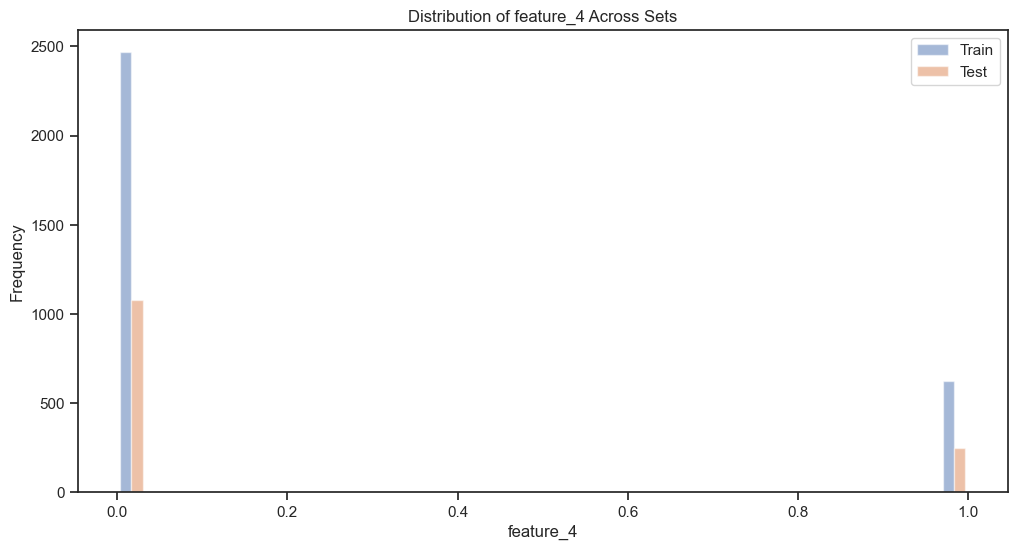

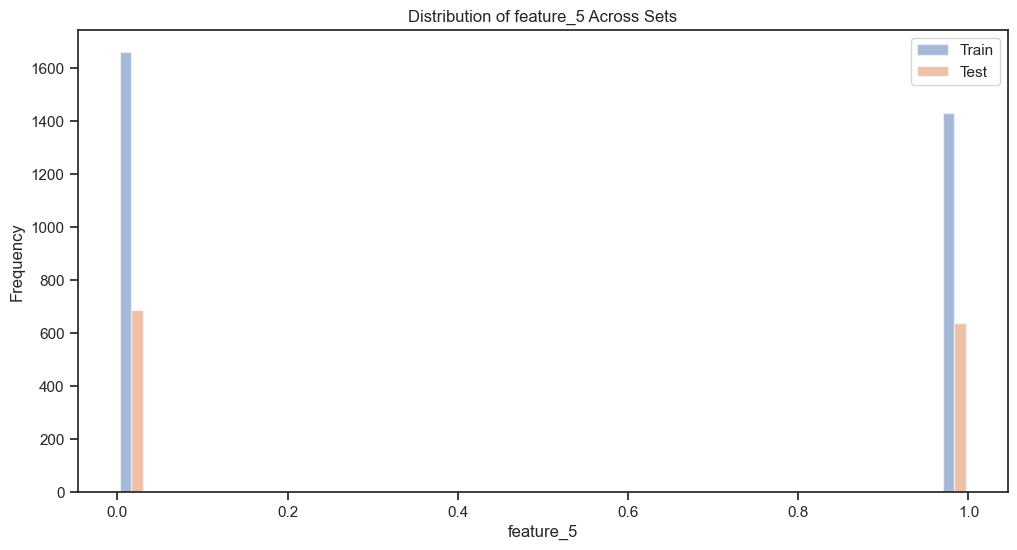

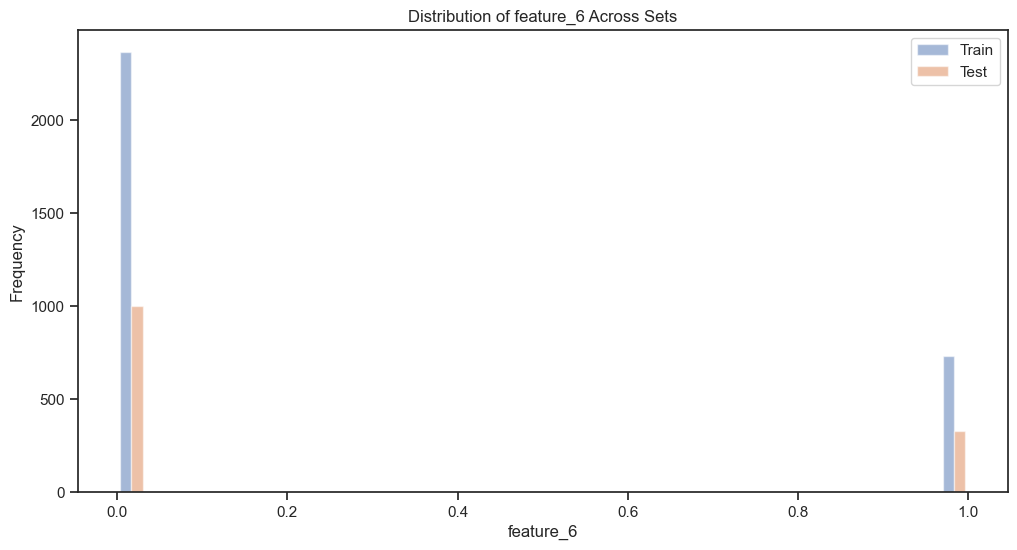

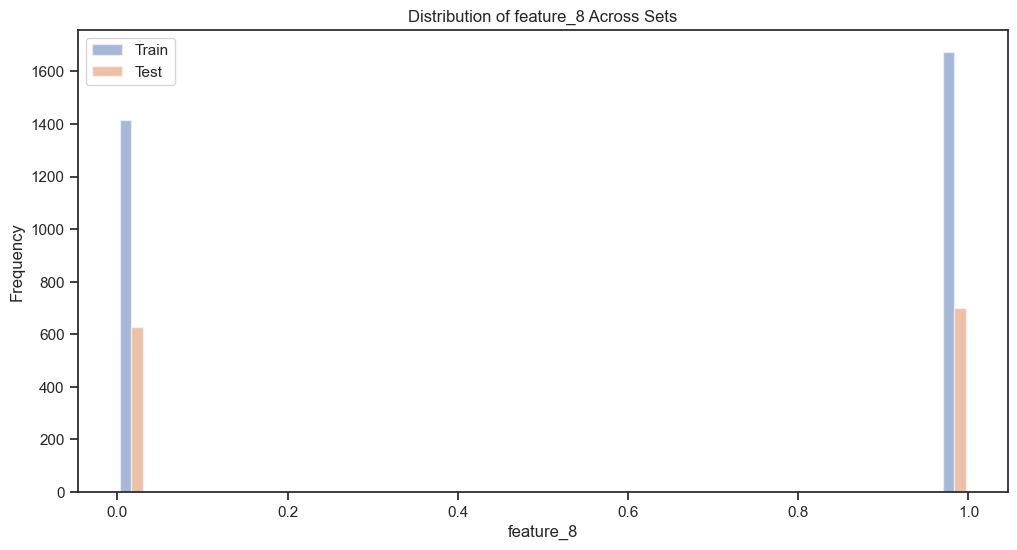

In [129]:
# Categorical variables
categorical_columns = X.select_dtypes(include='boolean').columns

for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    plt.hist([X_train[column], X_test[column]], bins=30, alpha=0.5, label=['Train', 'Test'])
    plt.legend()
    plt.title(f'Distribution of {column} Across Sets')
    plt.xlabel(f'{column}')
    plt.ylabel('Frequency')
    plt.show()

In [130]:
selected_features

Index(['mileage', 'engine_power', 'feature_1', 'feature_2', 'feature_4',
       'feature_5', 'feature_6', 'feature_8', 'first_digit', 'lifespan',
       'month_sold', 'type_encoded'],
      dtype='object')

## Baseline OLS

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1511.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:53:08   Log-Likelihood:                -29793.
No. Observations:                3091   AIC:                         5.960e+04
Df Residuals:                    3085   BIC:                         5.963e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.093e+04    259.970     42.029   

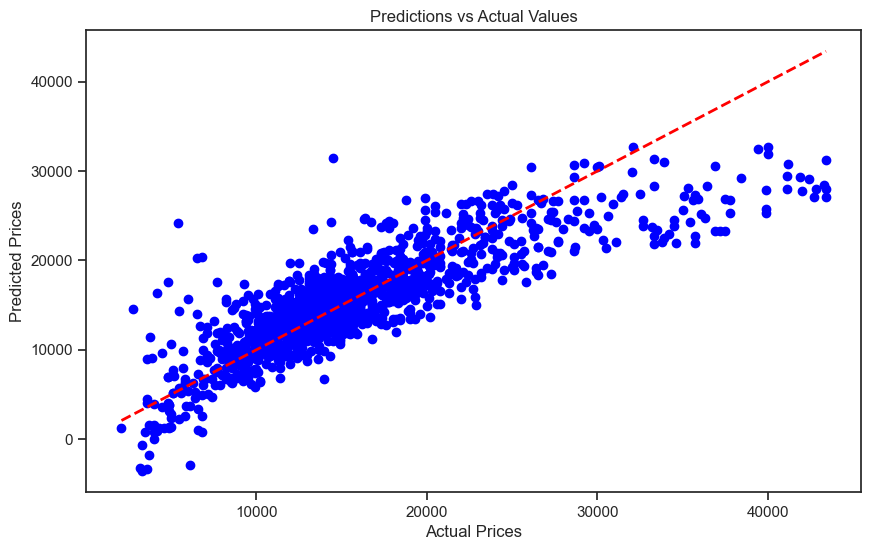

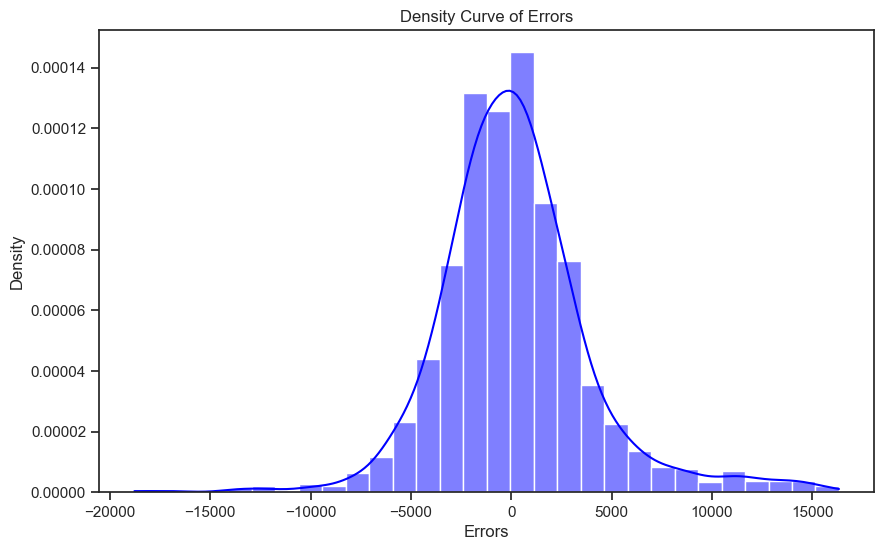

In [131]:
# Assuming X_train, X_test, y_train, y_test are your training and testing sets
nm_feat = ['mileage', 'engine_power', 'lifespan', 'month_sold', 'first_digit']
# Add a constant term to the independent variables matrix (X) for the intercept
X_trainOLS = sm.add_constant(X_train[nm_feat])
X_testOLS = sm.add_constant(X_test[nm_feat])

# Fit the OLS model on the training data
model = sm.OLS(y_train, X_trainOLS).fit()

# Make predictions on the test data
y_test_pred = model.predict(X_testOLS)

# Print the summary of the model
print(model.summary())

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Calculate the errors
errors = y_test - y_test_pred

# Plot a density curve of the errors using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='blue', stat='density')
plt.title('Density Curve of Errors')
plt.xlabel('Errors')
plt.ylabel('Density')
plt.show()

## Linear Regressor

Feature Coefficients:
         Feature  Coefficient
4      feature_4  3353.530141
1   engine_power  2467.723488
9       lifespan -2131.278879
0        mileage -1829.938748
7      feature_8  1530.632205
8    first_digit  1095.229893
6      feature_6   982.623382
2      feature_1   844.927696
5      feature_5   354.323848
11  type_encoded  -335.770405
10    month_sold   148.102727
3      feature_2    38.513804


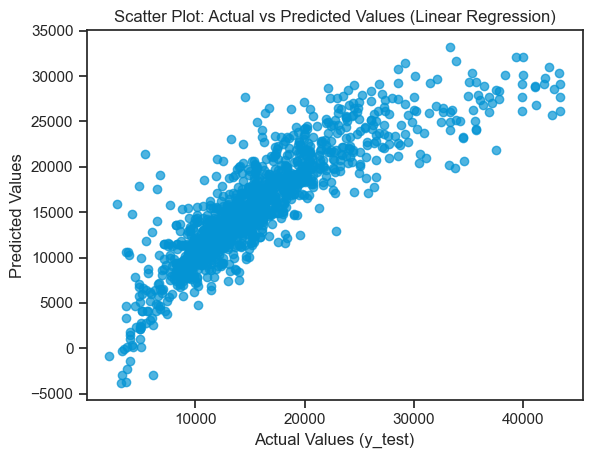

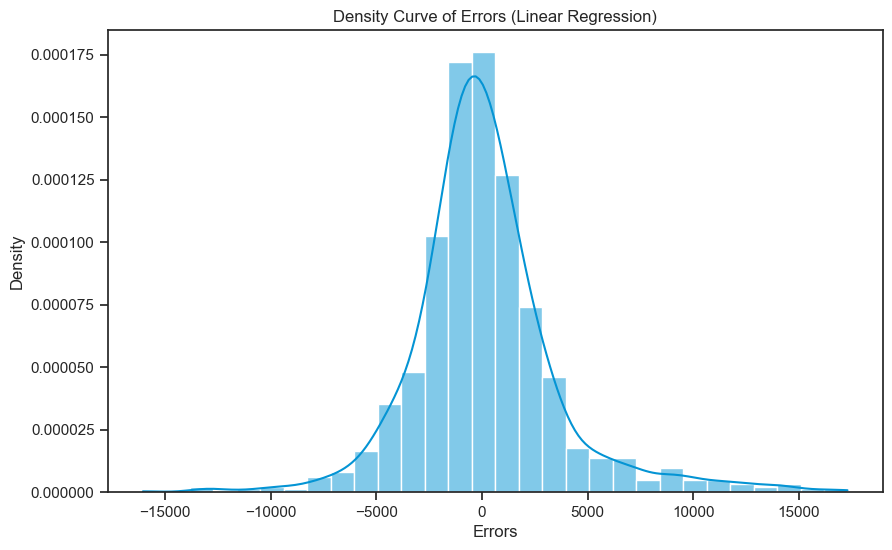

Root Mean Squared Error on test set (Linear Regression): 3502.853091545297


In [135]:
# Initialize a Linear Regressor model
model_linear = LinearRegression()

# Train the model on the entire training set
model_linear.fit(X_train, y_train)

# Get coefficients from the model
coefficients = model_linear.coef_

# Create a DataFrame to display feature coefficients
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Display the feature coefficients
print("Feature Coefficients:")
print(coefficients_df)

# Make predictions on the test set
y_test_pred_linear = model_linear.predict(X_test)

# Plot a scatter plot between predicted and actual values
plt.scatter(y_test, y_test_pred_linear,color='#0494d4',alpha=0.7)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values (Linear Regression)')
plt.show()

# Calculate the errors
errors_linear = y_test - y_test_pred_linear

# Plot a density curve of the errors using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(errors_linear, kde=True, bins=30, color='#0494d4', stat='density')
plt.title('Density Curve of Errors (Linear Regression)')
plt.xlabel('Errors')
plt.ylabel('Density')
plt.show()

# Evaluate the model on the test set
rmse_test_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))
print(f'Root Mean Squared Error on test set (Linear Regression): {rmse_test_linear}')

## Random Forests


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters:
{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Feature Importances:
         Feature  Importance
1   engine_power    0.415110
9       lifespan    0.211348
0        mileage    0.097426
8    first_digit    0.077355
11  type_encoded    0.067550
7      feature_8    0.055457
4      feature_4    0.028654
5      feature_5    0.017027
10    month_sold    0.013330
6      feature_6    0.007259
2      feature_1    0.005374
3      feature_2    0.004109


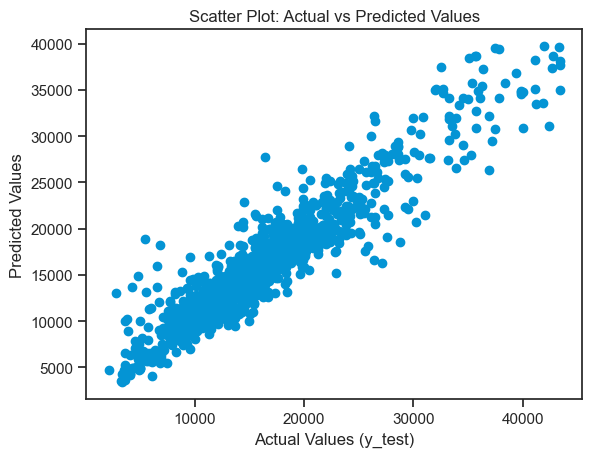

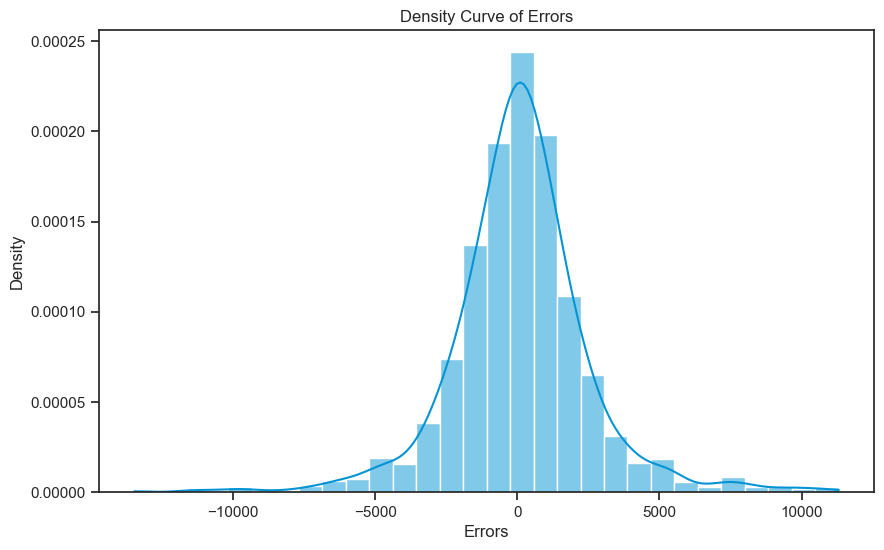

Root Mean Squared Error on test set: 2441.430926920533


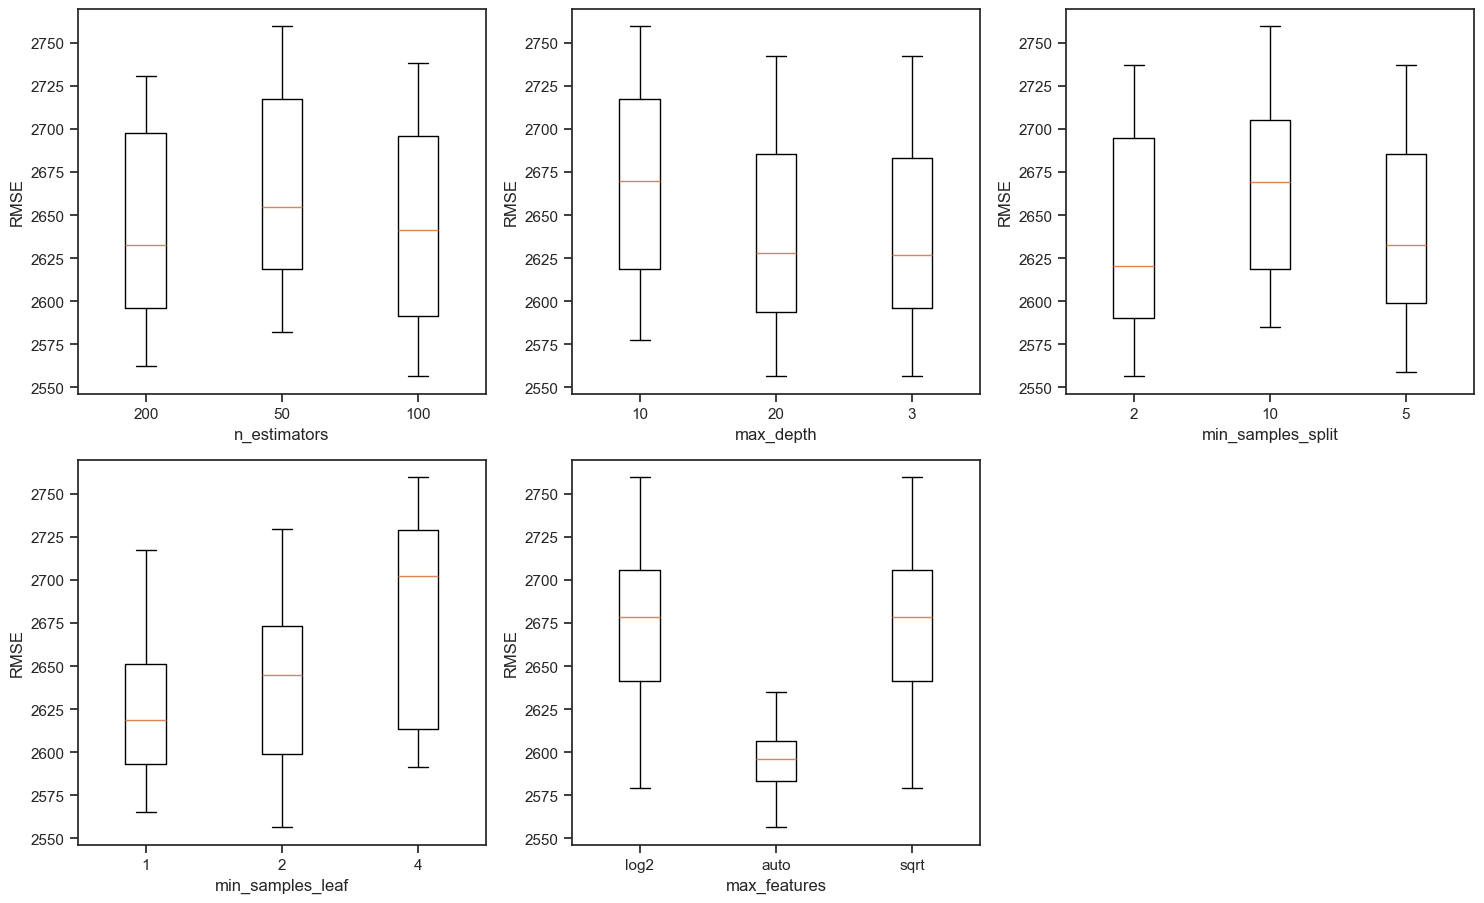

In [136]:
# Initialize a Random Forest Regressor model
model = RandomForestRegressor(random_state=33)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None,10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

"""param_grid = {'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

"""
# Use Grid Search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Train the model on the entire training set using the best hyperparameters
best_modelrf = RandomForestRegressor(random_state=42, **best_params)
best_modelrf.fit(X_train, y_train)

# Get feature importances from the model
feature_importances = best_modelrf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

# Make predictions on the test set
y_test_pred = best_modelrf.predict(X_test)

# Plot a scatter plot between predicted and actual values
plt.scatter(y_test, y_test_pred,color="#0494d4")
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values')
plt.show()
# Calculate the errors
errors = y_test - y_test_pred

# Plot a density curve of the errors using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='#0494d4', stat='density')
plt.title('Density Curve of Errors')
plt.xlabel('Errors')
plt.ylabel('Density')
plt.show()

# Evaluate the model on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Root Mean Squared Error on test set: {rmse_test}')
      
plot_hyperparameter_boxplots(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params'], param_grid)

In [144]:
best_params

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

# Xgboost regressor

In [133]:
# Initialize an XGBoost Regressor model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.1,1],
    'max_depth': [5,10],
    'subsample': [0.8],
    'colsample_bytree': [ 0.8]
}
# Use Grid Search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Train the model on the entire training set using the best hyperparameters
best_modelxgb = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_modelxgb.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = best_modelxgb.predict(X_test)

# Plot a scatter plot between predicted and actual values
plt.scatter(y_test, y_test_pred,color='#0494d4')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values')
plt.show()
# Calculate the errors
errors = y_test - y_test_pred

# Plot a density curve of the errors using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='#0494d4', stat='density')
plt.title('Density Curve of Errors')
plt.xlabel('Errors')
plt.ylabel('Density')
plt.show()
# Evaluate the model on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Root Mean Squared Error on test set: {rmse_test}')
plot_hyperparameter_boxplots(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params'], param_grid)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\PORTATIL\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PORTATIL\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PORTATIL\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 373, in fit
    self._Booster = train(params, trainDmatrix,
  File "C:\Users\PORTATIL\Anaconda3\lib\site-packages\xgboost\training.py", line 212, in train
    return _train_internal(params, dtrain,
  File "C:\Users\PORTATIL\

XGBoostError: b'[13:53:49] C:\\Users\\Administrator\\Desktop\\xgboost\\src\\objective\\objective.cc:23: Unknown objective function reg:squarederror'

In [117]:
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'subsample': 0.8}

## 8. Seasonality

Text(0.5, 1.0, 'How does the value of a car change over time')

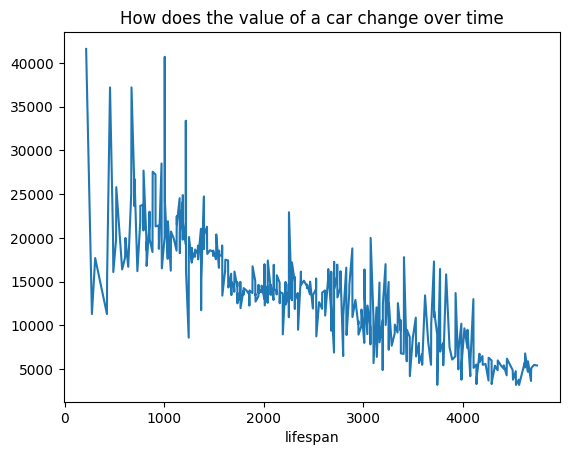

In [261]:
# Assuming df is your DataFrame
time_analysis = cleaned_df.groupby('lifespan')['price'].mean()
# or use 'month_sold' instead of 'lifespan' if it makes more sense for your data

# Plot the time series data for better visualization
time_analysis.plot(x='lifespan', y='price', kind='line')
plt.title('How does the value of a car change over time')

In [262]:
cleaned_df

mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
0      140411           100       True       True      False      False   
2      183297           120      False      False      False      False   
3      128035           135       True       True      False      False   
4       97097           160       True       True      False      False   
6      205219           145       True       True      False      False   
...       ...           ...        ...        ...        ...        ...   
4838    39743           110      False       True      False      False   
4839    49832           100      False       True      False      False   
4840    19633           110      False       True      False      False   
4841    27920           110       True       True      False      False   
4842   195840           160       True       True      False      False   

      feature_5  feature_6  feature_7  feature_8  ...  color__beige  \
0          True       True       True      False  ...         False   
2          True      False       True      False  ...         False   
3          True       True       True       True  ...         False   
4         False       True       True       True  ...         False   
6          True       True       True       True  ...         False   
...         ...        ...        ...        ...  ...           ...   
4838      False      False       True      False  ...         False   
4839      False      False       True       True  ...         False   
4840      False      False       True       True  ...         False   
4841      False      False       True       True  ...         False   
4842       True      False       True       True  ...         False   

      color__black  color__blue  color__brown  color__green  color__grey  \
0             True        False         False         False        False   
2            False        False         False         False        False   
3            False        False         False         False        False   
4            False        False         False         False        False   
6            False        False         False         False         True   
...            ...          ...           ...           ...          ...   
4838          True        False         False         False        False   
4839         False        False         False         False         True   
4840         False        False         False         False         True   
4841         False        False          True         False        False   
4842         False        False         False         False         True   

      color__orange  color__red  color__silver  color__white  
0             False       False          False         False  
2             False       False          False          True  
3             False        True          False         False  
4             False       False           True         False  
6             False       False          False         False  
...             ...         ...            ...           ...  
4838          False       False          False         False  
4839          False       False          False         False  
4840          False       False          False         False  
4841          False       False          False         False  
4842          False       False          False         False  

[4448 rows x 26 columns]


Repeated Measures ANOVA Results for feature_1:
F-statistic: 414.128078587406
P-value: 4.26464033830527e-88
The difference in mean prices is statistically significant for feature_1.


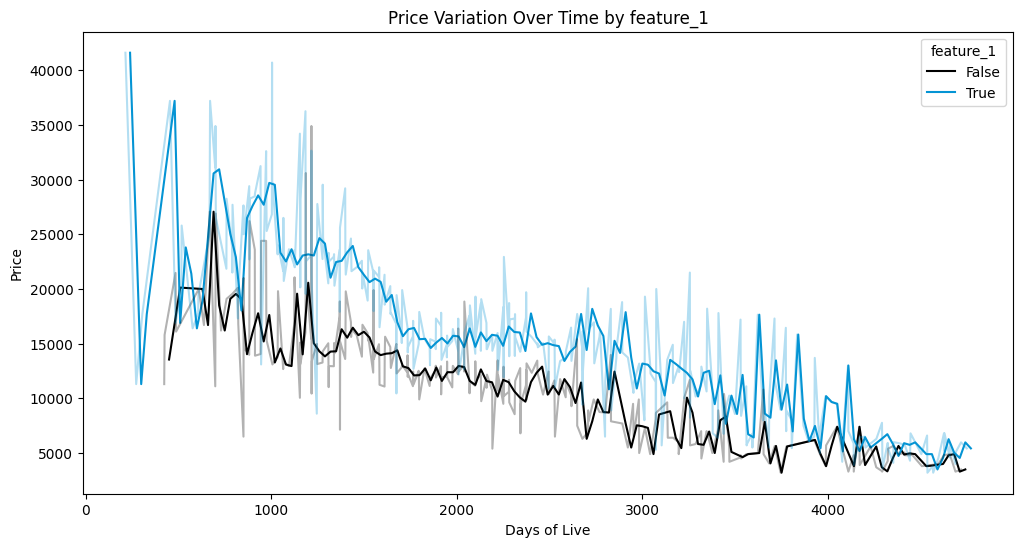


Repeated Measures ANOVA Results for feature_2:
F-statistic: 269.296765631136
P-value: 8.38498949816534e-59
The difference in mean prices is statistically significant for feature_2.


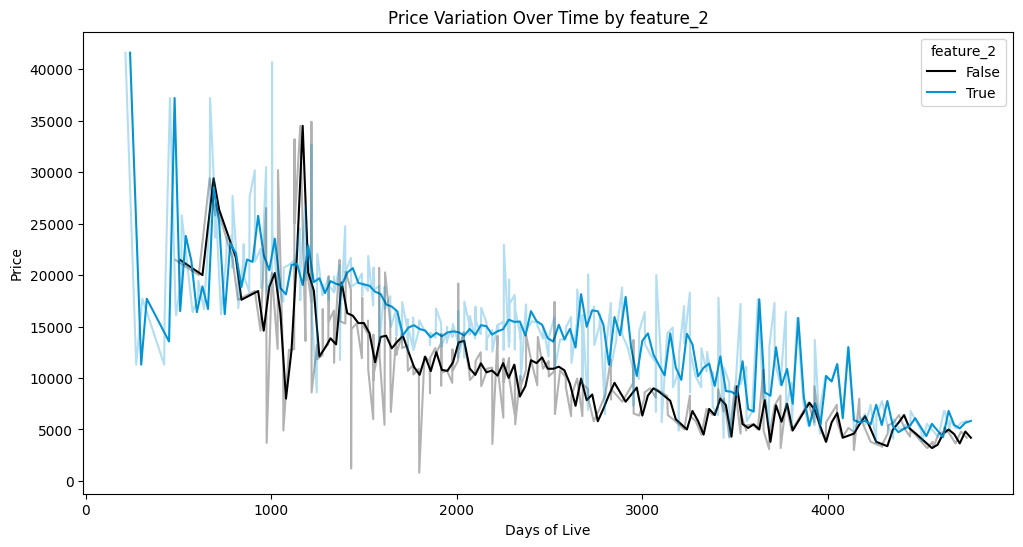


Repeated Measures ANOVA Results for feature_3:
F-statistic: 296.48774898032565
P-value: 2.2530077976404845e-64
The difference in mean prices is statistically significant for feature_3.


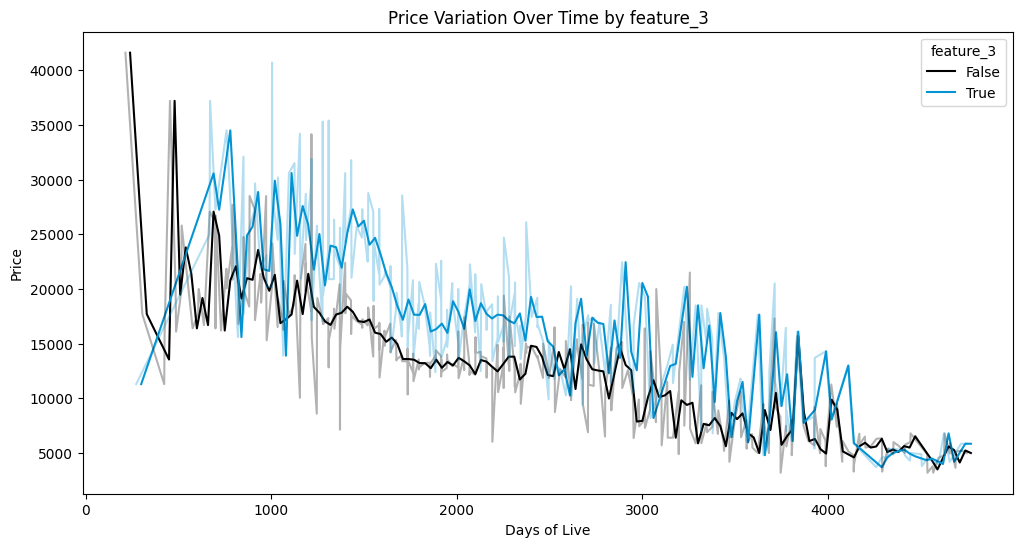


Repeated Measures ANOVA Results for feature_4:
F-statistic: 1099.3106795420154
P-value: 1.3116203255653353e-215
The difference in mean prices is statistically significant for feature_4.


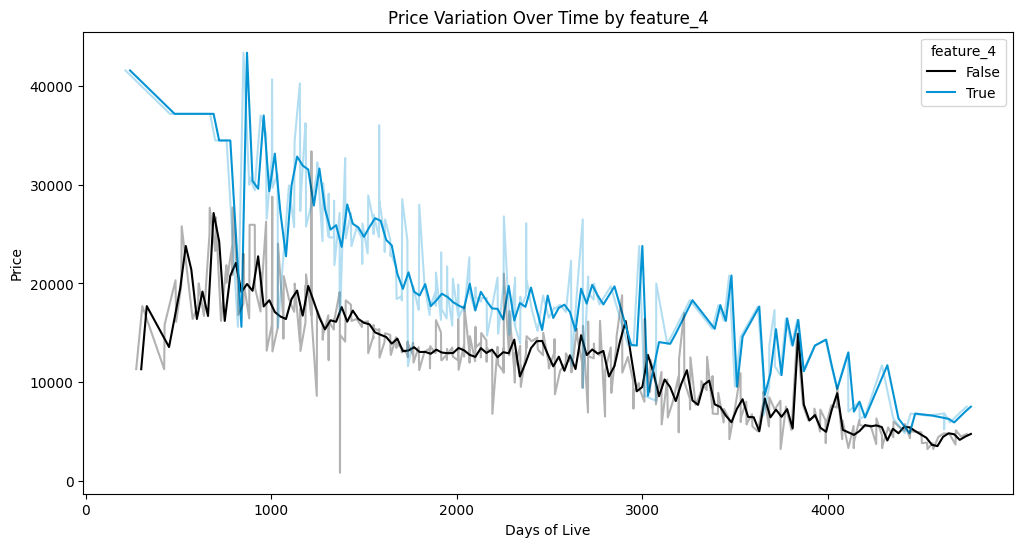


Repeated Measures ANOVA Results for feature_5:
F-statistic: 690.1058770300187
P-value: 1.621656072561714e-141
The difference in mean prices is statistically significant for feature_5.


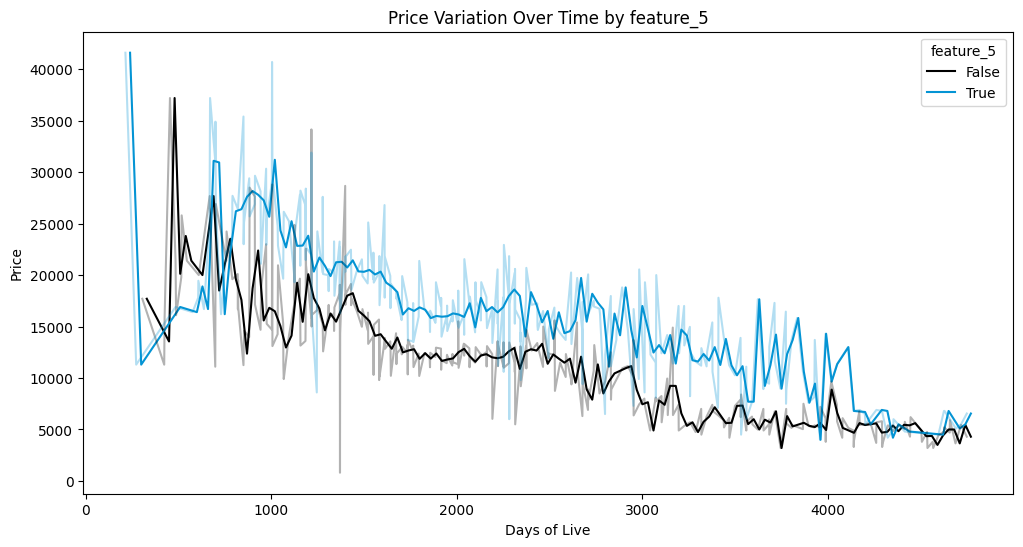


Repeated Measures ANOVA Results for feature_6:
F-statistic: 233.80223304790562
P-value: 1.7666715213203865e-51
The difference in mean prices is statistically significant for feature_6.


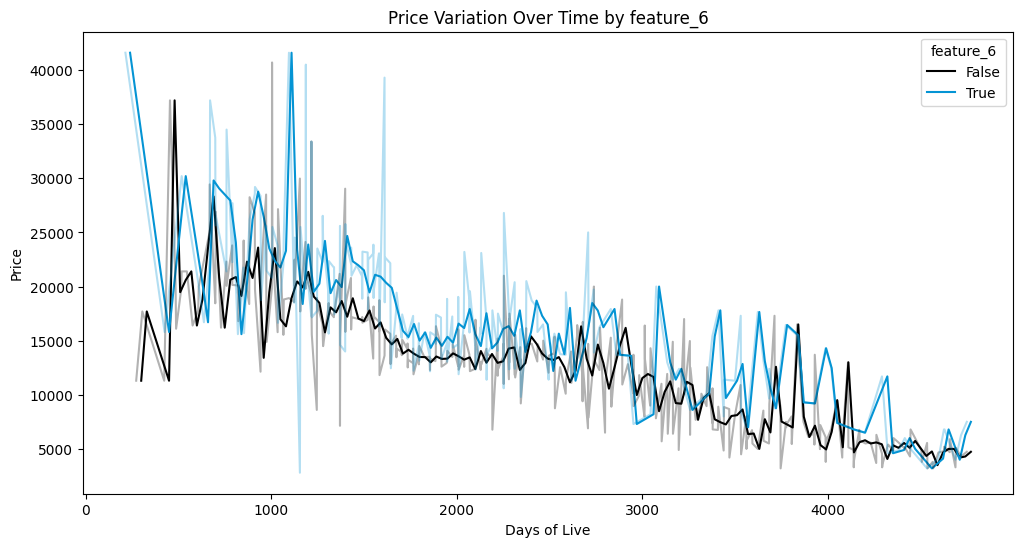


Repeated Measures ANOVA Results for feature_7:
F-statistic: 0.2790311667870787
P-value: 0.5973632924952235
There is no significant difference in mean prices for feature_7.


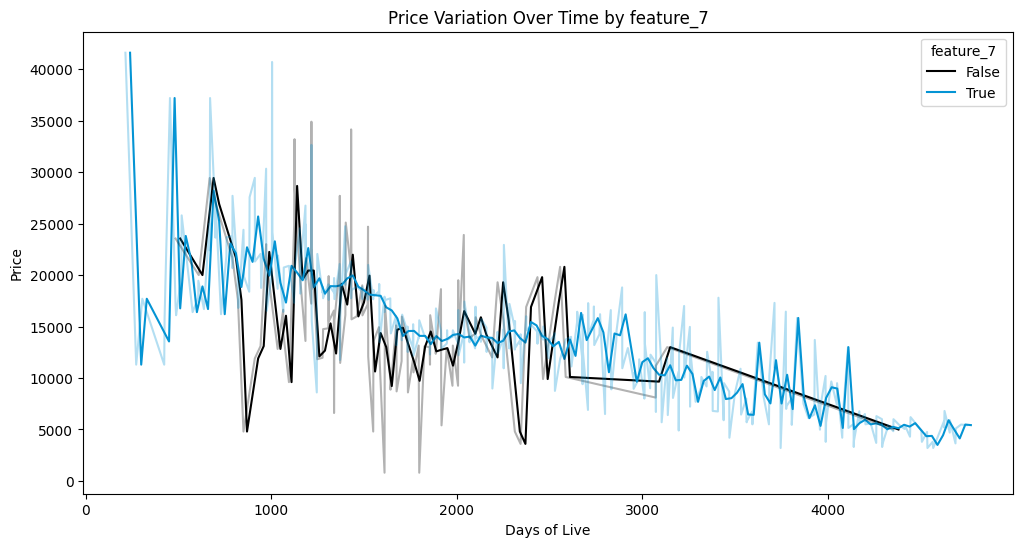


Repeated Measures ANOVA Results for feature_8:
F-statistic: 1399.7251099568268
P-value: 1.3879886805251266e-266
The difference in mean prices is statistically significant for feature_8.


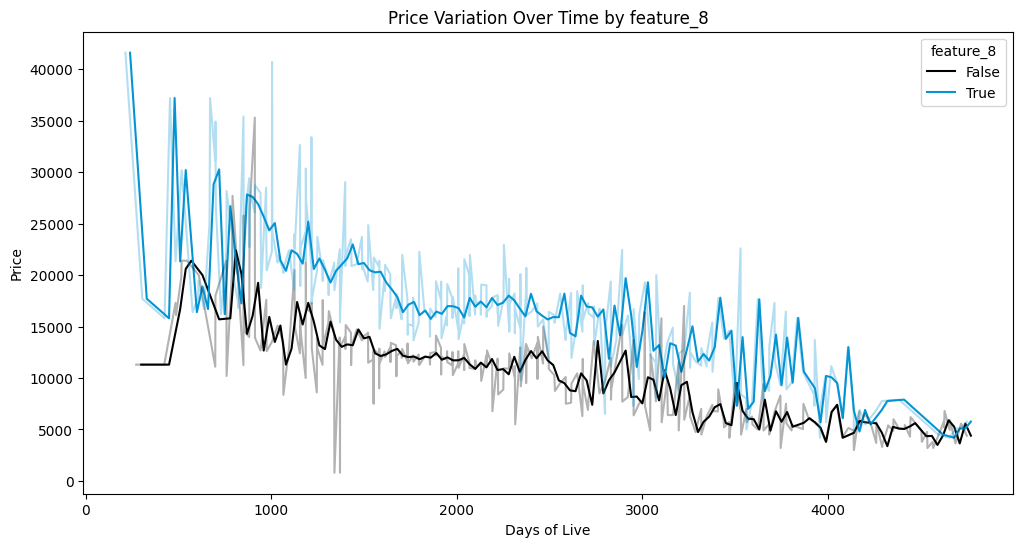


Repeated Measures ANOVA Results for color__beige:
F-statistic: 0.07258530459013958
P-value: 0.7876216153530838
There is no significant difference in mean prices for color__beige.


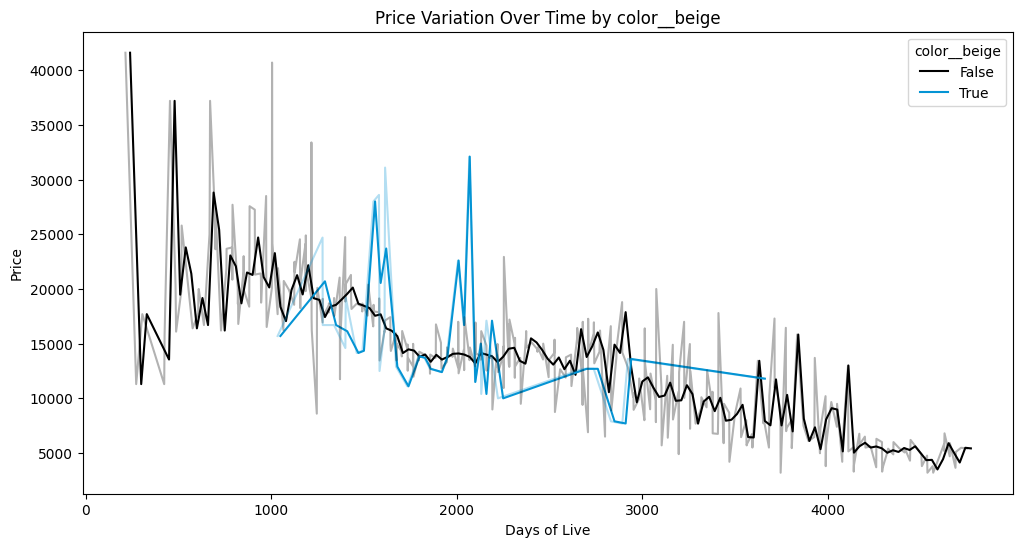


Repeated Measures ANOVA Results for color__black:
F-statistic: 6.590072611882398
P-value: 0.010287322634693974
The difference in mean prices is statistically significant for color__black.


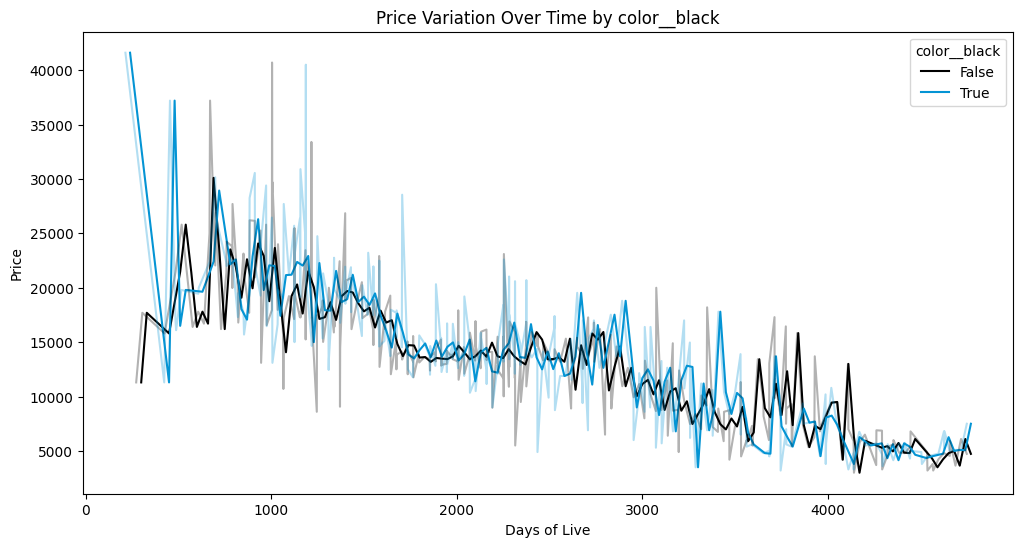


Repeated Measures ANOVA Results for color__blue:
F-statistic: 8.290849285088438
P-value: 0.004003565369010115
The difference in mean prices is statistically significant for color__blue.


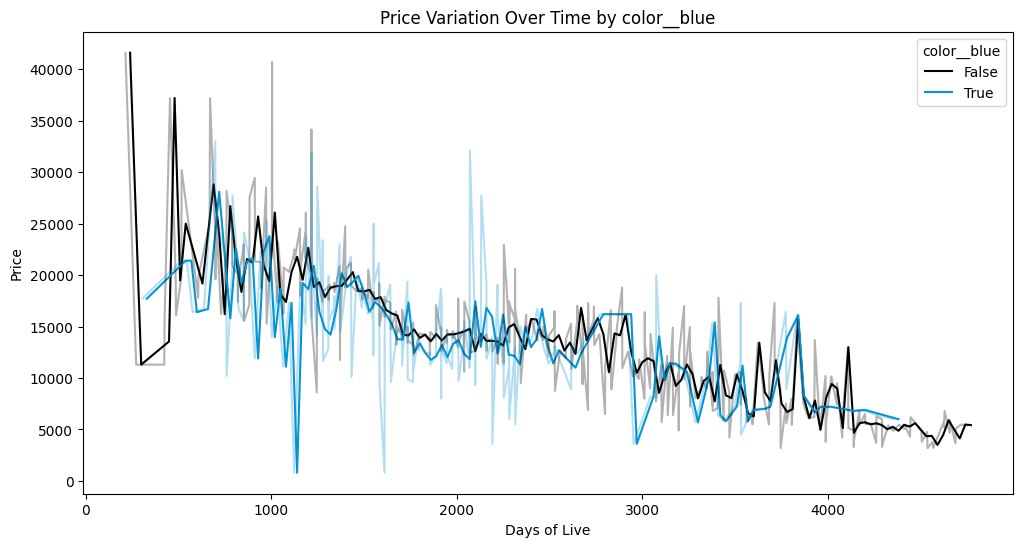


Repeated Measures ANOVA Results for color__brown:
F-statistic: 0.6962651831804327
P-value: 0.40408633071739586
There is no significant difference in mean prices for color__brown.


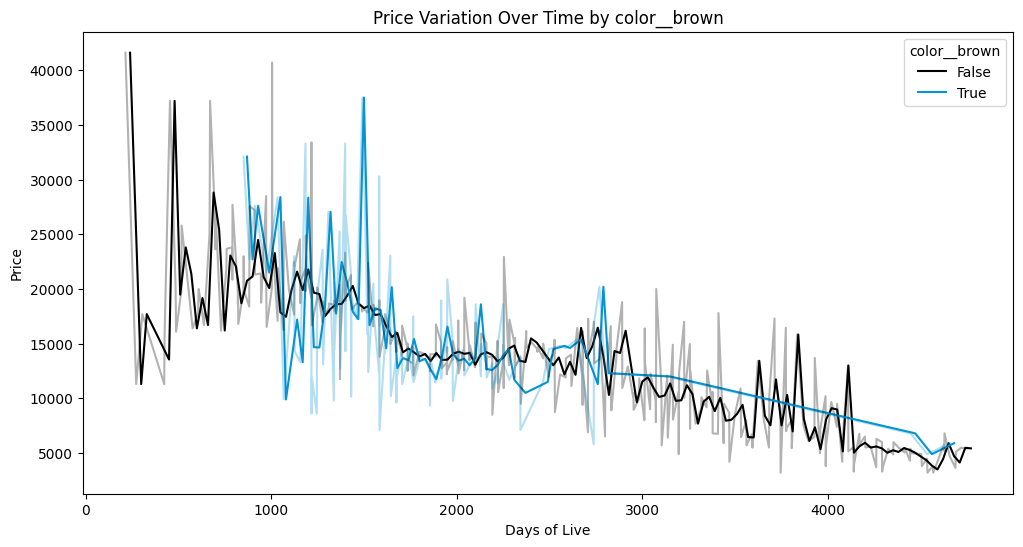


Repeated Measures ANOVA Results for color__green:
F-statistic: 8.145002499151994
P-value: 0.004337969217615783
The difference in mean prices is statistically significant for color__green.


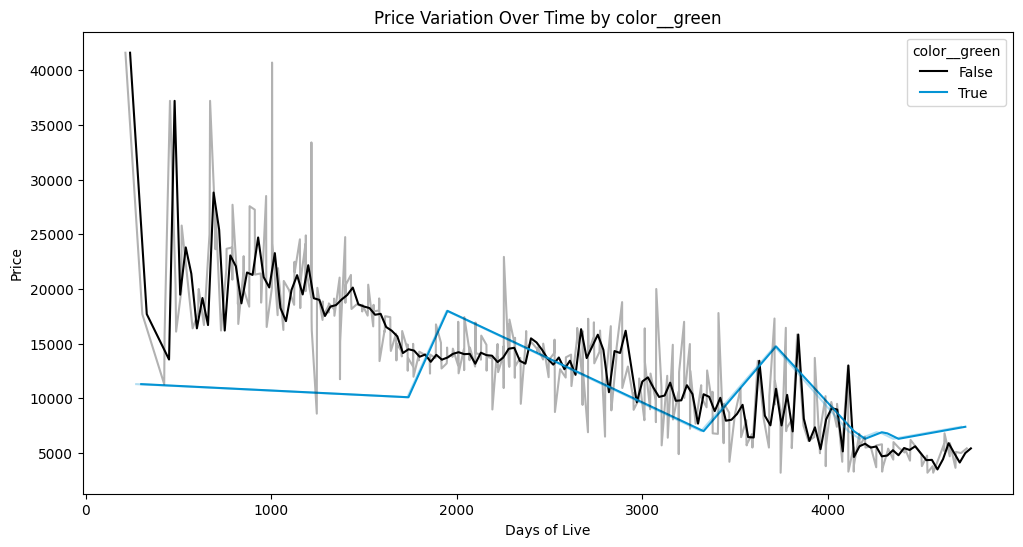


Repeated Measures ANOVA Results for color__grey:
F-statistic: 2.7229571404617485
P-value: 0.09898524376757668
There is no significant difference in mean prices for color__grey.


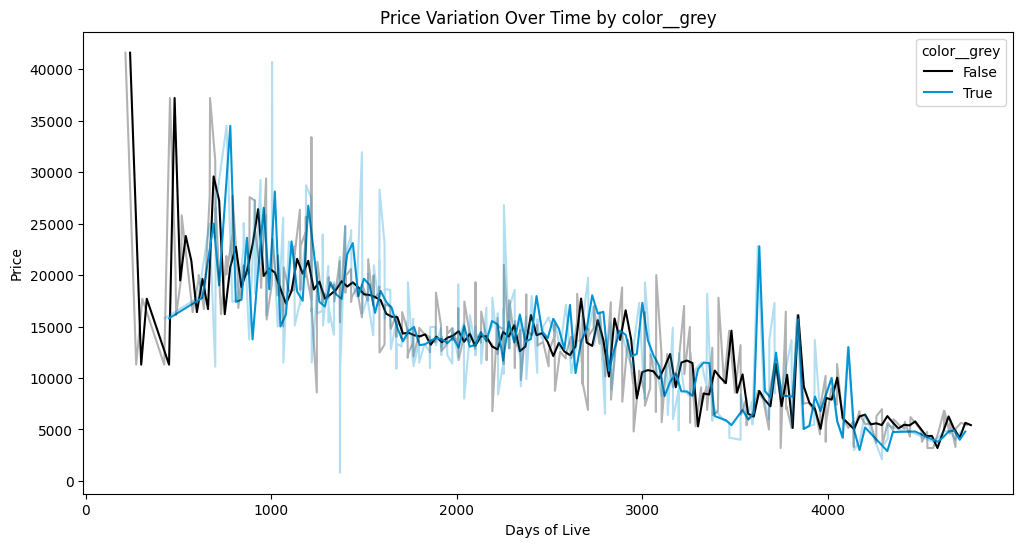


Repeated Measures ANOVA Results for color__orange:
F-statistic: 0.9135518929174707
P-value: 0.33922571608305885
There is no significant difference in mean prices for color__orange.


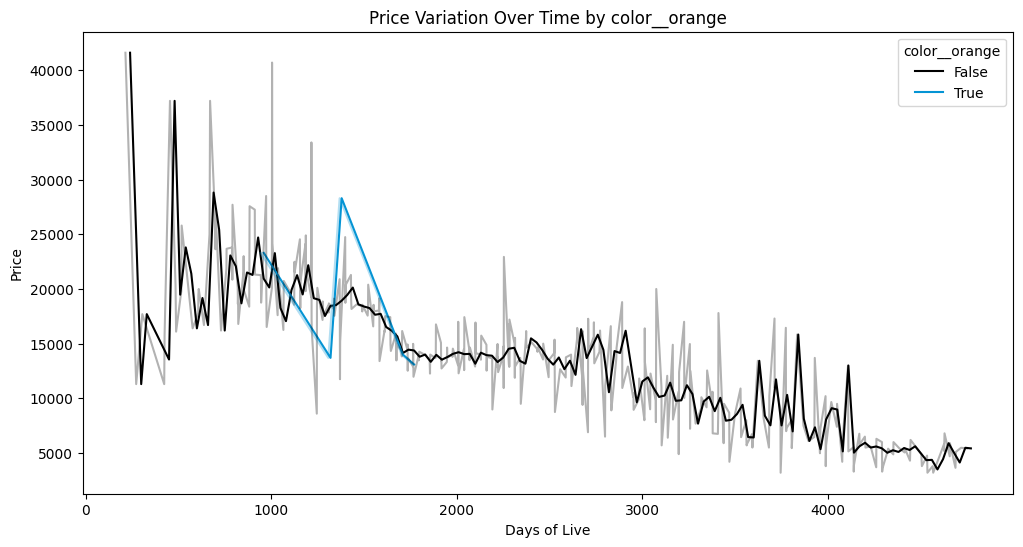


Repeated Measures ANOVA Results for color__red:
F-statistic: 0.1028354557212528
P-value: 0.748468220634492
There is no significant difference in mean prices for color__red.


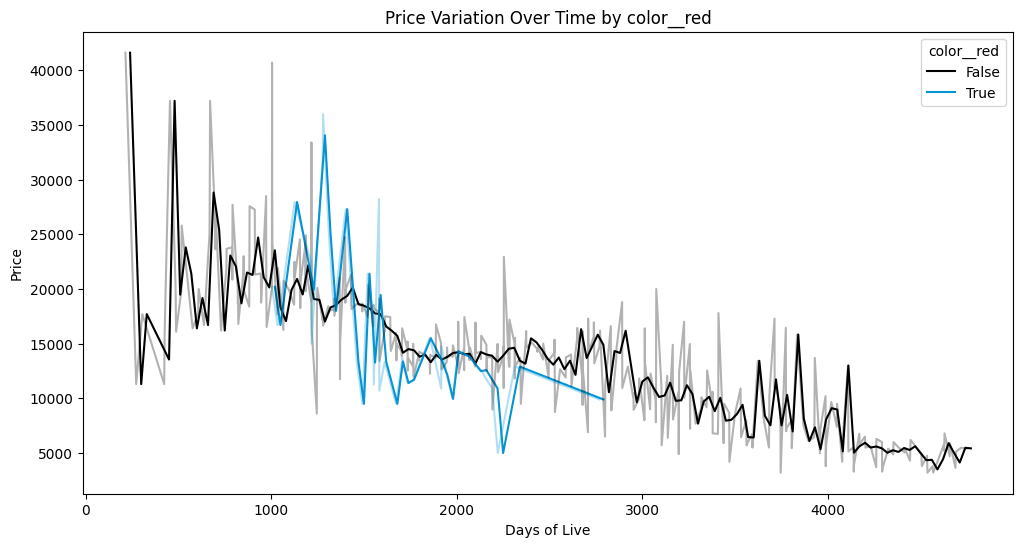


Repeated Measures ANOVA Results for color__silver:
F-statistic: 0.9838188916747553
P-value: 0.3213117759389976
There is no significant difference in mean prices for color__silver.


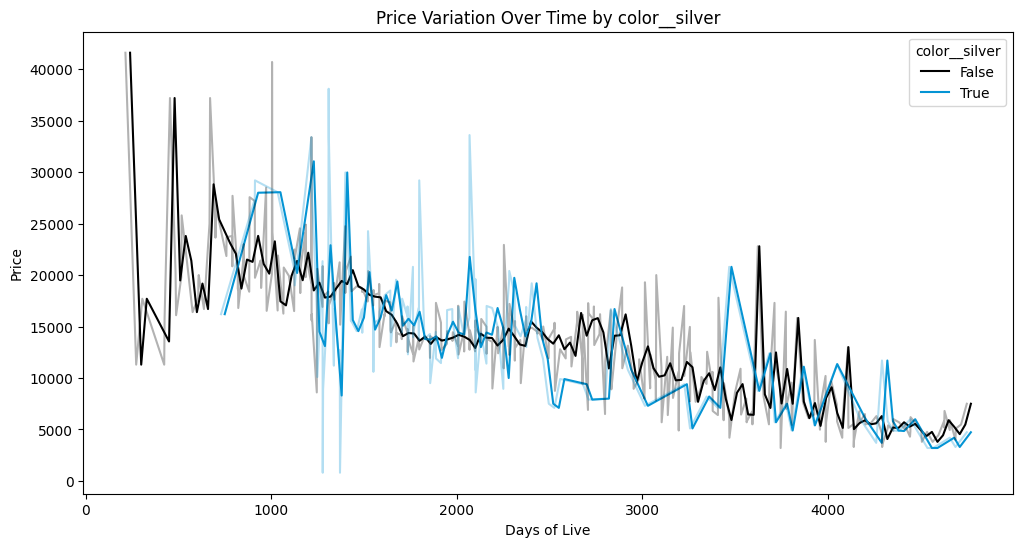


Repeated Measures ANOVA Results for color__white:
F-statistic: 10.677541482313101
P-value: 0.0010926799015731129
The difference in mean prices is statistically significant for color__white.


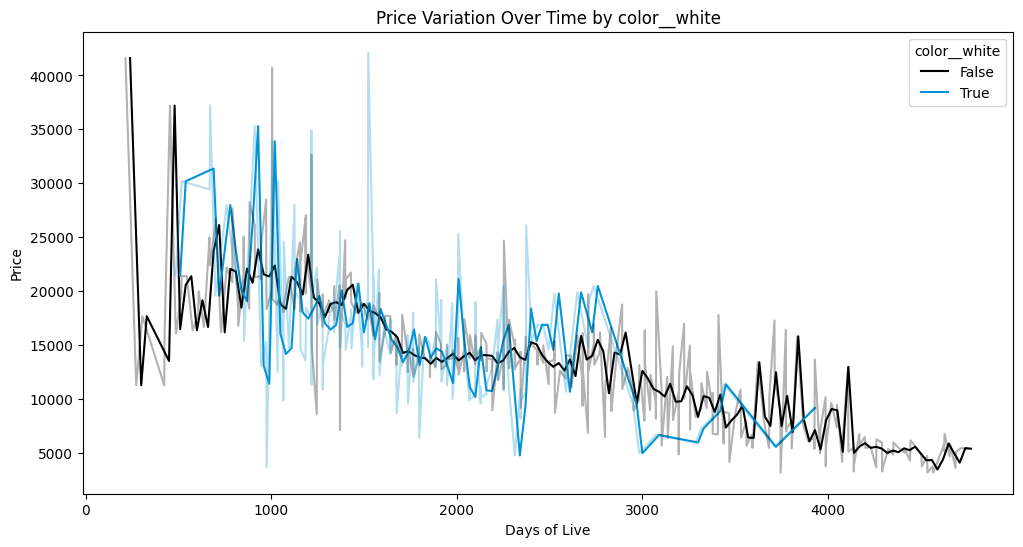

In [272]:

# Assuming df is your DataFrame
# Replace 'color', 'price_range', and 'features' with the actual column names of your categorical features
categorical_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
                       'color__beige', 'color__black', 'color__blue','color__brown', 'color__green', 'color__grey', 'color__orange',
                        'color__red', 'color__silver', 'color__white']

cleaned_df['months_lived'] = ((cleaned_df['lifespan'] // 30) + 1)*30
line_colors = ['black', '#0494d4']
# Iterate through each categorical feature
for categorical_feature in categorical_features:
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(data=cleaned_df, x='months_lived', y='price', hue=categorical_feature, ci=None, legend=False,palette=line_colors)
    
    # Create a line plot for each category within the feature
    sns.lineplot(data=cleaned_df, x='lifespan', y='price', hue=categorical_feature, ci=None, alpha=0.3,palette=line_colors)
    
    plt.title(f'Price Variation Over Time by {categorical_feature}')
    plt.xlabel('Days of Live')  
    plt.ylabel('Price')         
    
    # Perform repeated measures ANOVA
    category_data = []
    for category in cleaned_df[categorical_feature].unique():
        category_data.append(cleaned_df[cleaned_df[categorical_feature] == category]['price'])
    
    f_statistic, p_value = f_oneway(*category_data)
    
    # Print ANOVA results
    print(f'\nRepeated Measures ANOVA Results for {categorical_feature}:')
    print(f'F-statistic: {f_statistic}')
    print(f'P-value: {p_value}')

    # Check the significance level (e.g., 0.05) to determine statistical significance
    if p_value < 0.05:
        print(f'The difference in mean prices is statistically significant for {categorical_feature}.')
    else:
        print(f'There is no significant difference in mean prices for {categorical_feature}.')

    plt.show()

In [269]:
cleaned_df

mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
0      140411           100       True       True      False      False   
2      183297           120      False      False      False      False   
3      128035           135       True       True      False      False   
4       97097           160       True       True      False      False   
6      205219           145       True       True      False      False   
...       ...           ...        ...        ...        ...        ...   
4838    39743           110      False       True      False      False   
4839    49832           100      False       True      False      False   
4840    19633           110      False       True      False      False   
4841    27920           110       True       True      False      False   
4842   195840           160       True       True      False      False   

      feature_5  feature_6  feature_7  feature_8  ...  color__black  \
0          True       True       True      False  ...          True   
2          True      False       True      False  ...         False   
3          True       True       True       True  ...         False   
4         False       True       True       True  ...         False   
6          True       True       True       True  ...         False   
...         ...        ...        ...        ...  ...           ...   
4838      False      False       True      False  ...          True   
4839      False      False       True       True  ...         False   
4840      False      False       True       True  ...         False   
4841      False      False       True       True  ...         False   
4842       True      False       True       True  ...         False   

      color__blue  color__brown  color__green  color__grey  color__orange  \
0           False         False         False        False          False   
2           False         False         False        False          False   
3           False         False         False        False          False   
4           False         False         False        False          False   
6           False         False         False         True          False   
...           ...           ...           ...          ...            ...   
4838        False         False         False        False          False   
4839        False         False         False         True          False   
4840        False         False         False         True          False   
4841        False          True         False        False          False   
4842        False         False         False         True          False   

      color__red  color__silver  color__white  months_lived  
0          False          False         False            73  
2          False          False          True            72  
3           True          False         False            44  
4          False           True         False            41  
6          False          False         False           107  
...          ...            ...           ...           ...  
4838       False          False         False            35  
4839       False          False         False            39  
4840       False          False         False            36  
4841       False          False         False            30  
4842       False          False         False            69  

[4448 rows x 27 columns]


Repeated Measures ANOVA Results for feature_1:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_1.


at least one input has length 0


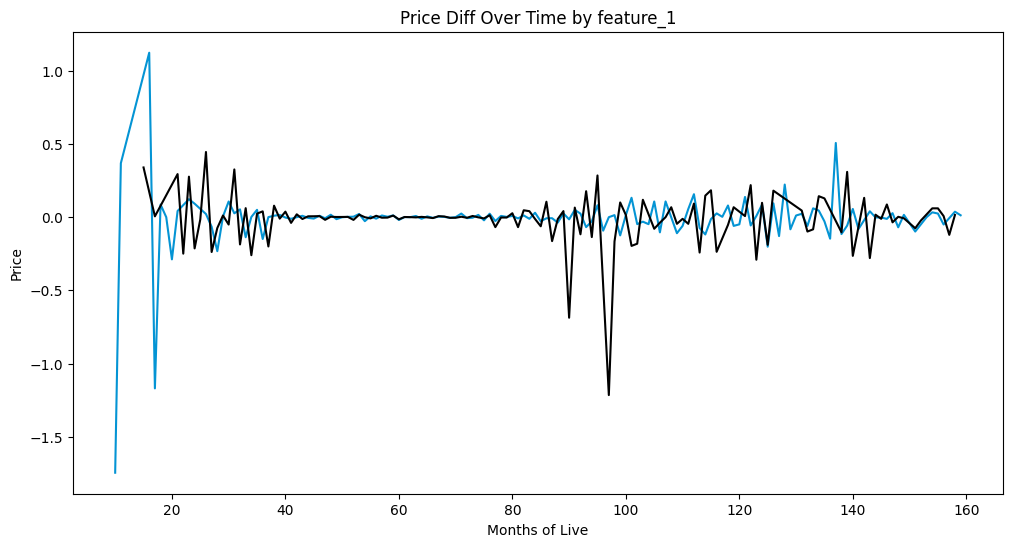

at least one input has length 0



Repeated Measures ANOVA Results for feature_2:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_2.


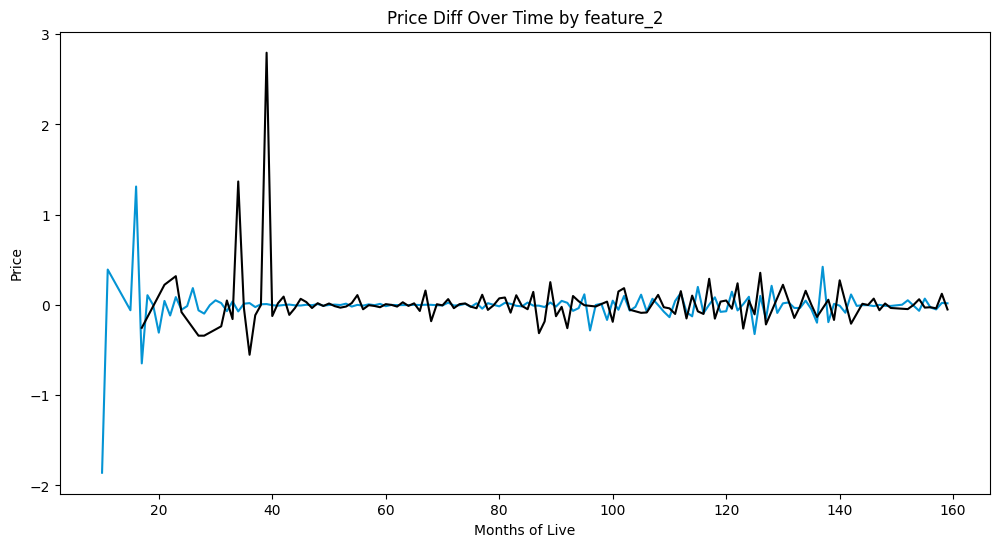


Repeated Measures ANOVA Results for feature_3:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_3.


at least one input has length 0


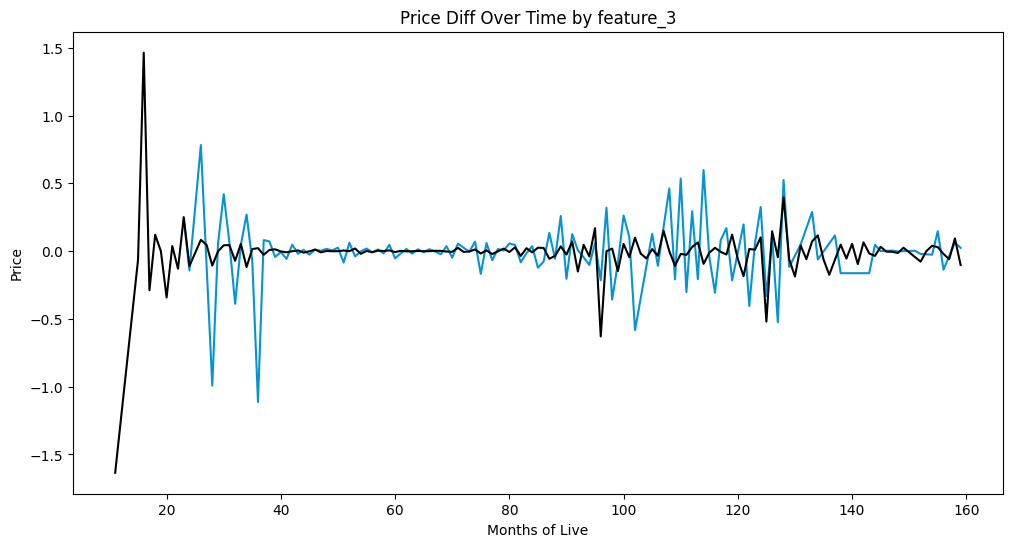


Repeated Measures ANOVA Results for feature_4:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_4.


at least one input has length 0


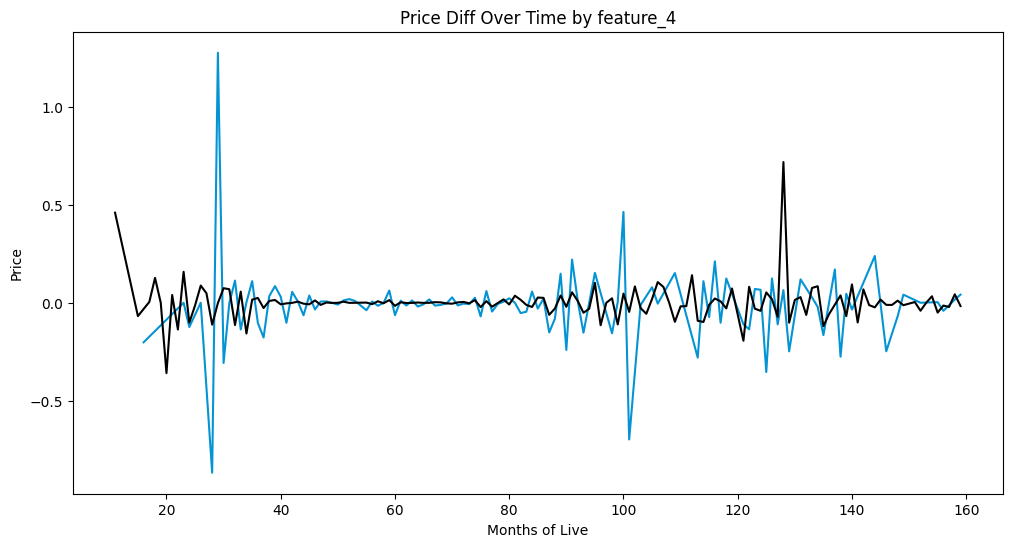


Repeated Measures ANOVA Results for feature_5:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_5.


at least one input has length 0


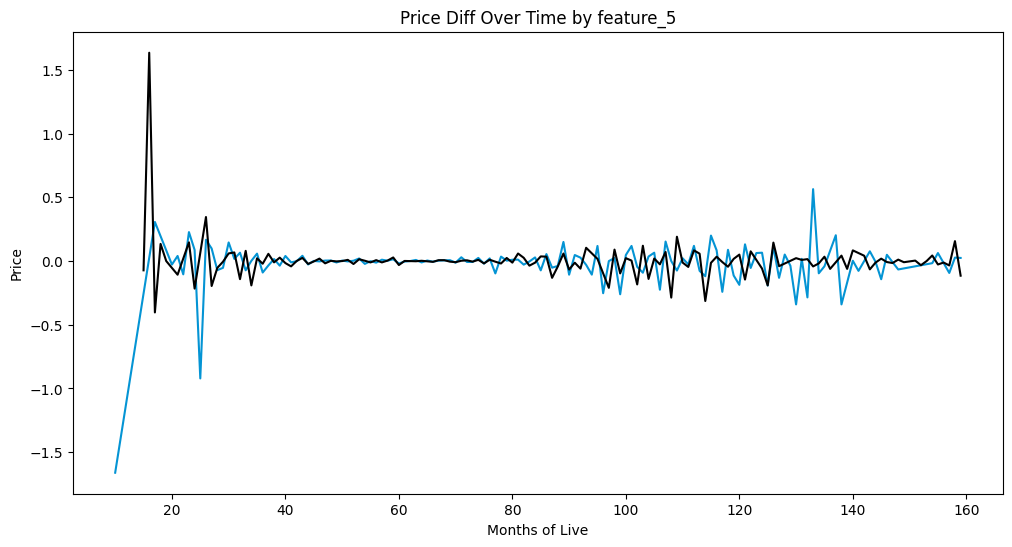


Repeated Measures ANOVA Results for feature_6:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_6.


at least one input has length 0


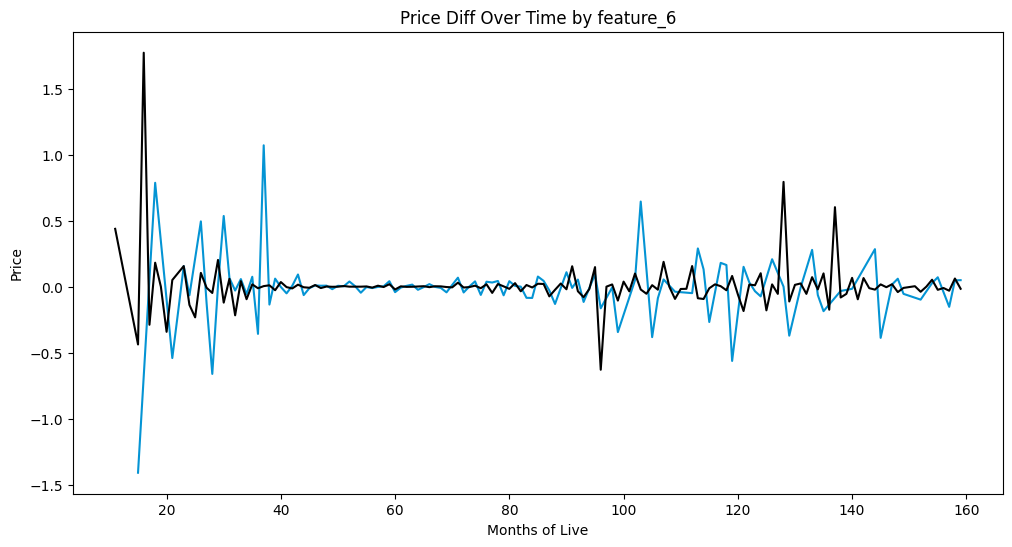


Repeated Measures ANOVA Results for feature_7:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_7.


at least one input has length 0


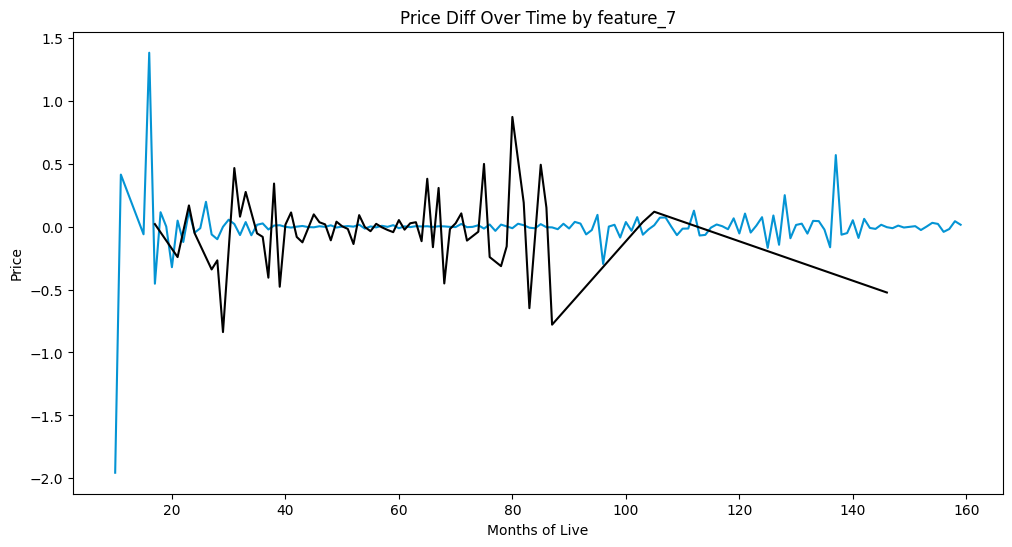


Repeated Measures ANOVA Results for feature_8:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for feature_8.


at least one input has length 0


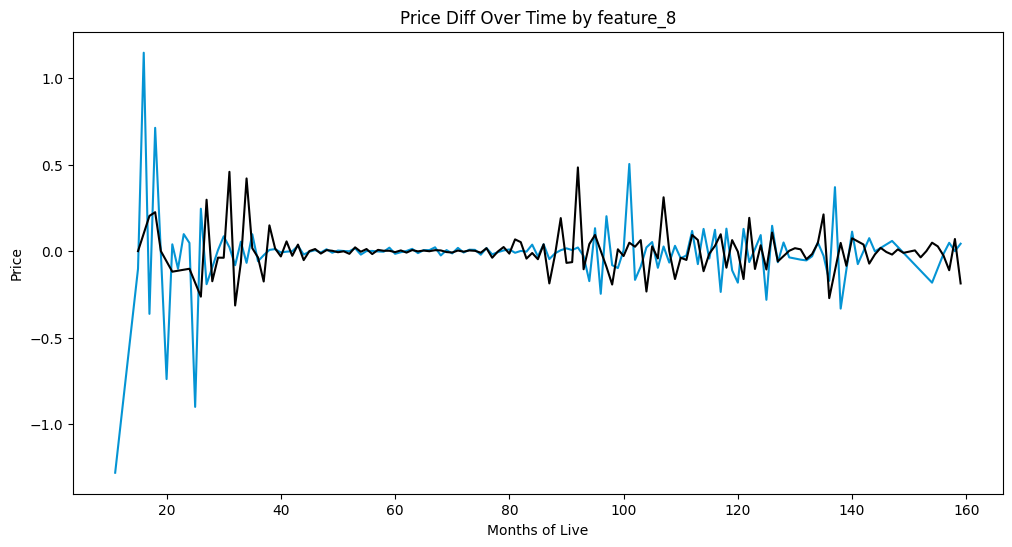


Repeated Measures ANOVA Results for color__beige:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__beige.


at least one input has length 0


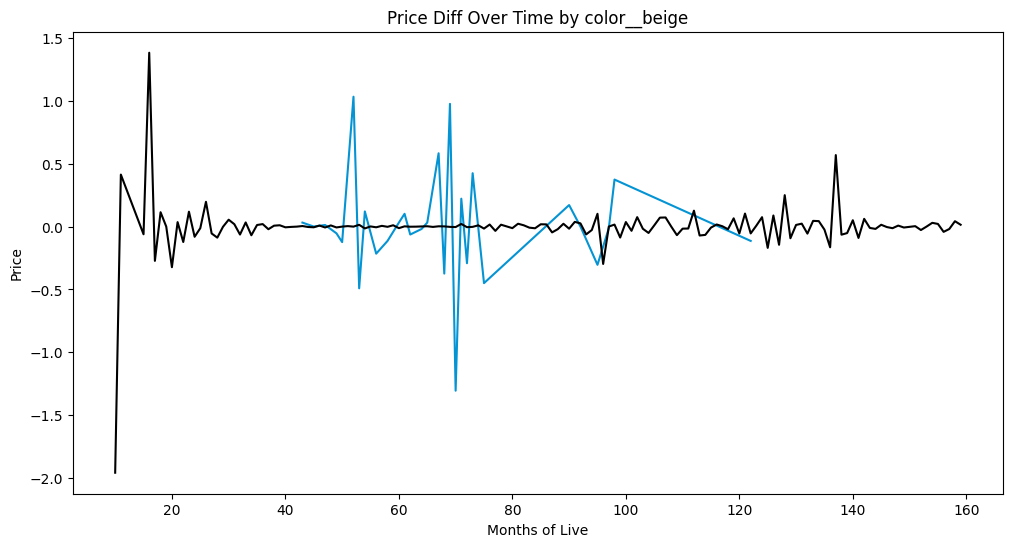


Repeated Measures ANOVA Results for color__black:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__black.


at least one input has length 0


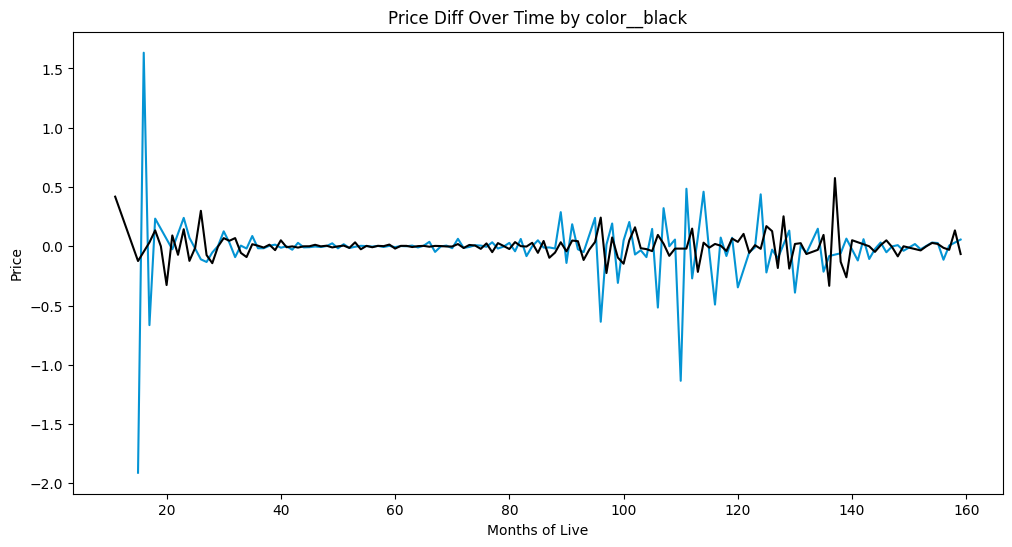


Repeated Measures ANOVA Results for color__blue:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__blue.


at least one input has length 0


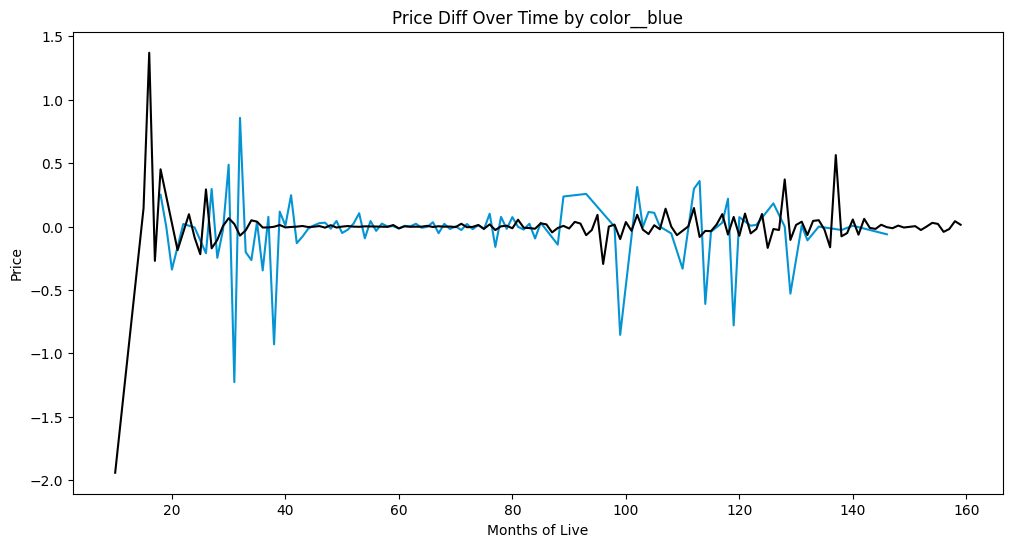


Repeated Measures ANOVA Results for color__brown:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__brown.


at least one input has length 0


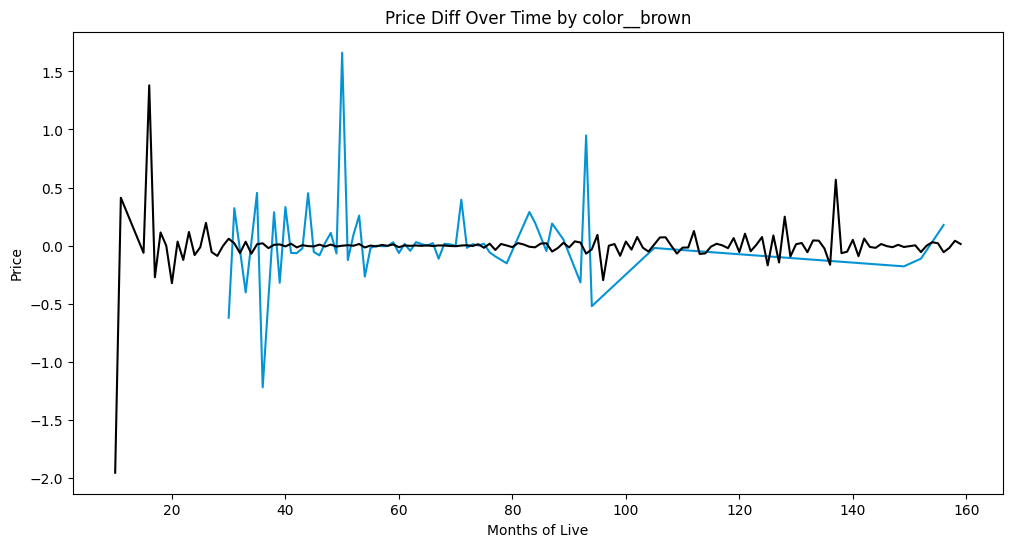


Repeated Measures ANOVA Results for color__green:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__green.


at least one input has length 0


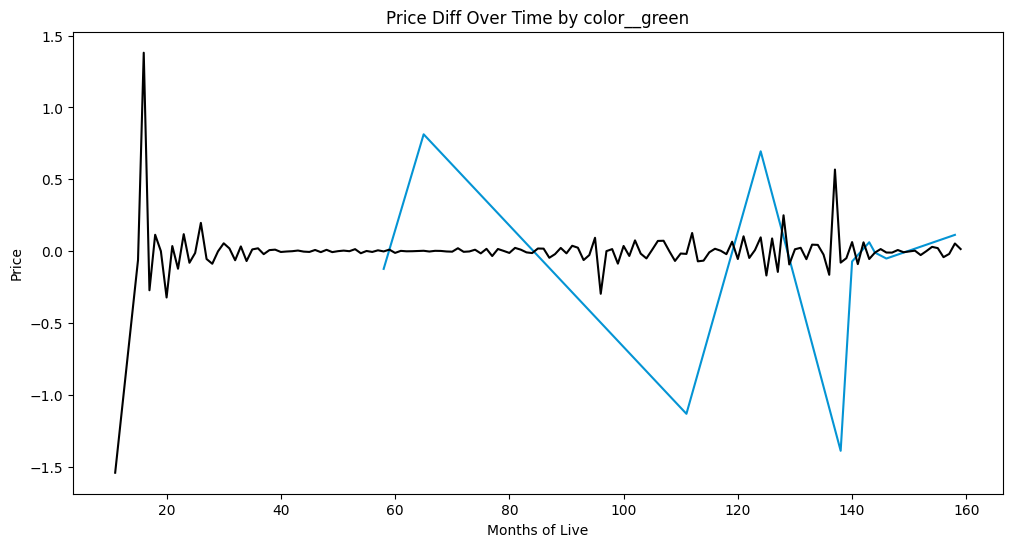


Repeated Measures ANOVA Results for color__grey:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__grey.


at least one input has length 0


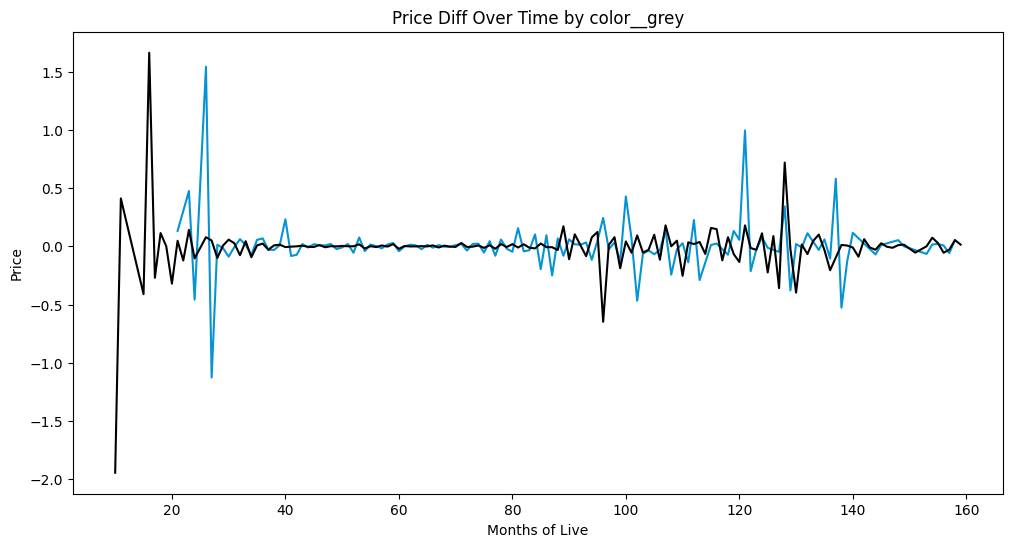


Repeated Measures ANOVA Results for color__orange:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__orange.


at least one input has length 0


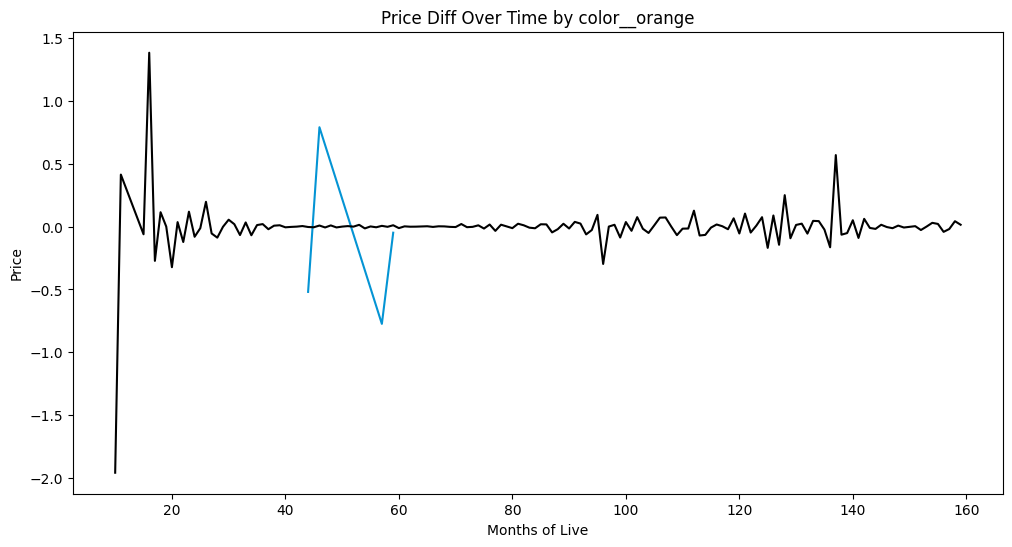


Repeated Measures ANOVA Results for color__red:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__red.


at least one input has length 0


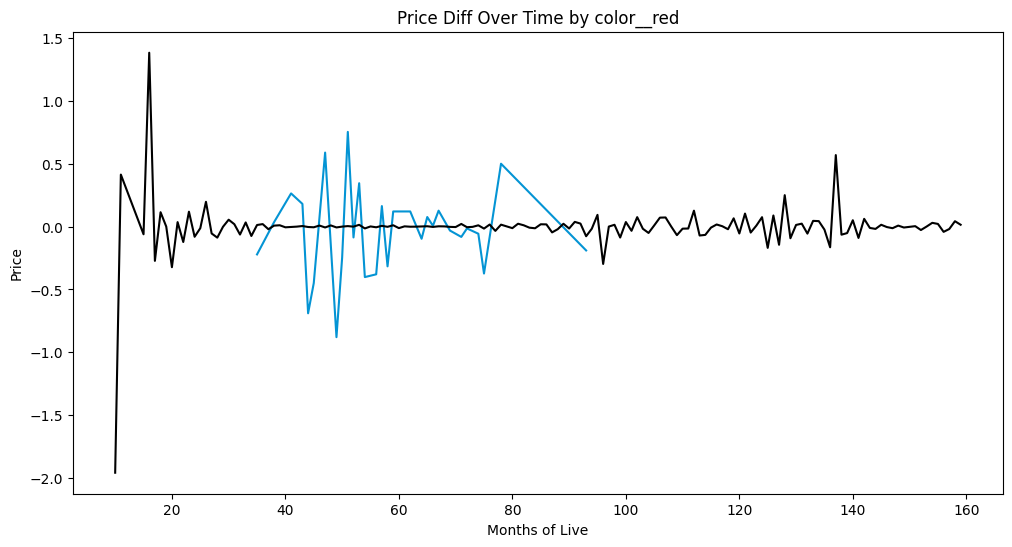


Repeated Measures ANOVA Results for color__silver:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__silver.


at least one input has length 0


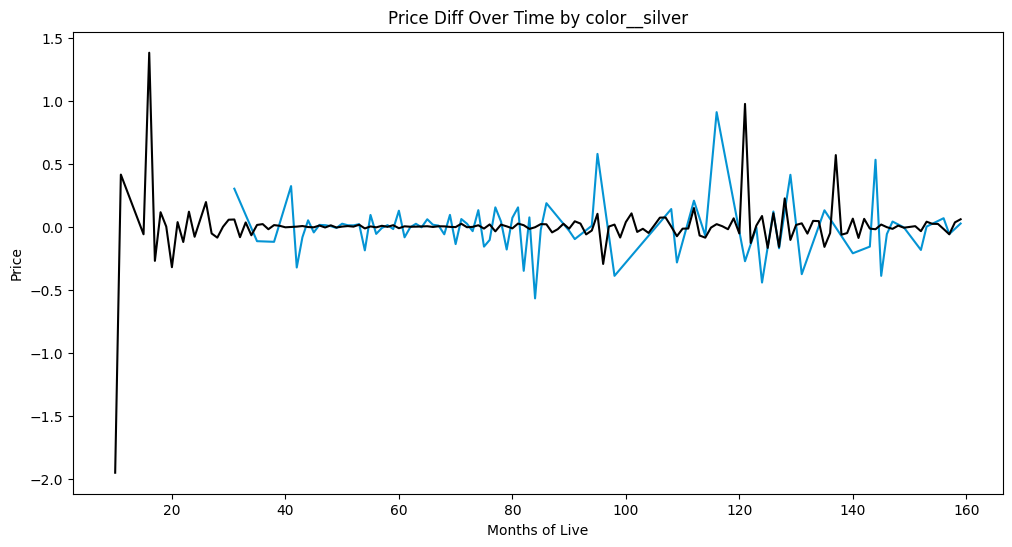


Repeated Measures ANOVA Results for color__white:
F-statistic: nan
P-value: nan
There is no significant difference in mean prices for color__white.


at least one input has length 0


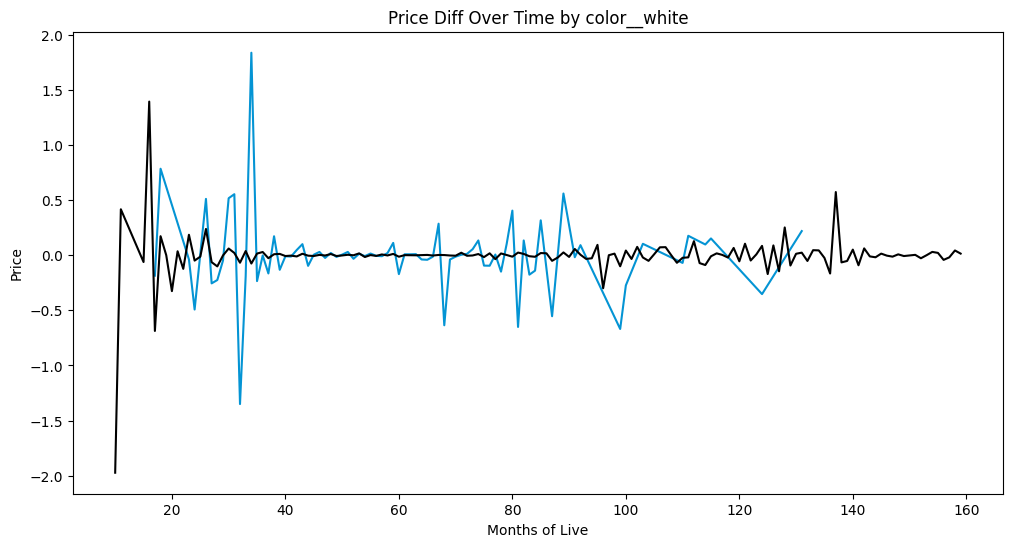

In [286]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Assuming df is your DataFrame
# Replace 'color', 'price_range', and 'features' with the actual column names of your categorical features
categorical_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
                       'color__beige', 'color__black', 'color__blue','color__brown', 'color__green', 'color__grey', 'color__orange',
                        'color__red', 'color__silver', 'color__white']
cleaned_df['months_lived'] = ((cleaned_df['lifespan'] // 30) + 1)
cleaned_df.sort_values(by='months_lived', inplace=True, ascending=True)
# Get the number of unique categories in each categorical feature
unique_categories = {col: cleaned_df[col].nunique() for col in categorical_features}

# Iterate through each categorical feature
for categorical_feature in categorical_features:
    plt.figure(figsize=(12, 6))
    cleaned_df_difft = cleaned_df[cleaned_df[categorical_feature] == True].diff()
    cleaned_df_difft['price'] = cleaned_df_difft['price']/np.mean(cleaned_df[cleaned_df[categorical_feature] == True]['price'])
    cleaned_df_difft['months_lived'] = cleaned_df['months_lived']# Make sure to use a new DataFrame for differencing
    
    
    cleaned_df_difff = cleaned_df[cleaned_df[categorical_feature] == False].diff()
    cleaned_df_difff['price'] = cleaned_df_difff['price']/np.mean(cleaned_df[cleaned_df[categorical_feature] == False]['price'])
    cleaned_df_difff['months_lived'] = cleaned_df['months_lived']
    
    
    sns.lineplot(data=cleaned_df_difft, x='months_lived', y='price', color='#0494d4',ci=None)
    sns.lineplot(data=cleaned_df_difff, x='months_lived', y='price', color='black',ci=None)
    
    plt.title(f'Price Diff Over Time by {categorical_feature}')
    plt.xlabel('Months of Live')
    plt.ylabel('Price')
    
    # Perform repeated measures ANOVA
    category_data = [cleaned_df_difft[cleaned_df_difft[categorical_feature] == category]['price'] for category in cleaned_df_difft[categorical_feature].unique()]
    
    f_statistic, p_value = f_oneway(*category_data)
    
    # Print ANOVA results
    print(f'\nRepeated Measures ANOVA Results for {categorical_feature}:')
    print(f'F-statistic: {f_statistic}')
    print(f'P-value: {p_value}')

    # Check the significance level (e.g., 0.05) to determine statistical significance
    if p_value < 0.05:
        print(f'The difference in mean prices is statistically significant for {categorical_feature}.')
    else:
        print(f'There is no significant difference in mean prices for {categorical_feature}.')

    plt.show()


In [128]:
cleaned_df.diff()

mileage  engine_power feature_1 feature_2 feature_3 feature_4  \
0          NaN           NaN       NaN       NaN       NaN       NaN   
2      42886.0          20.0      True      True     False     False   
3     -55262.0          15.0      True      True     False     False   
4     -30938.0          25.0     False     False     False     False   
6     108122.0         -15.0     False     False     False     False   
...        ...           ...       ...       ...       ...       ...   
4838  -27027.0           0.0     False     False     False     False   
4839   10089.0         -10.0     False     False     False     False   
4840  -30199.0          10.0     False     False     False     False   
4841    8287.0           0.0      True     False     False     False   
4842  167920.0          50.0     False     False     False     False   

     feature_5 feature_6 feature_7 feature_8  ...  color__black  color__blue  \
0          NaN       NaN       NaN       NaN  ...           NaN          NaN   
2        False      True     False     False  ...          True        False   
3        False      True     False      True  ...         False        False   
4         True     False     False     False  ...         False        False   
6         True     False     False     False  ...         False        False   
...        ...       ...       ...       ...  ...           ...          ...   
4838     False     False     False     False  ...          True         True   
4839     False     False     False      True  ...          True        False   
4840     False     False     False     False  ...         False        False   
4841     False     False     False     False  ...         False        False   
4842      True     False     False     False  ...         False        False   

      color__brown  color__green  color__grey  color__orange color__red  \
0              NaN           NaN          NaN            NaN        NaN   
2            False         False        False          False      False   
3            False         False        False          False       True   
4            False         False        False          False       True   
6            False         False         True          False      False   
...            ...           ...          ...            ...        ...   
4838         False         False        False          False      False   
4839         False         False         True          False      False   
4840         False         False        False          False      False   
4841          True         False         True          False      False   
4842          True         False         True          False      False   

     color__silver color__white months_lived  
0              NaN          NaN          NaN  
2            False         True        -30.0  
3            False         True       -840.0  
4             True        False        -90.0  
6             True        False       1980.0  
...            ...          ...          ...  
4838         False        False         30.0  
4839         False        False        120.0  
4840         False        False        -90.0  
4841         False        False       -180.0  
4842         False        False       1170.0  

[4416 rows x 27 columns]

The means of the two time series are not significantly different.


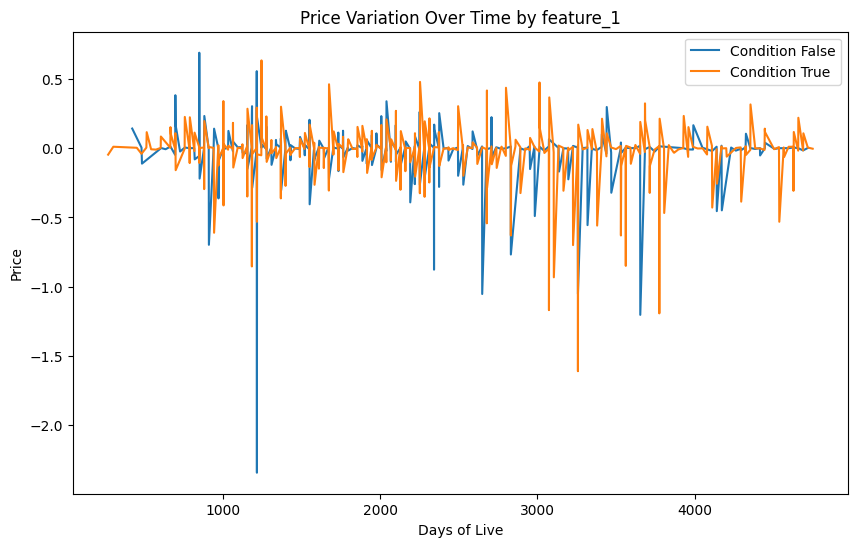

The means of the two time series are not significantly different.


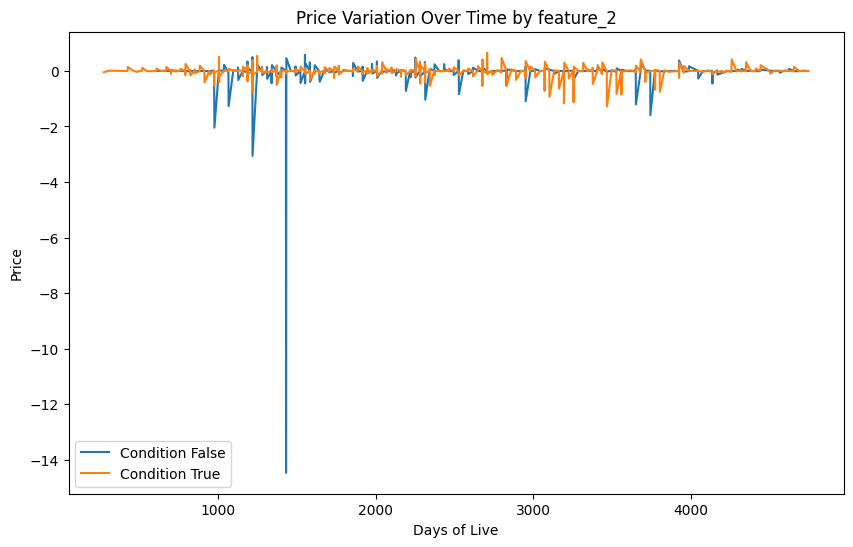

The means of the two time series are not significantly different.


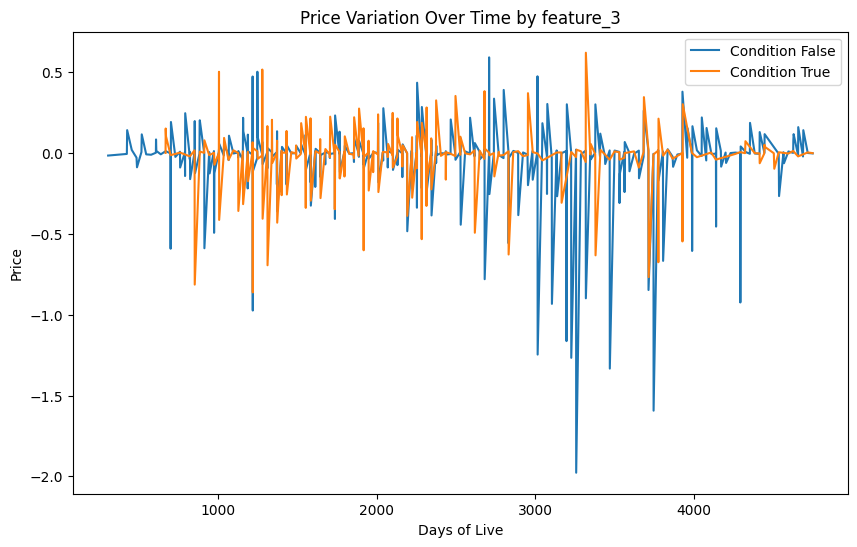

The means of the two time series are not significantly different.


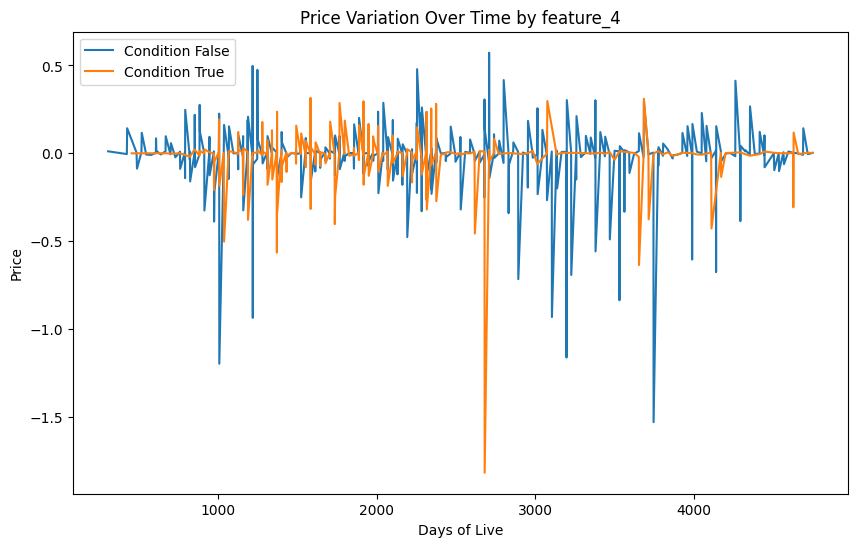

The means of the two time series are not significantly different.


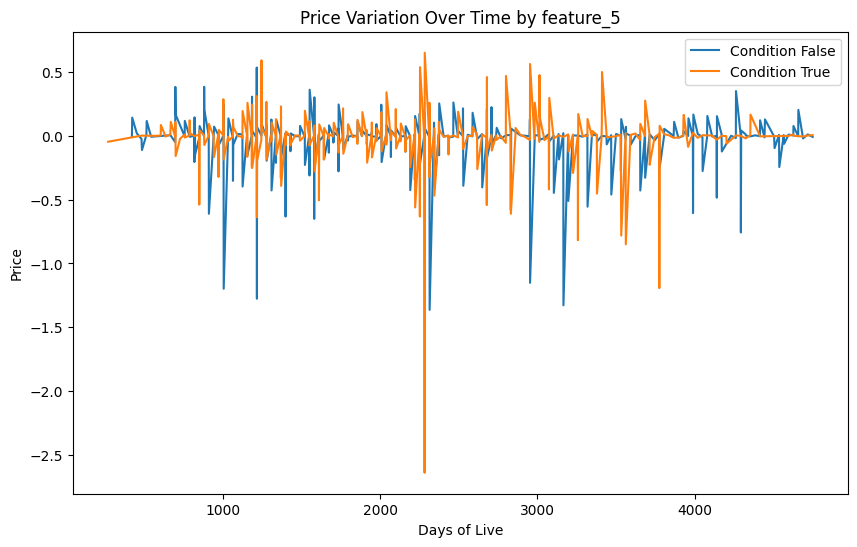

The means of the two time series are not significantly different.


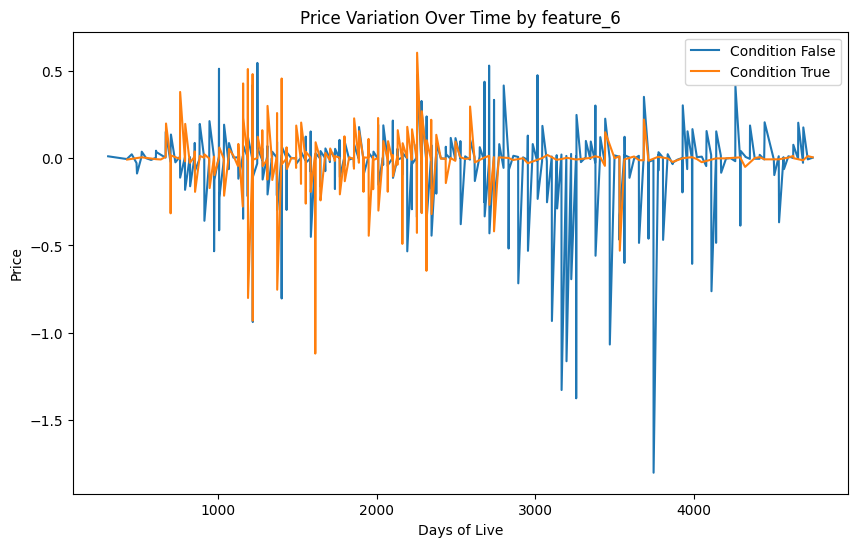

The means of the two time series are not significantly different.


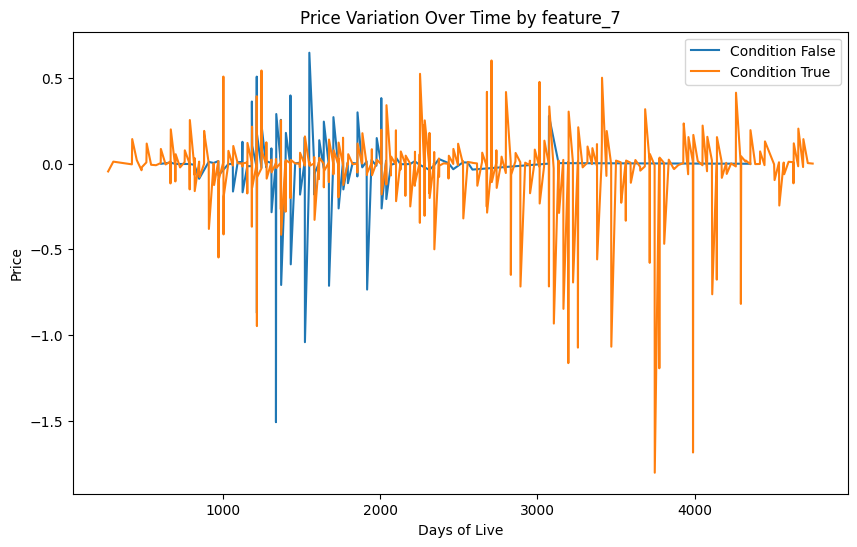

The means of the two time series are not significantly different.


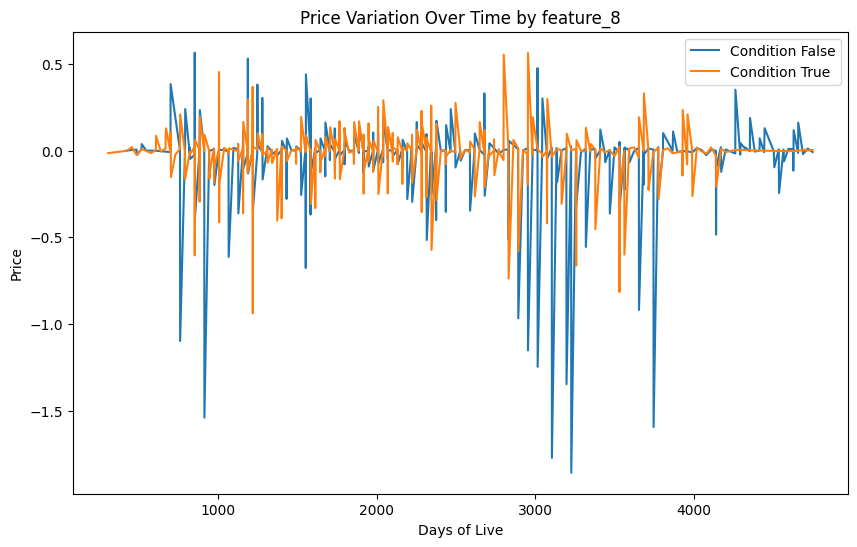

In [126]:
def calculate_price_days_ratio(df,feature):
    result_df = pd.DataFrame(columns=['lifespan', 'price_days_ratio', 'condition'])

    for feature_condition in [True, False]:
        filtered_df = df[df[feature] == feature_condition].groupby('lifespan')['price'].mean().reset_index()
        filtered_df['price_difference'] = filtered_df['price'].diff()
        filtered_df['days_difference'] = filtered_df['lifespan'].diff()

        # Calculate the ratio of price difference to days difference
        filtered_df['price_days_ratio'] = filtered_df['price_difference'] / filtered_df['days_difference'] /filtered_df['price']
        
        # Drop the first row
        filtered_df = filtered_df.drop(filtered_df.index[0]).reset_index(drop=True)
        
        # Add a condition column
        filtered_df['condition'] = feature_condition
        
        # Concatenate to the result_df
        result_df = pd.concat([result_df, filtered_df], ignore_index=True)

    return result_df
categorical_feat = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

for features in categorical_feat:
    # Calculate ratios for both True and False values of feature_1
    result_df = calculate_price_days_ratio(cleaned_df,features)

    # Plot the two time series
    fig, ax = plt.subplots(figsize=(10, 6))
    for condition, group in result_df.groupby('condition'):
        ax.plot(group['lifespan'], group['price_days_ratio'], label=f'Condition {condition}')

    ax.set_xlabel('Days of Live')
    ax.set_ylabel('Price Days Ratio')
    ax.legend()
    plt.title(f'Price Variation Over Time by {features}')
    plt.xlabel('Days of Live')  
    plt.ylabel('Price')         
    
    # Statistical test for similarity using ANOVA
    ts1 = result_df[result_df['condition'] == True]['price_days_ratio']
    ts2 = result_df[result_df['condition'] == False]['price_days_ratio']

    statistic, p_value = f_oneway(ts1, ts2)

    if p_value > 0.05:  # Choose an appropriate significance level
        print("The means of the two time series are not significantly different.")
    else:
        print("The means of the two time series are significantly different.")

    plt.show()

In [336]:
result_adf = adfuller(cleaned_df['price'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -4.692357208185944
p-value: 8.697919889127741e-05


## Seasonality?

### In the auction:

In [218]:
winter = cleaned_df[cleaned_df['month_sold']<5]
summer = cleaned_df[cleaned_df['month_sold']>4]

# Define numerical and categorical variables
numerical_variables = ['mileage','price','lifespan']  # Replace with your numerical variable names
categorical_variables = ['feature_1', 'feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8']  # Replace with your categorical variable names


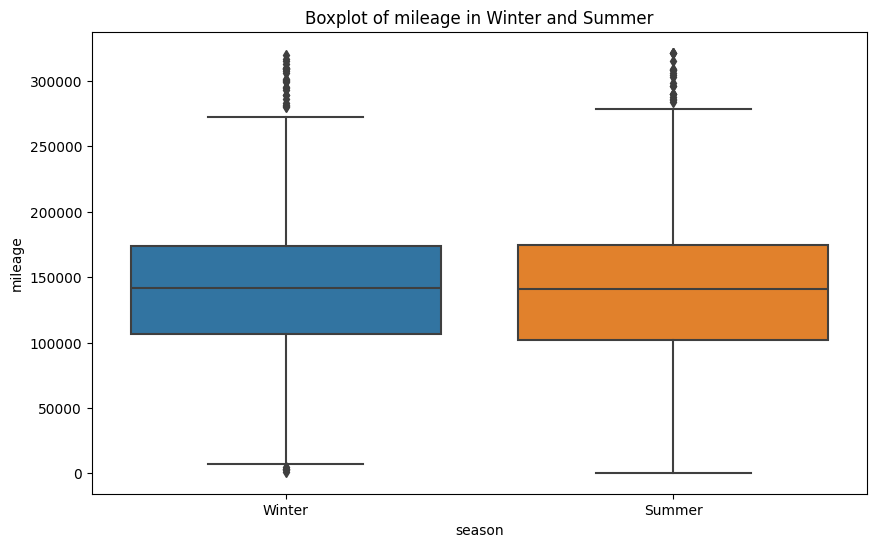

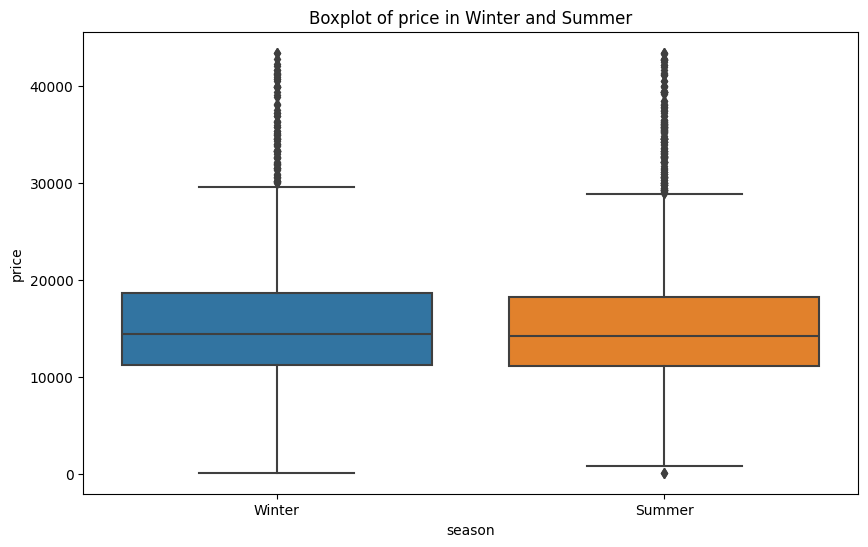

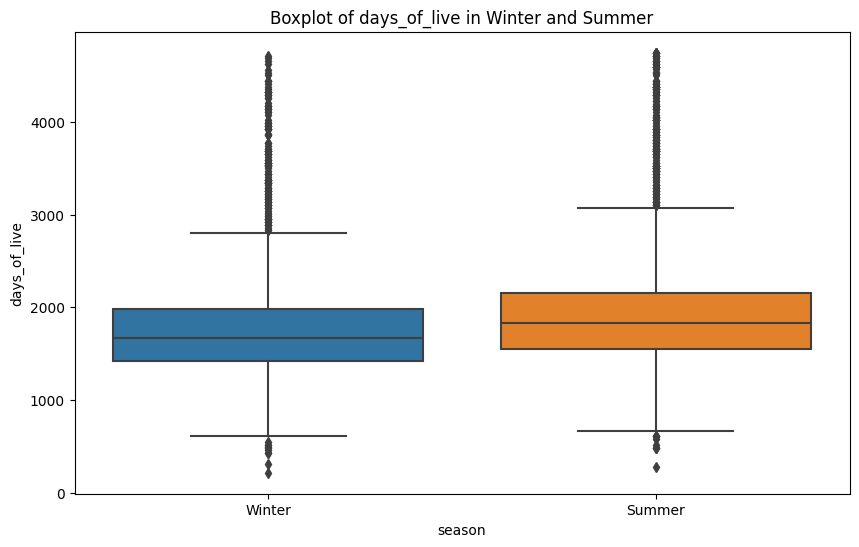

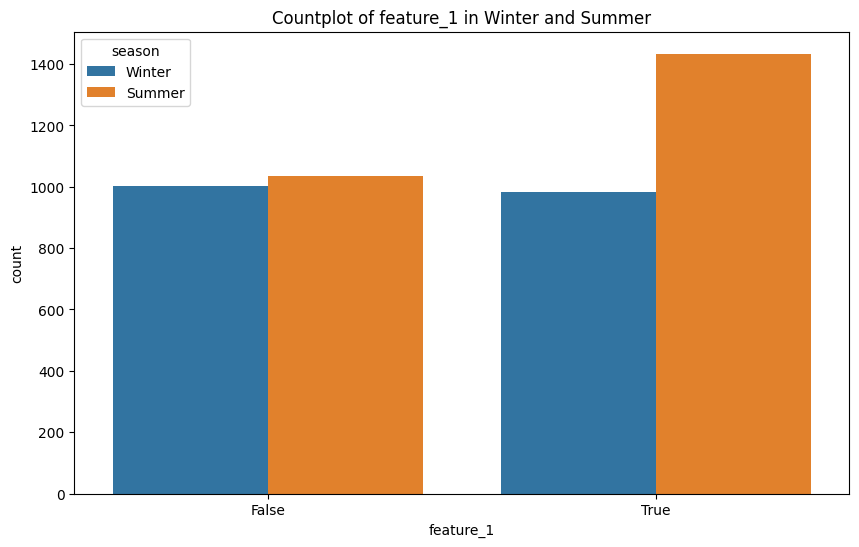

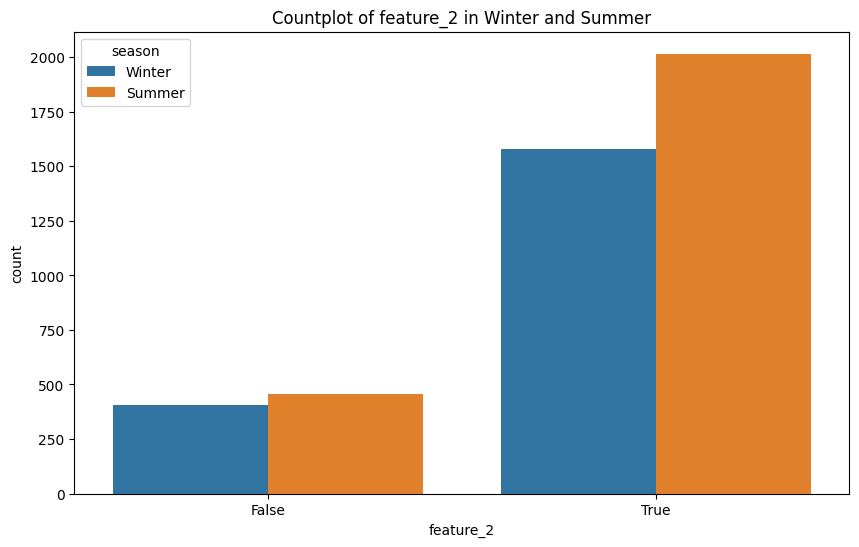

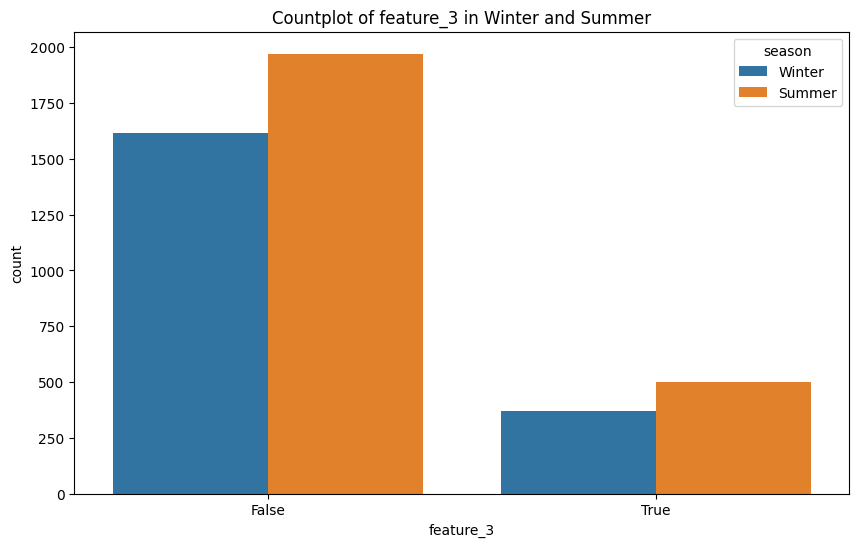

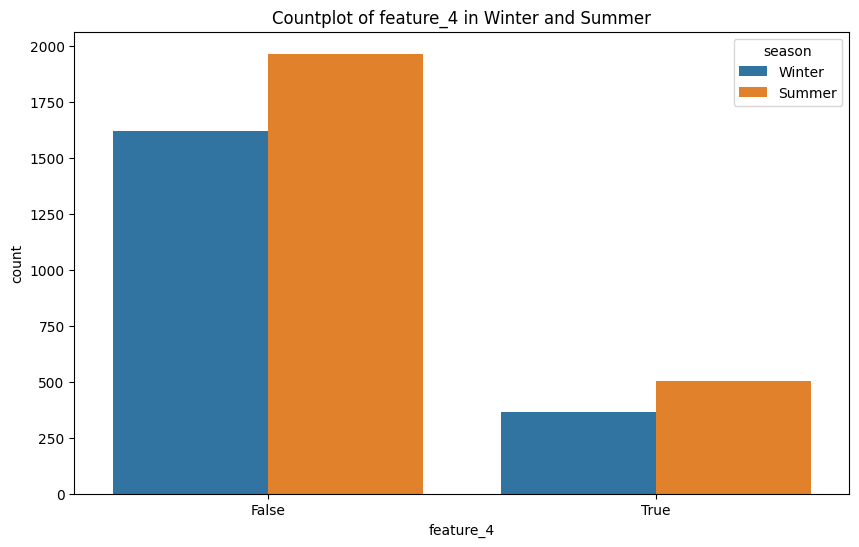

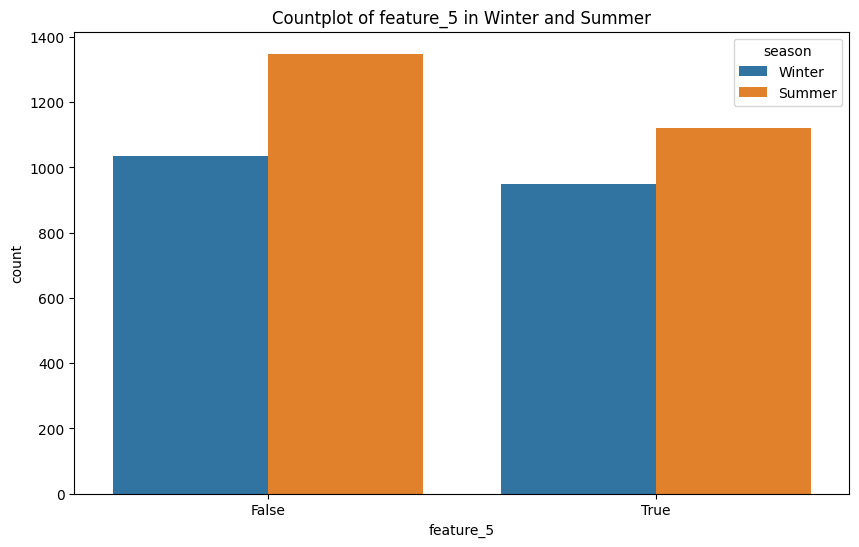

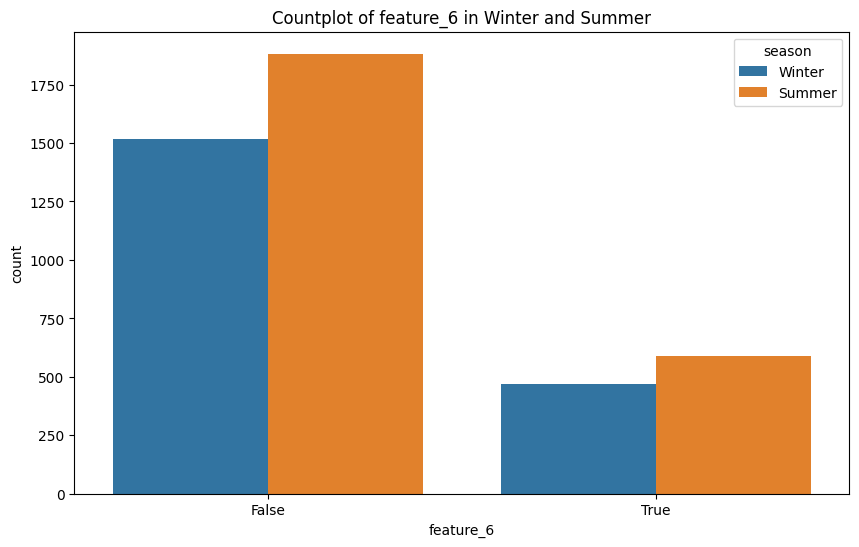

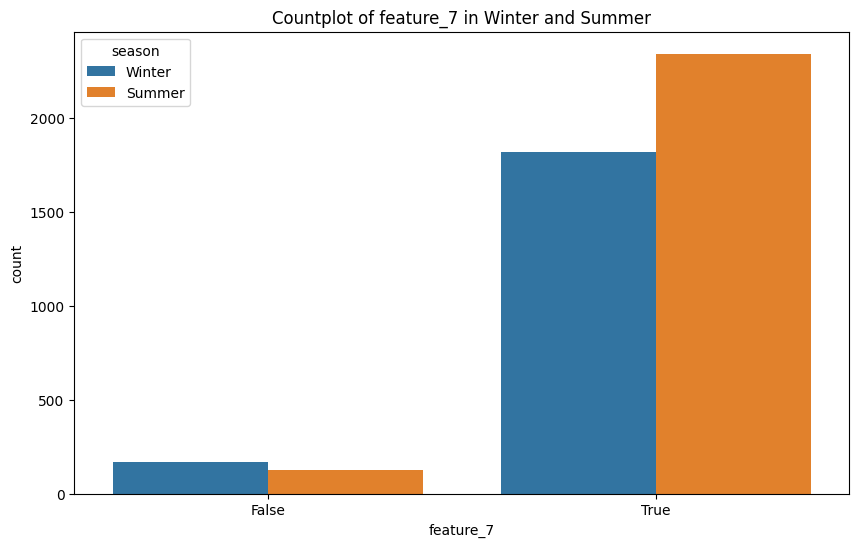

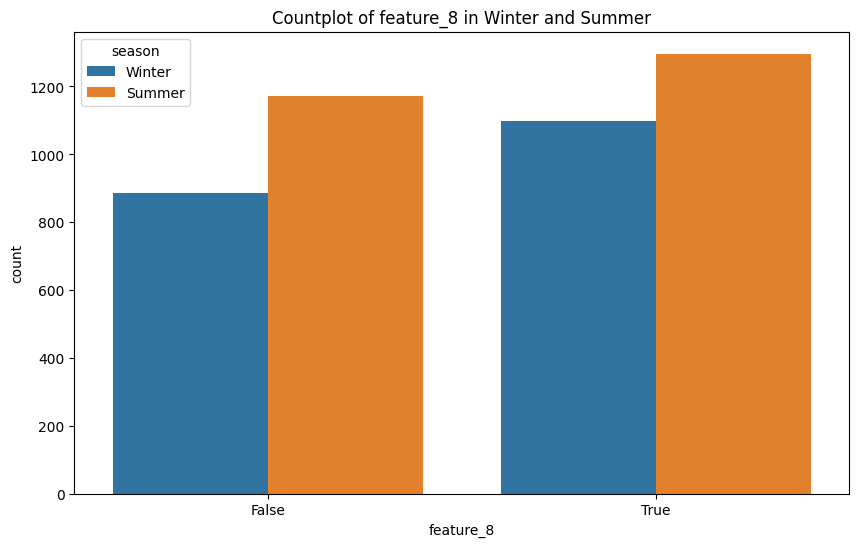

T-test for mileage: t-statistic=1.092862447485568, p-value=0.27451544358120017
Fail to reject the null hypothesis for mileage (no significant difference)


T-test for price: t-statistic=-0.5164830449516171, p-value=0.6055435447261728
Fail to reject the null hypothesis for price (no significant difference)


T-test for days_of_live: t-statistic=-7.892712613184277, p-value=3.7125019250864764e-15
Reject the null hypothesis for days_of_live (significant difference)


Chi-square test for feature_1: chi2-statistic=35.99920174173638, p-value=1.7566076152563602e-05
Reject the null hypothesis for feature_1 (significant difference)


Chi-square test for feature_2: chi2-statistic=7.404593659678522, p-value=0.4936739537595526
Fail to reject the null hypothesis for feature_2 (no significant difference)


Chi-square test for feature_3: chi2-statistic=9.44899065601615, p-value=0.3058455019477032
Fail to reject the null hypothesis for feature_3 (no significant difference)


Chi-square test for feature

In [219]:


# Assuming your dataset is loaded into a DataFrame called 'cleaned_df'


# Split the data into winter and summer
winter = cleaned_df[cleaned_df['month_sold'] < 5]
summer = cleaned_df[cleaned_df['month_sold'] > 4]

# Numerical variables - Box plots
for var in numerical_variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='season', y=var, data=pd.concat([winter.assign(season='Winter'), summer.assign(season='Summer')]))
    plt.title(f'Boxplot of {var} in Winter and Summer')
    plt.show()

# Categorical variables - Count plots
for var in categorical_variables:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, hue='season', data=pd.concat([winter.assign(season='Winter'), summer.assign(season='Summer')]))
    plt.title(f'Countplot of {var} in Winter and Summer')
    plt.show()

alpha = 0.05

# Statistical tests for numerical variables
for var in numerical_variables:
    t_stat, p_value = ttest_ind(winter[var], summer[var], equal_var=False)
    print(f'T-test for {var}: t-statistic={t_stat}, p-value={p_value}')
    
    # Check if the null hypothesis is rejected
    if p_value < alpha:
        print(f'Reject the null hypothesis for {var} (significant difference)')
    else:
        print(f'Fail to reject the null hypothesis for {var} (no significant difference)')
    print('\n')

# Statistical tests for categorical variables
for var in categorical_variables:
    contingency_table = pd.crosstab(
        pd.concat([winter[var], summer[var]]),
        pd.concat([winter['month_sold'], summer['month_sold']])
    )
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    print(f'Chi-square test for {var}: chi2-statistic={chi2_stat}, p-value={p_value}')
    
    # Check if the null hypothesis is rejected
    if p_value < alpha:
        print(f'Reject the null hypothesis for {var} (significant difference)')
    else:
        print(f'Fail to reject the null hypothesis for {var} (no significant difference)')
    print('\n')


### In the initial acquisition:

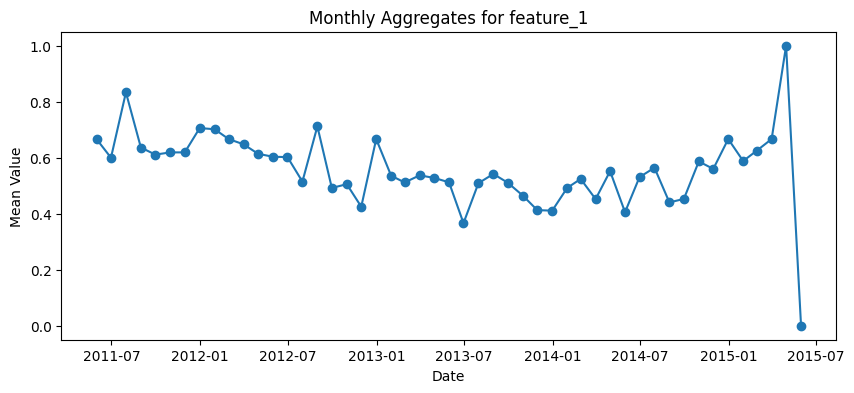

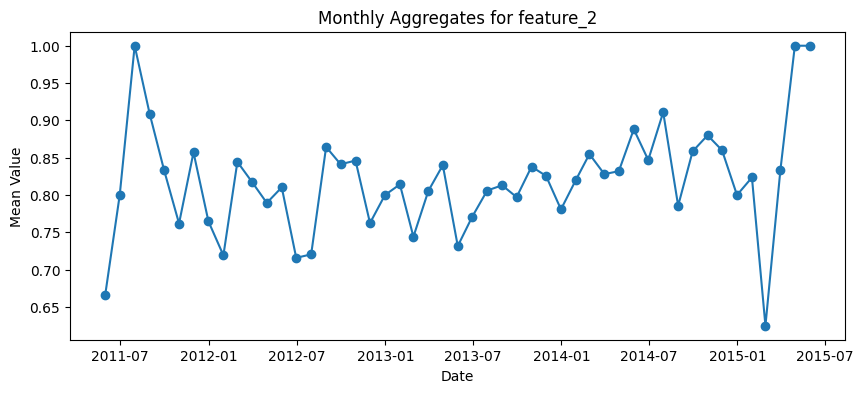

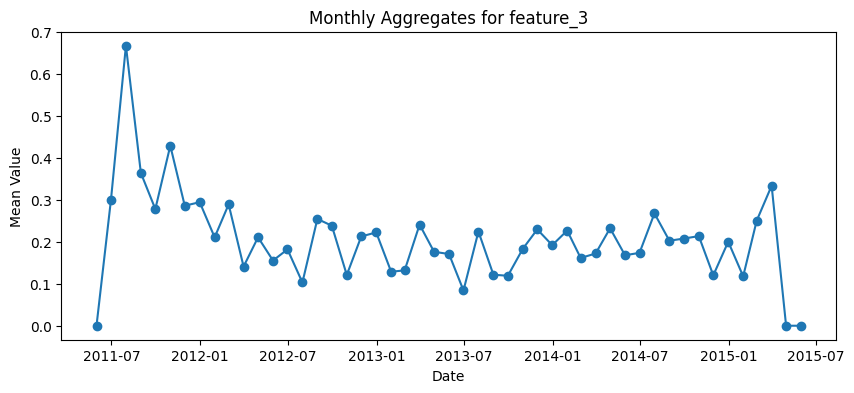

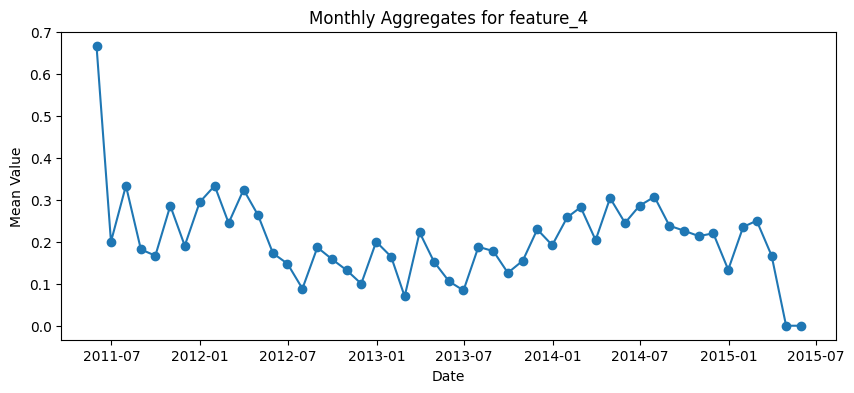

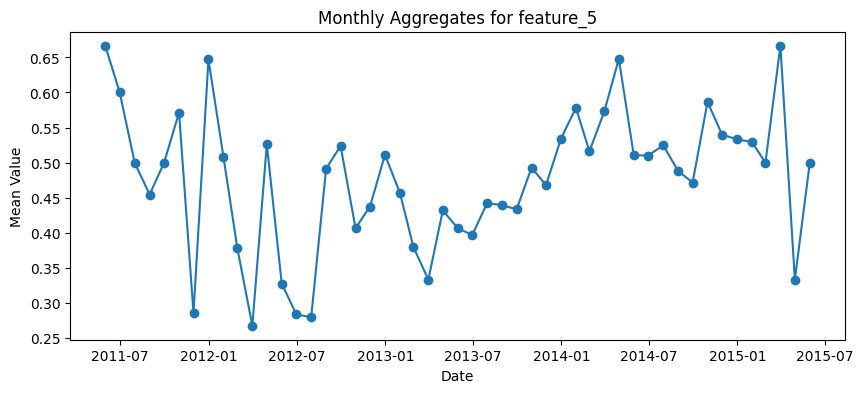

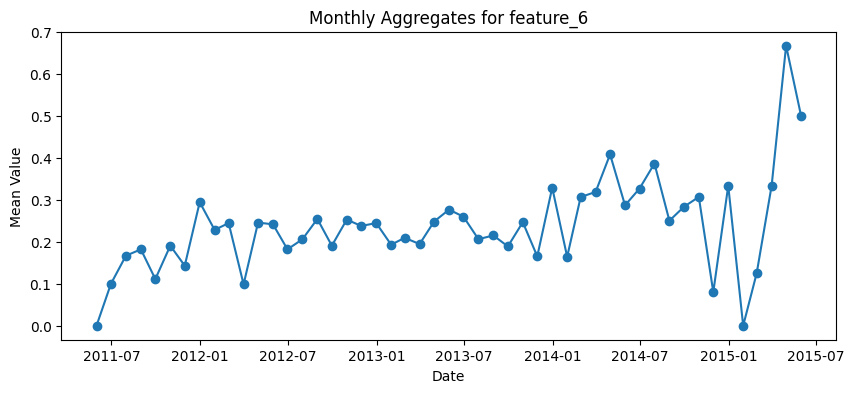

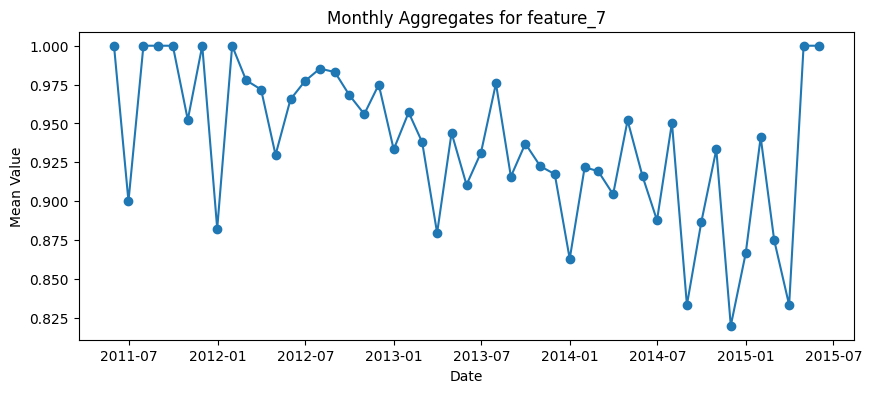

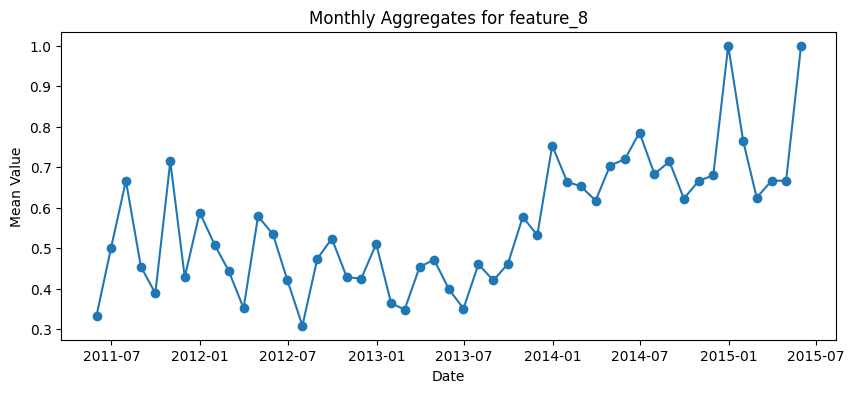

In [379]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'pre_std' is your DataFrame
indexes = pre_std[(pre_std['lifespan'] > 1200) & (pre_std['lifespan'] < 2500)].index

# Assuming 'df' is your DataFrame
values = df.loc[indexes][['registration_date', 'price', 'feature_1', 'feature_2', 'feature_3', 
                          'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']]

# Assuming you have a datetime column named 'registration_date'
values['registration_date'] = pd.to_datetime(values['registration_date'])

# Step 2: Create a new DataFrame with monthly aggregates
monthly_aggregates = values.set_index('registration_date').resample('M').mean()


# Step 3: Plot the monthly aggregates with xlim
features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

for feature in features:
    plt.figure(figsize=(10, 4))
    plt.plot(monthly_aggregates.index, monthly_aggregates[feature], marker='o')
    plt.title(f'Monthly Aggregates for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Mean Value')
    plt.show()

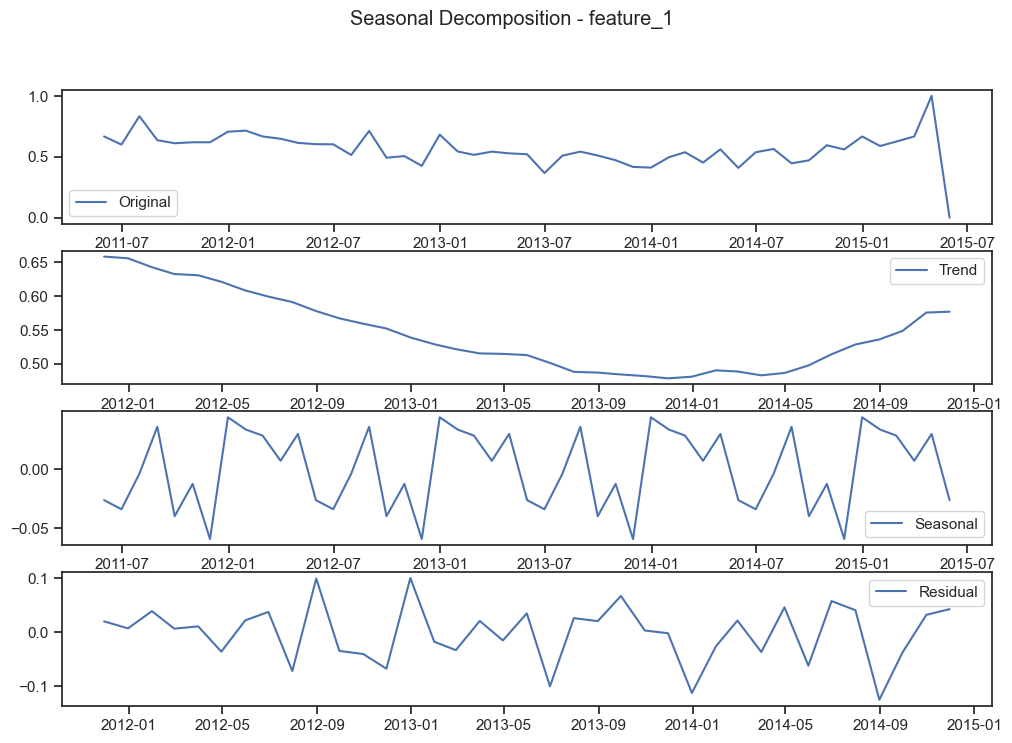

The time series may have seasonality.


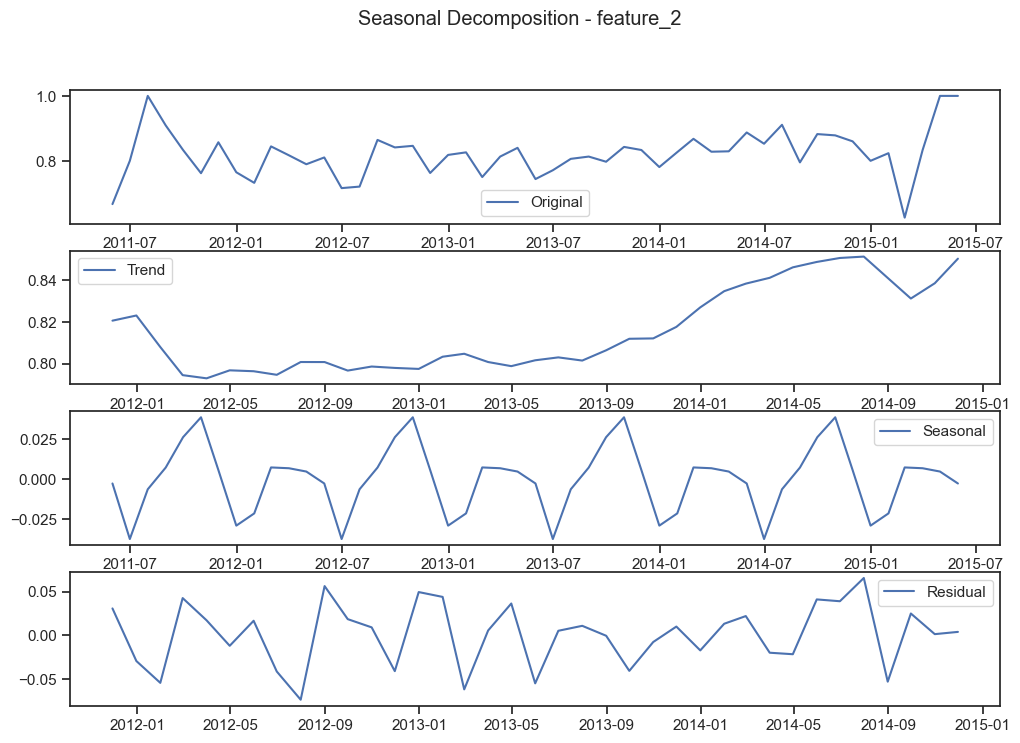

C:\Users\PORTATIL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


There is no significant evidence of seasonality.


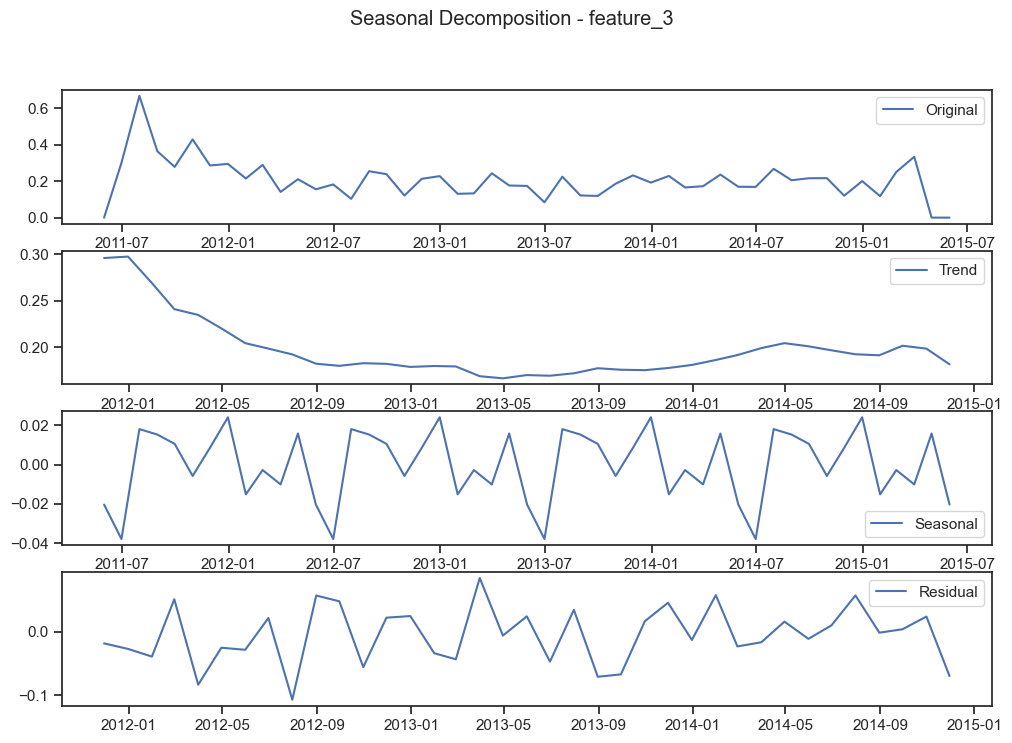

The time series may have seasonality.


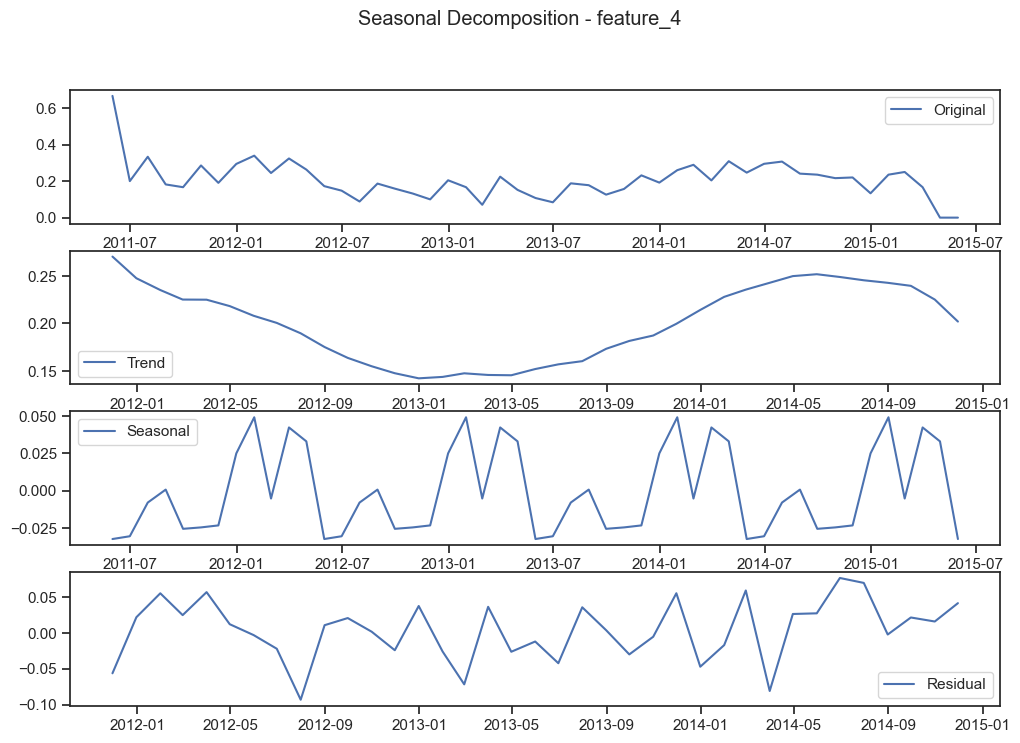

C:\Users\PORTATIL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


There is no significant evidence of seasonality.


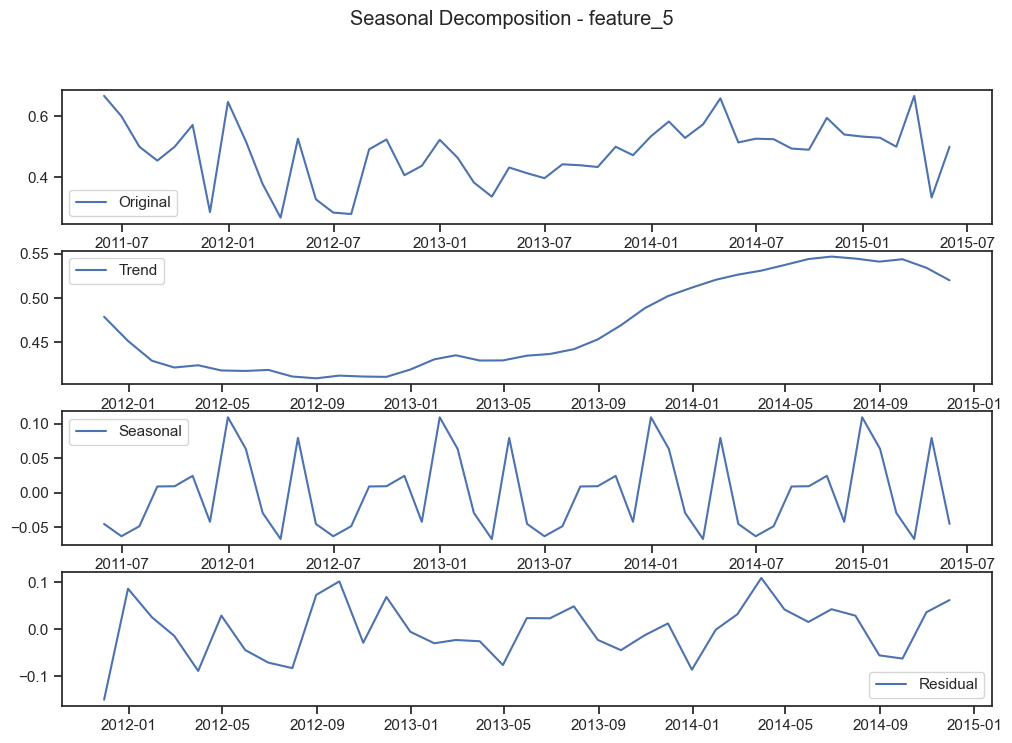

C:\Users\PORTATIL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


There is no significant evidence of seasonality.


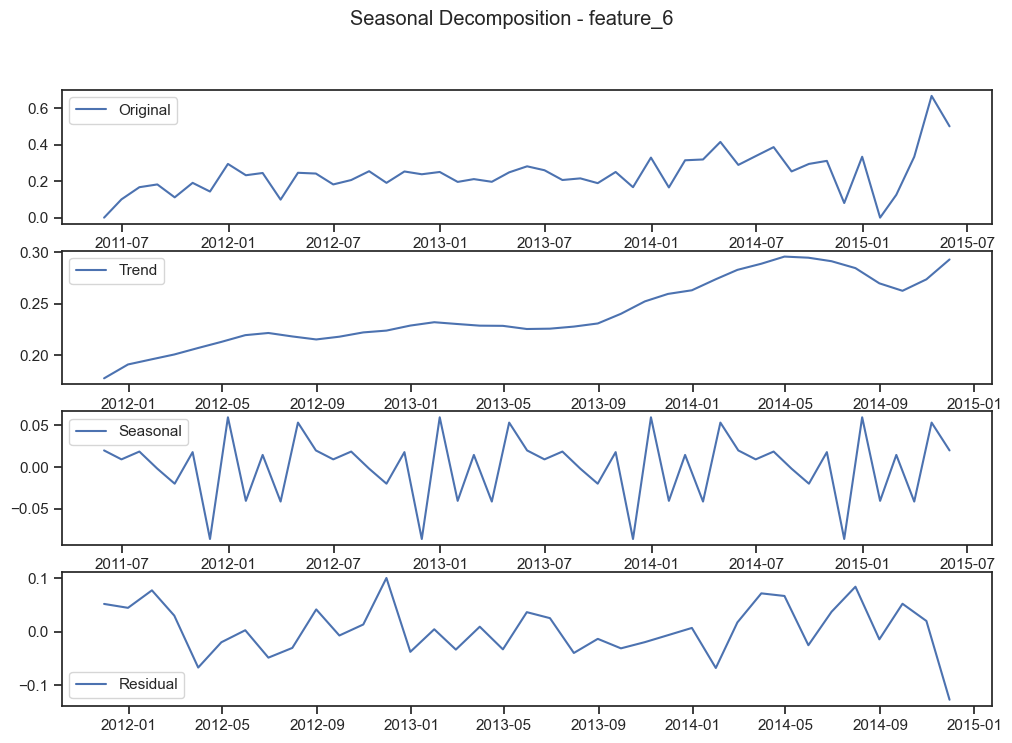

The time series may have seasonality.


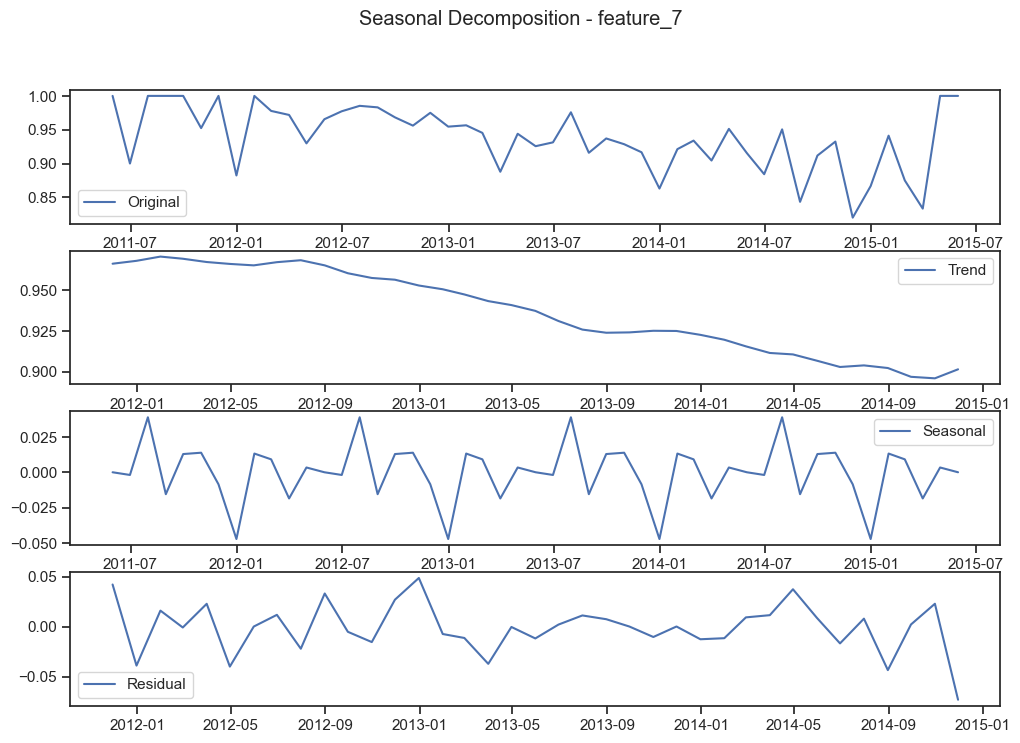

C:\Users\PORTATIL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The time series may have seasonality.


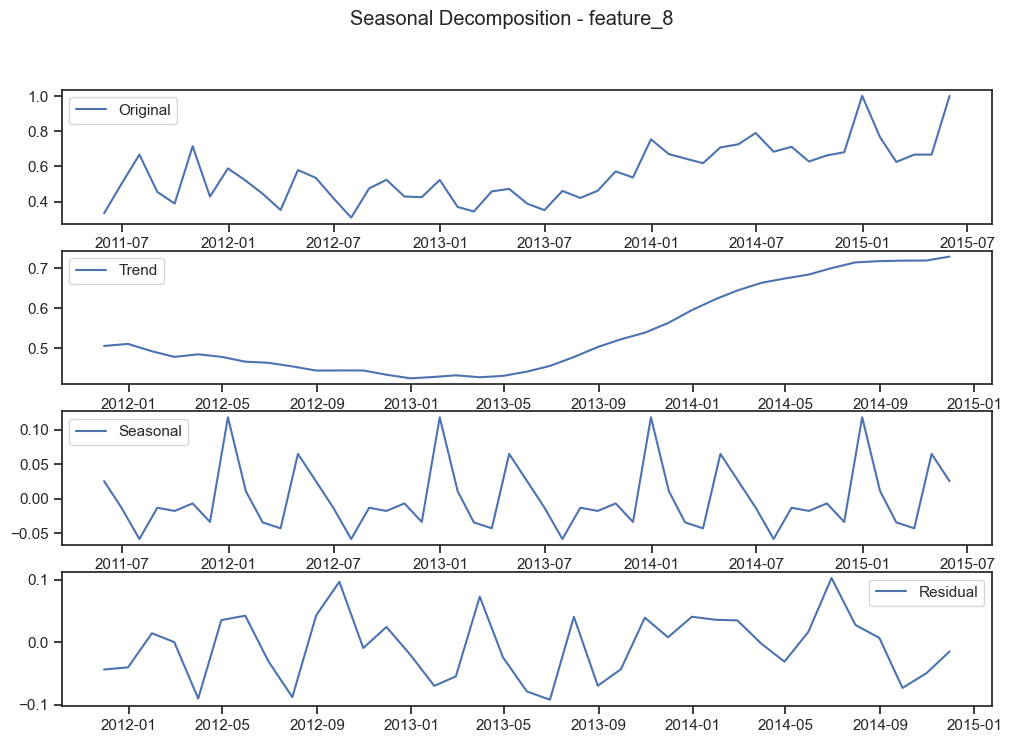

The time series may have seasonality.


C:\Users\PORTATIL\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [143]:
from statsmodels.tsa.stattools import kpss
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'pre_std' is your DataFrame
indexes = pre_std[(pre_std['lifespan'] > 1200) & (pre_std['lifespan'] < 2500)].index

# Assuming 'df' is your DataFrame
values = df.loc[indexes][['registration_date', 'price', 'feature_1', 'feature_2', 'feature_3', 
                          'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']]

# Assuming you have a datetime column named 'registration_date'
values['registration_date'] = pd.to_datetime(values['registration_date'])

# Step 2: Create a new DataFrame with monthly aggregates
monthly_aggregates = values.set_index('registration_date').resample('M').mean()

# Step 3: Plot the seasonal decomposition
features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

for feature in features:
    decomposition = seasonal_decompose(monthly_aggregates[feature], period=12)  # Adjust the period as needed
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(monthly_aggregates.index, monthly_aggregates[feature], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(monthly_aggregates.index, decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(monthly_aggregates.index, decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(monthly_aggregates.index, decomposition.resid, label='Residual')
    plt.legend()

    plt.suptitle(f'Seasonal Decomposition - {feature}')
    plt.show()
    

    # Assuming 'data' is your time series data
    result = kpss(monthly_aggregates[feature], regression='c')

    # Check the p-value
    p_value = result[1]

    # Compare p-value to a significance level (e.g., 0.05) to make a decision
    if p_value < 0.05:
        print("The time series may have seasonality.")
    else:
        print("There is no significant evidence of seasonality.")


In [380]:
df

maker_key          model_key  mileage  engine_power registration_date  \
0          BMW                118   140411           100        2012-02-01   
1          BMW                 M4    13929           317        2016-04-01   
2          BMW                320   183297           120        2012-04-01   
3          BMW                420   128035           135        2014-07-01   
4          BMW                425    97097           160        2014-12-01   
...        ...                ...      ...           ...               ...   
4838       BMW    218 Gran Tourer    39743           110        2015-10-01   
4839       BMW  218 Active Tourer    49832           100        2015-06-01   
4840       BMW    218 Gran Tourer    19633           110        2015-10-01   
4841       BMW  218 Active Tourer    27920           110        2016-04-01   
4842       BMW                525   195840           160        2013-01-01   

        fuel     car_type  feature_1  feature_2  feature_3  ...  color__beige  \
0     diesel  convertible       True       True      False  ...         False   
1     petrol  convertible       True       True      False  ...         False   
2     diesel  convertible      False      False      False  ...         False   
3     diesel  convertible       True       True      False  ...         False   
4     diesel  convertible       True       True      False  ...         False   
...      ...          ...        ...        ...        ...  ...           ...   
4838  diesel          van      False       True      False  ...         False   
4839  diesel          van      False       True      False  ...         False   
4840  diesel          van      False       True      False  ...         False   
4841  diesel          van       True       True      False  ...         False   
4842  diesel          van       True       True      False  ...         False   

      color__black  color__blue  color__brown  color__green  color__grey  \
0             True        False         False         False        False   
1            False        False         False         False         True   
2            False        False         False         False        False   
3            False        False         False         False        False   
4            False        False         False         False        False   
...            ...          ...           ...           ...          ...   
4838          True        False         False         False        False   
4839         False        False         False         False         True   
4840         False        False         False         False         True   
4841         False        False          True         False        False   
4842         False        False         False         False         True   

     color__orange  color__red  color__silver  color__white  
0            False       False          False         False  
1            False       False          False         False  
2            False       False          False          True  
3            False        True          False         False  
4            False       False           True         False  
...            ...         ...            ...           ...  
4838         False       False          False         False  
4839         False       False          False         False  
4840         False       False          False         False  
4841         False       False          False         False  
4842         False       False          False         False  

[4843 rows x 32 columns]

<Figure size 1000x400 with 0 Axes>

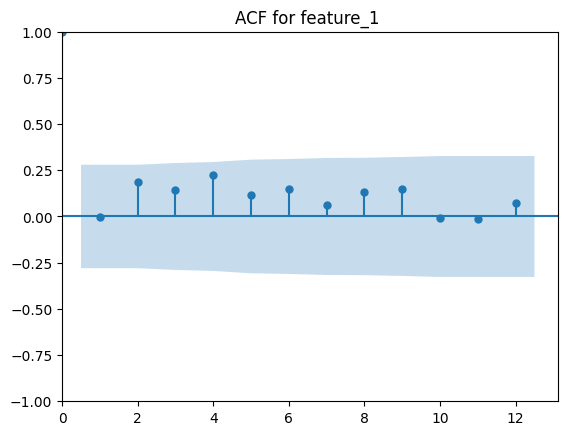

<Figure size 1000x400 with 0 Axes>

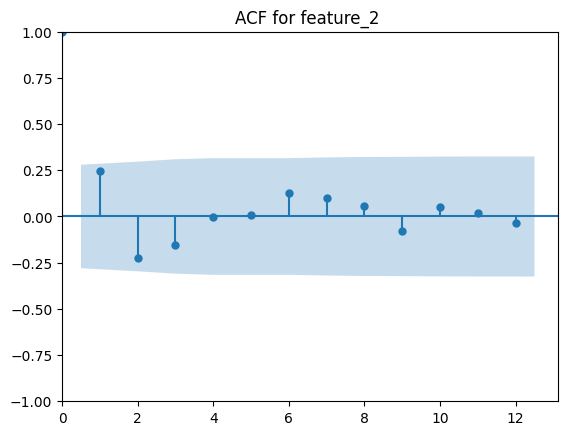

<Figure size 1000x400 with 0 Axes>

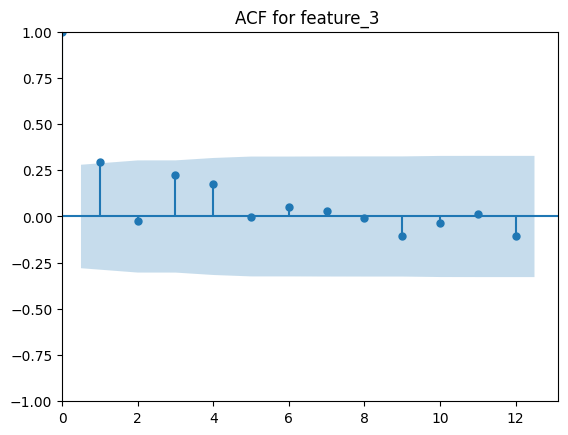

<Figure size 1000x400 with 0 Axes>

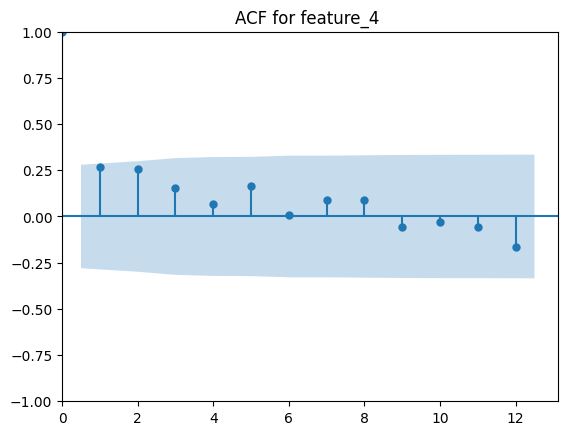

<Figure size 1000x400 with 0 Axes>

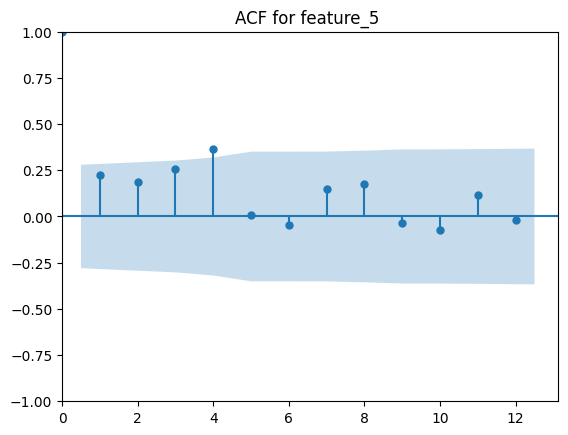

<Figure size 1000x400 with 0 Axes>

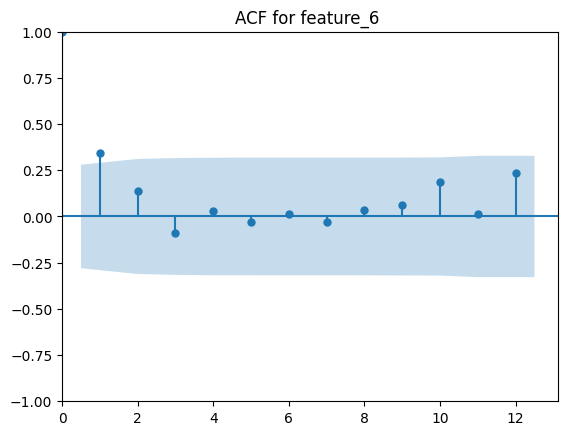

<Figure size 1000x400 with 0 Axes>

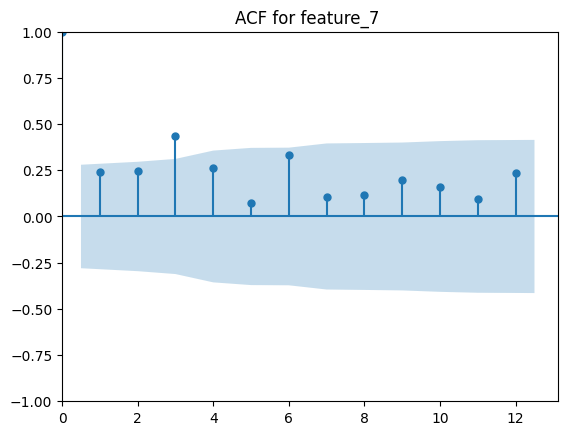

<Figure size 1000x400 with 0 Axes>

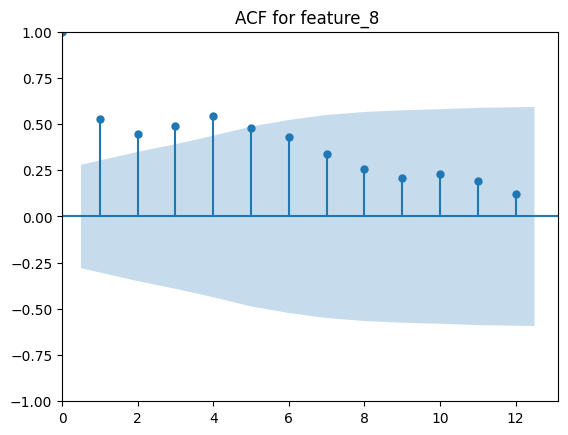

In [386]:

# Step 5: Use statistical methods to check for seasonality (ACF plots) with xlim
for feature in features:
    plt.figure(figsize=(10, 4))
    
    # Filter data starting from the specified start_date
    filtered_data = monthly_aggregates[feature].dropna()
    
    # Generate ACF plot for the filtered data
    plot_acf(filtered_data, lags=12)  # Adjust lags as needed
    plt.title(f'ACF for {feature} ')
    plt.xlim(0, None)  # Set the x-axis limit
    plt.show()

# 3. WHICH CAR TO BUY:

In [289]:
X_fut

mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
3935    10706           155       True       True      False       True   
140    132991           170       True       True       True      False   
3902    25084           100       True       True      False      False   
3682    16777            85      False       True      False      False   
1828    25106           110      False       True      False      False   
...       ...           ...        ...        ...        ...        ...   
4719   254355           110       True       True       True       True   
1424   279832           120       True      False       True      False   
2698   261476           160       True       True      False      False   
1448   216334           120       True       True      False      False   
4423   248629           155       True       True       True       True   

      feature_5  feature_6  feature_7  feature_8  ...  color__black  \
3935       True       True       True       True  ...          True   
140        True      False       True      False  ...         False   
3902      False      False       True       True  ...         False   
3682      False      False       True      False  ...          True   
1828      False       True       True       True  ...         False   
...         ...        ...        ...        ...  ...           ...   
4719       True       True       True      False  ...          True   
1424      False      False       True       True  ...         False   
2698       True      False       True       True  ...         False   
1448      False      False       True      False  ...         False   
4423       True       True       True       True  ...          True   

      color__blue  color__brown  color__green  color__grey  color__orange  \
3935        False         False         False        False          False   
140         False         False          True        False          False   
3902         True         False         False        False          False   
3682        False         False         False        False          False   
1828        False         False         False         True          False   
...           ...           ...           ...          ...            ...   
4719        False         False         False        False          False   
1424        False         False         False        False          False   
2698        False         False         False        False          False   
1448        False         False         False        False          False   
4423        False         False         False        False          False   

      color__red  color__silver  color__white  months_lived  
3935       False          False         False             8  
140        False          False         False            10  
3902       False          False         False            11  
3682       False          False         False            15  
1828       False          False         False            15  
...          ...            ...           ...           ...  
4719       False          False         False           158  
1424       False           True         False           159  
2698       False           True         False           159  
1448       False           True         False           159  
4423       False          False         False           159  

[4448 rows x 27 columns]

In [323]:
X_fut = pre_std.copy()
X_fut['mileage'] = X_fut['mileage'] + 10000
X_fut['lifespan'] = X_fut['lifespan'] + 365
X_fut = standarize(X_fut)

In [326]:
d[selected_features]

mileage  engine_power  feature_1  feature_2  feature_3  feature_4  \
0     0.020288     -0.774482       True       True      False      False   
2     0.833768     -0.185465      False      False      False      False   
3    -0.214466      0.256298       True       True      False      False   
4    -0.801311      0.992569       True       True      False      False   
6     1.249594      0.550806       True       True      False      False   
...        ...           ...        ...        ...        ...        ...   
4838 -1.889227     -0.479973      False       True      False      False   
4839 -1.697855     -0.774482      False       True      False      False   
4840 -2.270682     -0.479973      False       True      False      False   
4841 -2.113491     -0.479973       True       True      False      False   
4842  1.071689      0.992569       True       True      False      False   

      feature_5  feature_6  feature_7  feature_8  first_digit  lifespan  \
0          True       True       True      False            1  0.406947   
2          True      False       True      False            3  0.364056   
3          True       True       True       True            4 -0.850197   
4         False       True       True       True            4 -0.989223   
6          True       True       True       True            3  1.940663   
...         ...        ...        ...        ...          ...       ...   
4838      False      False       True      False            2 -1.258399   
4839      False      False       True       True            2 -1.077962   
4840      False      False       True       True            2 -1.212551   
4841      False      False       True       True            2 -1.483206   
4842       True      False       True       True            5  0.270880   

      month_sold  type_encoded  color__black  color__blue  color__grey  \
0              1             4          True        False        False   
2              2             4         False        False        False   
3              2             4         False        False        False   
4              4             4         False        False        False   
6              2             4         False        False         True   
...          ...           ...           ...          ...          ...   
4838           8             7          True        False        False   
4839           8             7         False        False         True   
4840           9             7         False        False         True   
4841           9             7         False        False        False   
4842           9             7         False        False         True   

      color__silver  
0             False  
2             False  
3             False  
4              True  
6             False  
...             ...  
4838          False  
4839          False  
4840          False  
4841          False  
4842          False  

[4448 rows x 18 columns]

In [330]:
X_fut['pred'] = best_modelxgb.predict(X_fut[selected_features])

In [331]:
X_fut['gain'] = (X_fut['pred'] - X_fut['price']).astype(int)

In [354]:
X_fut = X_fut[X_fut['price']>20000]
indexes = X_fut[X_fut['price']>20000].sort_values(by='gain',ascending=False).head(10).index

In [360]:
pre_std.loc[indexes]['lifespan']

4648    1127
4173     913
4267    1430
3919    1553
99      1431
4023    1461
2103    1612
3251    1491
3973    1614
4136     882
Name: lifespan, dtype: int64

In [355]:
df.loc[indexes]

maker_key         model_key  mileage  engine_power registration_date  \
4648       BMW                X4    53055           140        2015-07-01   
4173       BMW                X4    50941           140        2015-10-01   
4267       BMW                X5   100943           190        2014-06-01   
3919       BMW                X5    76677           190        2013-11-01   
99         BMW               435    90763           230        2014-05-01   
4023       BMW                X4    58117           230        2014-08-01   
2103       BMW  530 Gran Turismo    77883           190        2013-11-01   
3251       BMW               530   145206           190        2014-04-01   
3973       BMW                X5   152658           180        2013-09-01   
4136       BMW                X4    65581           140        2015-11-01   

        fuel   car_type  feature_1  feature_2  feature_3  ...  color__beige  \
4648  diesel        suv       True       True      False  ...         False   
4173  diesel        suv       True       True       True  ...         False   
4267  diesel        suv      False       True       True  ...         False   
3919  diesel        suv       True       True      False  ...         False   
99    diesel      coupe      False       True       True  ...         False   
4023  diesel        suv       True       True      False  ...         False   
2103  diesel  hatchback       True       True       True  ...         False   
3251  diesel      sedan       True       True       True  ...         False   
3973  diesel        suv       True       True      False  ...         False   
4136  diesel        suv       True       True      False  ...         False   

      color__black  color__blue  color__brown  color__green  color__grey  \
4648          True        False         False         False        False   
4173          True        False         False         False        False   
4267         False        False         False         False         True   
3919          True        False         False         False        False   
99           False        False         False         False        False   
4023         False        False         False         False        False   
2103         False         True         False         False        False   
3251         False         True         False         False        False   
3973          True        False         False         False        False   
4136         False         True         False         False        False   

     color__orange  color__red  color__silver  color__white  
4648         False       False          False         False  
4173         False       False          False         False  
4267         False       False          False         False  
3919         False       False          False         False  
99           False       False          False          True  
4023         False       False          False          True  
2103         False       False          False         False  
3251         False       False          False         False  
3973         False       False          False         False  
4136         False       False          False         False  

[10 rows x 32 columns]

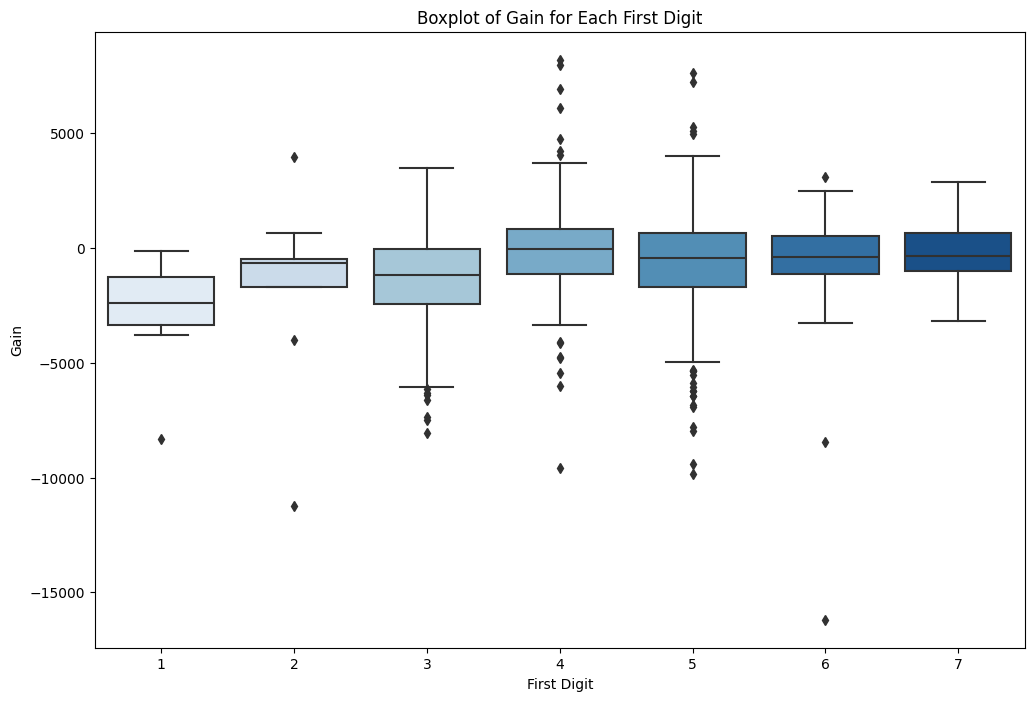

In [340]:
plt.figure(figsize=(12, 8))

# Create a boxplot for each digit
sns.boxplot(x='first_digit', y='gain', data=X_fut,palette='Blues')

plt.title('Boxplot of Gain for Each First Digit')
plt.xlabel('First Digit')
plt.ylabel('Gain')

plt.show()

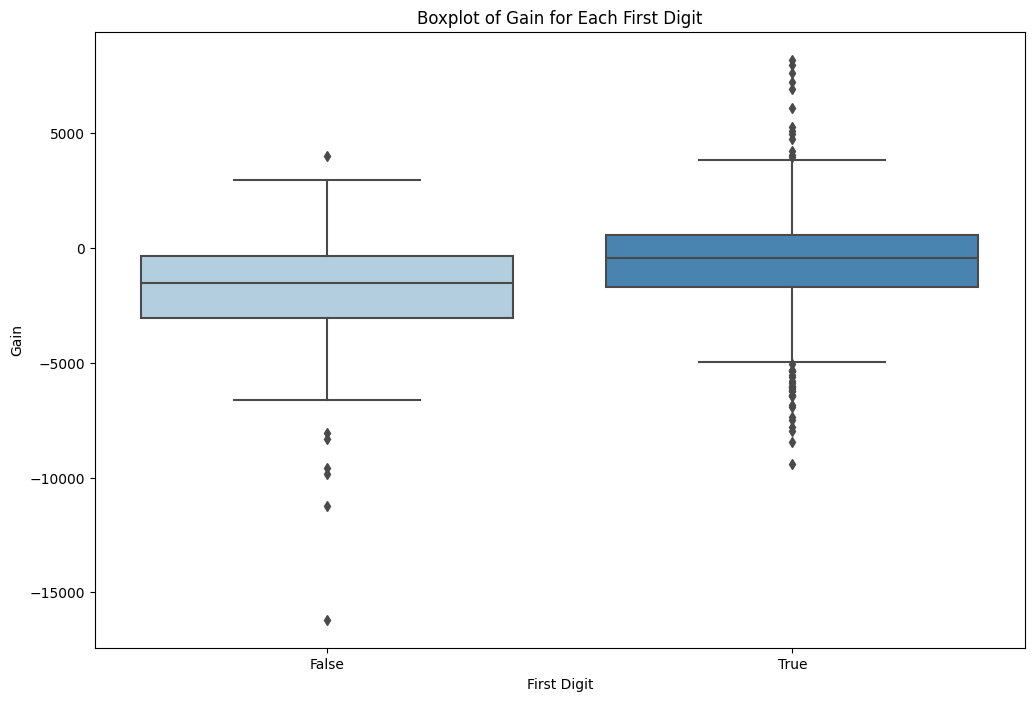

In [349]:
plt.figure(figsize=(12, 8))

# Create a boxplot for each digit
sns.boxplot(x='feature_8', y='gain', data=X_fut,palette='Blues')

plt.title('Boxplot of Gain for Each First Digit')
plt.xlabel('First Digit')
plt.ylabel('Gain')

plt.show()

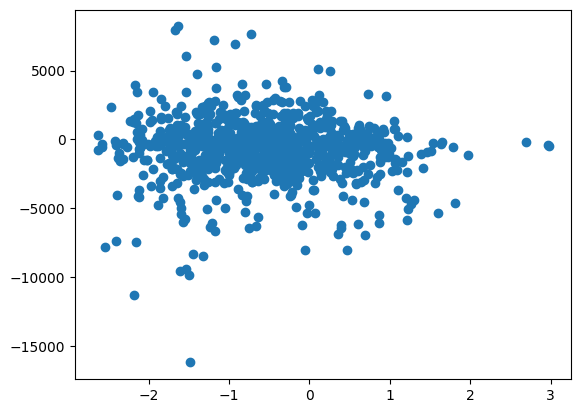

In [345]:
plt.scatter(X_fut['mileage'],X_fut['gain'])

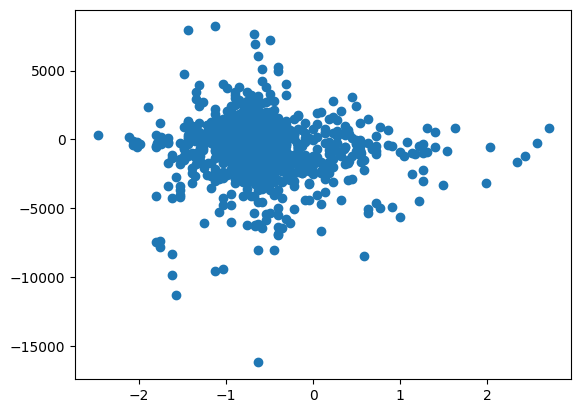

In [346]:
plt.scatter(X_fut['lifespan'],X_fut['gain'])

In [348]:
corr = X_fut.corr()
corr.style.background_gradient(cmap='coolwarm')

All-NaN slice encountered
All-NaN slice encountered


In [344]:
df.iloc[4173]

maker_key                            BMW
model_key                             X4
mileage                            50941
engine_power                         140
registration_date    2015-10-01 00:00:00
fuel                              diesel
car_type                             suv
feature_1                           True
feature_2                           True
feature_3                           True
feature_4                           True
feature_5                           True
feature_6                          False
feature_7                           True
feature_8                           True
price                              30100
sold_at              2018-04-01 00:00:00
first_digit                            4
lifespan                             913
month_sold                             4
fuel_encoded                           0
type_encoded                           5
color__beige                       False
color__black                        True
color__blue     

{'whiskers': [<matplotlib.lines.Line2D at 0x219b8378af0>,
 'caps': [<matplotlib.lines.Line2D at 0x219b8378a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x219b8378730>],
 'medians': [<matplotlib.lines.Line2D at 0x219b837ed30>],
 'fliers': [<matplotlib.lines.Line2D at 0x219b837e3d0>],
 'means': []}

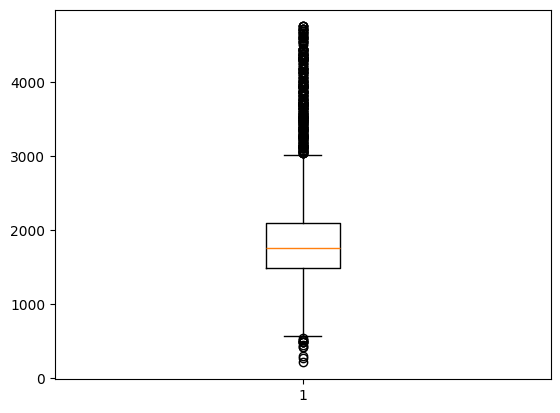

In [362]:
plt.boxplot(pre_std['lifespan'])